# Instructions to create Blocking Alert

1. Make sure a **default** **global** mail profile is set on SQL Server.
2. Compile latest sp\_WhoIsActive **v12.0**
3. Create SQL Agent job category [**(dba) Monitoring & Alerting**]
4. Create SQL Agent job [**(dba) Run-WhoIsActive**] to capture session metrics every 2 minutes
5. Compile base blocking stored procedure **[dbo].[usp_get_blocking_alert]**
6. Create SQL Agent job [**(dba) Alert-SdtBlocking**] to detect & alert for blocking

This blocking has following advantages -

- Easy to understand as the session details of blocker & blocked are present in mail alert itself in nicely formatted tables
- Highly configurable options like blocking threshold, delay between notifications, failure notification etc
- It has inbuilt feature that clears the blocking notification if blocking is resolved automatically.
- Configuration allow to ignore instant blocking notifications, and receive alerts only where blocking is consistent and actionable.
- Multiple recepients can be added to mail notification without any complexity

Below is a typical **active** blocking mail notification -

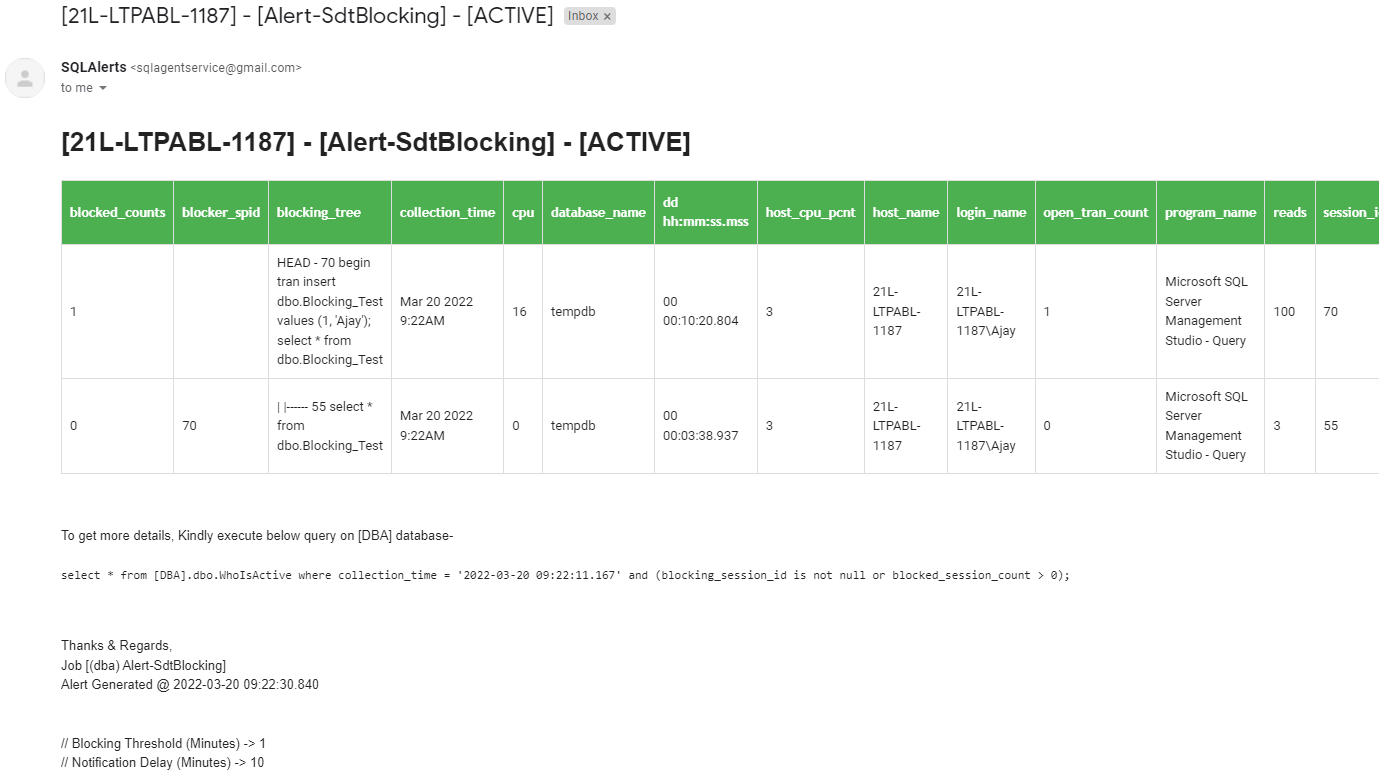  

* * *

Below is a typical **cleared** blocking mail notification -

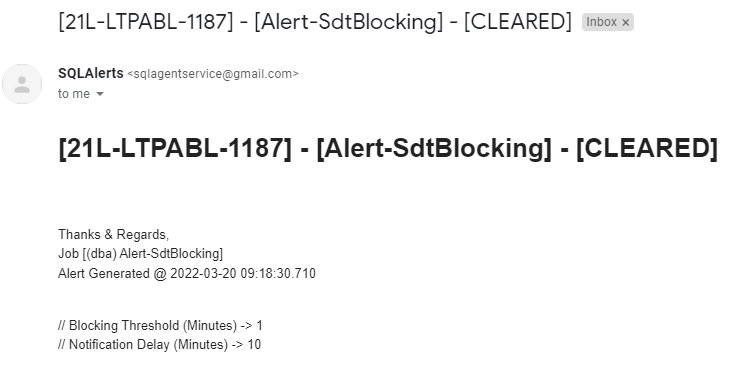

## 1\. Make sure a default global mail profile is set on SQL Server

To achieve this, Expand SqlInstance node -\> Management -\> Right-click "Database Mail" -\> Configure Database Mail -\> Select option "**Manage profile security**" -\> Check Public checkbox, and Select "Yes" for Default for profile that should be set a global default

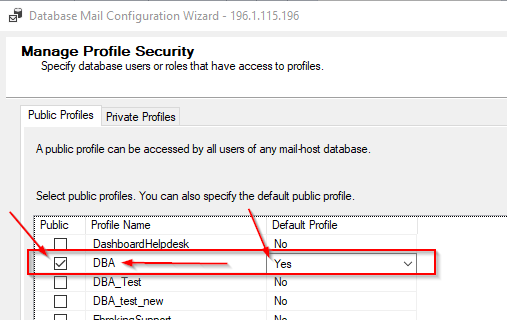

In [ ]:
EXECUTE msdb.dbo.sysmail_add_principalprofile_sp  
    @profile_name = 'DBA',  
    @principal_name = 'public',  
    @is_default = 1 ;

## 2\. Compile latest sp\_WhoIsActive v12.0

Execute below tsql code on **\[master\]** database of SQL Server.

In [2]:
USE master
GO

SET QUOTED_IDENTIFIER ON;
SET ANSI_PADDING ON;
SET CONCAT_NULL_YIELDS_NULL ON;
SET ANSI_WARNINGS ON;
SET NUMERIC_ROUNDABORT OFF;
SET ARITHABORT ON;
GO

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.ROUTINES WHERE ROUTINE_NAME = 'sp_WhoIsActive')
    EXEC ('CREATE PROC dbo.sp_WhoIsActive AS SELECT ''stub version, to be replaced''')
GO

/*********************************************************************************************
Who Is Active? v12.00 (2021-11-10)
(C) 2007-2021, Adam Machanic

Feedback: https://github.com/amachanic/sp_whoisactive/issues
Releases: https://github.com/amachanic/sp_whoisactive/releases
Docs: http://whoisactive.com

License:
    https://github.com/amachanic/sp_whoisactive/blob/master/LICENSE
*********************************************************************************************/
ALTER PROC dbo.sp_WhoIsActive
(
--~
    --Filters--Both inclusive and exclusive
    --Set either filter to '' to disable
    --Valid filter types are: session, program, database, login, and host
    --Session is a session ID, and either 0 or '' can be used to indicate "all" sessions
    --All other filter types support % or _ as wildcards
    @filter sysname = '',
    @filter_type VARCHAR(10) = 'session',
    @not_filter sysname = '',
    @not_filter_type VARCHAR(10) = 'session',

    --Retrieve data about the calling session?
    @show_own_spid BIT = 0,

    --Retrieve data about system sessions?
    @show_system_spids BIT = 0,

    --Controls how sleeping SPIDs are handled, based on the idea of levels of interest
    --0 does not pull any sleeping SPIDs
    --1 pulls only those sleeping SPIDs that also have an open transaction
    --2 pulls all sleeping SPIDs
    @show_sleeping_spids TINYINT = 1,

    --If 1, gets the full stored procedure or running batch, when available
    --If 0, gets only the actual statement that is currently running in the batch or procedure
    @get_full_inner_text BIT = 0,

    --Get associated query plans for running tasks, if available
    --If @get_plans = 1, gets the plan based on the request's statement offset
    --If @get_plans = 2, gets the entire plan based on the request's plan_handle
    @get_plans TINYINT = 0,

    --Get the associated outer ad hoc query or stored procedure call, if available
    @get_outer_command BIT = 0,

    --Enables pulling transaction log write info, transaction duration, and the
    --implicit_transaction identification column
    @get_transaction_info BIT = 0,

    --Get information on active tasks, based on three interest levels
    --Level 0 does not pull any task-related information
    --Level 1 is a lightweight mode that pulls the top non-CXPACKET wait, giving preference to blockers
    --Level 2 pulls all available task-based metrics, including:
    --number of active tasks, current wait stats, physical I/O, context switches, and blocker information
    @get_task_info TINYINT = 1,

    --Gets associated locks for each request, aggregated in an XML format
    @get_locks BIT = 0,

    --Get average time for past runs of an active query
    --(based on the combination of plan handle, sql handle, and offset)
    @get_avg_time BIT = 0,

    --Get additional non-performance-related information about the session or request
    --text_size, language, date_format, date_first, quoted_identifier, arithabort, ansi_null_dflt_on,
    --ansi_defaults, ansi_warnings, ansi_padding, ansi_nulls, concat_null_yields_null,
    --transaction_isolation_level, lock_timeout, deadlock_priority, row_count, command_type
    --
    --If a SQL Agent job is running, an subnode called agent_info will be populated with some or all of
    --the following: job_id, job_name, step_id, step_name, msdb_query_error (in the event of an error)
    --
    --If @get_task_info is set to 2 and a lock wait is detected, a subnode called block_info will be
    --populated with some or all of the following: lock_type, database_name, object_id, file_id, hobt_id,
    --applock_hash, metadata_resource, metadata_class_id, object_name, schema_name
    @get_additional_info BIT = 0,

    --Get additional information related to workspace memory
    --requested_memory, granted_memory, max_used_memory, and memory_info.
    --
    --Not available for SQL Server 2005.
    @get_memory_info BIT = 0,

    --Walk the blocking chain and count the number of
    --total SPIDs blocked all the way down by a given session
    --Also enables task_info Level 1, if @get_task_info is set to 0
    @find_block_leaders BIT = 0,

    --Pull deltas on various metrics
    --Interval in seconds to wait before doing the second data pull
    @delta_interval TINYINT = 0,

    --List of desired output columns, in desired order
    --Note that the final output will be the intersection of all enabled features and all
    --columns in the list. Therefore, only columns associated with enabled features will
    --actually appear in the output. Likewise, removing columns from this list may effectively
    --disable features, even if they are turned on
    --
    --Each element in this list must be one of the valid output column names. Names must be
    --delimited by square brackets. White space, formatting, and additional characters are
    --allowed, as long as the list contains exact matches of delimited valid column names.
    @output_column_list VARCHAR(8000) = '[dd%][session_id][sql_text][sql_command][login_name][wait_info][tasks][tran_log%][cpu%][temp%][block%][reads%][writes%][context%][physical%][query_plan][locks][%]',

    --Column(s) by which to sort output, optionally with sort directions.
        --Valid column choices:
        --session_id, physical_io, reads, physical_reads, writes, tempdb_allocations,
        --tempdb_current, CPU, context_switches, used_memory, physical_io_delta, reads_delta,
        --physical_reads_delta, writes_delta, tempdb_allocations_delta, tempdb_current_delta,
        --CPU_delta, context_switches_delta, used_memory_delta, tasks, tran_start_time,
        --open_tran_count, blocking_session_id, blocked_session_count, percent_complete,
        --host_name, login_name, database_name, start_time, login_time, program_name
        --
        --Note that column names in the list must be bracket-delimited. Commas and/or white
        --space are not required.
    @sort_order VARCHAR(500) = '[start_time] ASC',

    --Formats some of the output columns in a more "human readable" form
    --0 disables outfput format
    --1 formats the output for variable-width fonts
    --2 formats the output for fixed-width fonts
    @format_output TINYINT = 1,

    --If set to a non-blank value, the script will attempt to insert into the specified
    --destination table. Please note that the script will not verify that the table exists,
    --or that it has the correct schema, before doing the insert.
    --Table can be specified in one, two, or three-part format
    @destination_table VARCHAR(4000) = '',

    --If set to 1, no data collection will happen and no result set will be returned; instead,
    --a CREATE TABLE statement will be returned via the @schema parameter, which will match
    --the schema of the result set that would be returned by using the same collection of the
    --rest of the parameters. The CREATE TABLE statement will have a placeholder token of
    --<table_name> in place of an actual table name.
    @return_schema BIT = 0,
    @schema VARCHAR(MAX) = NULL OUTPUT,

    --Help! What do I do?
    @help BIT = 0
--~
)
/*
OUTPUT COLUMNS
--------------
Formatted/Non:    [session_id] [smallint] NOT NULL
    Session ID (a.k.a. SPID)

Formatted:        [dd hh:mm:ss.mss] [varchar](15) NULL
Non-Formatted:    <not returned>
    For an active request, time the query has been running
    For a sleeping session, time since the last batch completed

Formatted:        [dd hh:mm:ss.mss (avg)] [varchar](15) NULL
Non-Formatted:    [avg_elapsed_time] [int] NULL
    (Requires @get_avg_time option)
    How much time has the active portion of the query taken in the past, on average?

Formatted:        [physical_io] [varchar](30) NULL
Non-Formatted:    [physical_io] [bigint] NULL
    Shows the number of physical I/Os, for active requests

Formatted:        [reads] [varchar](30) NULL
Non-Formatted:    [reads] [bigint] NULL
    For an active request, number of reads done for the current query
    For a sleeping session, total number of reads done over the lifetime of the session

Formatted:        [physical_reads] [varchar](30) NULL
Non-Formatted:    [physical_reads] [bigint] NULL
    For an active request, number of physical reads done for the current query
    For a sleeping session, total number of physical reads done over the lifetime of the session

Formatted:        [writes] [varchar](30) NULL
Non-Formatted:    [writes] [bigint] NULL
    For an active request, number of writes done for the current query
    For a sleeping session, total number of writes done over the lifetime of the session

Formatted:        [tempdb_allocations] [varchar](30) NULL
Non-Formatted:    [tempdb_allocations] [bigint] NULL
    For an active request, number of TempDB writes done for the current query
    For a sleeping session, total number of TempDB writes done over the lifetime of the session

Formatted:        [tempdb_current] [varchar](30) NULL
Non-Formatted:    [tempdb_current] [bigint] NULL
    For an active request, number of TempDB pages currently allocated for the query
    For a sleeping session, number of TempDB pages currently allocated for the session

Formatted:        [CPU] [varchar](30) NULL
Non-Formatted:    [CPU] [bigint] NULL
    For an active request, total CPU time consumed by the current query
    For a sleeping session, total CPU time consumed over the lifetime of the session

Formatted:        [context_switches] [varchar](30) NULL
Non-Formatted:    [context_switches] [bigint] NULL
    Shows the number of context switches, for active requests

Formatted:        [used_memory] [varchar](30) NOT NULL
Non-Formatted:    [used_memory] [bigint] NOT NULL
    For an active request, total memory consumption for the current query
    For a sleeping session, total current memory consumption

Formatted:        [max_used_memory] [varchar](30) NULL
Non-Formatted:    [max_used_memory] [bigint] NULL
    (Requires @get_memory_info = 1)
    For an active request, the maximum amount of memory that has been used during
    processing up to the point of observation for the current query

Formatted:        [requested_memory] [varchar](30) NULL
Non-Formatted:    [requested_memory] [bigint] NULL
    (Requires @get_memory_info = 1)
    For an active request, the amount of memory requested by the query processor
    for hash, sort, and parallelism operations

Formatted:        [granted_memory] [varchar](30) NULL
Non-Formatted:    [granted_memory] [bigint] NULL
    (Requires @get_memory_info = 1)
    For an active request, the amount of memory granted to the query processor
    for hash, sort, and parallelism operations

Formatted:        [physical_io_delta] [varchar](30) NULL
Non-Formatted:    [physical_io_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the number of physical I/Os reported on the first and second collections.
    If the request started after the first collection, the value will be NULL

Formatted:        [reads_delta] [varchar](30) NULL
Non-Formatted:    [reads_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the number of reads reported on the first and second collections.
    If the request started after the first collection, the value will be NULL

Formatted:        [physical_reads_delta] [varchar](30) NULL
Non-Formatted:    [physical_reads_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the number of physical reads reported on the first and second collections.
    If the request started after the first collection, the value will be NULL

Formatted:        [writes_delta] [varchar](30) NULL
Non-Formatted:    [writes_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the number of writes reported on the first and second collections.
    If the request started after the first collection, the value will be NULL

Formatted:        [tempdb_allocations_delta] [varchar](30) NULL
Non-Formatted:    [tempdb_allocations_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the number of TempDB writes reported on the first and second collections.
    If the request started after the first collection, the value will be NULL

Formatted:        [tempdb_current_delta] [varchar](30) NULL
Non-Formatted:    [tempdb_current_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the number of allocated TempDB pages reported on the first and second
    collections. If the request started after the first collection, the value will be NULL

Formatted:        [CPU_delta] [varchar](30) NULL
Non-Formatted:    [CPU_delta] [int] NULL
    (Requires @delta_interval option)
    Difference between the CPU time reported on the first and second collections.
    If the request started after the first collection, the value will be NULL

Formatted:        [context_switches_delta] [varchar](30) NULL
Non-Formatted:    [context_switches_delta] [bigint] NULL
    (Requires @delta_interval option)
    Difference between the context switches count reported on the first and second collections
    If the request started after the first collection, the value will be NULL

Formatted:        [used_memory_delta] [varchar](30) NULL
Non-Formatted:    [used_memory_delta] [bigint] NULL
    Difference between the memory usage reported on the first and second collections
    If the request started after the first collection, the value will be NULL

Formatted:        [max_used_memory_delta] [varchar](30) NULL
Non-Formatted:    [max_used_memory_delta] [bigint] NULL
    Difference between the max memory usage reported on the first and second collections
    If the request started after the first collection, the value will be NULL

Formatted:        [tasks] [varchar](30) NULL
Non-Formatted:    [tasks] [smallint] NULL
    Number of worker tasks currently allocated, for active requests

Formatted/Non:    [status] [varchar](30) NOT NULL
    Activity status for the session (running, sleeping, etc)

Formatted/Non:    [wait_info] [nvarchar](4000) NULL
    Aggregates wait information, in the following format:
        (Ax: Bms/Cms/Dms)E
    A is the number of waiting tasks currently waiting on resource type E. B/C/D are wait
    times, in milliseconds. If only one thread is waiting, its wait time will be shown as B.
    If two tasks are waiting, each of their wait times will be shown (B/C). If three or more
    tasks are waiting, the minimum, average, and maximum wait times will be shown (B/C/D).
    If wait type E is a page latch wait and the page is of a "special" type (e.g. PFS, GAM, SGAM),
    the page type will be identified.
    If wait type E is CXPACKET, CXCONSUMER, CXSYNC_PORT, or CXSYNC_CONSUMER the nodeId from the
    query plan will be identified

Formatted/Non:    [locks] [xml] NULL
    (Requires @get_locks option)
    Aggregates lock information, in XML format.
    The lock XML includes the lock mode, locked object, and aggregates the number of requests.
    Attempts are made to identify locked objects by name

Formatted/Non:    [tran_start_time] [datetime] NULL
    (Requires @get_transaction_info option)
    Date and time that the first transaction opened by a session caused a transaction log
    write to occur.

Formatted/Non:    [tran_log_writes] [nvarchar](4000) NULL
    (Requires @get_transaction_info option)
    Aggregates transaction log write information, in the following format:
    A:wB (C kB)
    A is a database that has been touched by an active transaction
    B is the number of log writes that have been made in the database as a result of the transaction
    C is the number of log kilobytes consumed by the log records

Formatted/Non:    [implicit_tran] [nvarchar](3) NULL
    (Requires @get_transaction_info option)
    For active read-write transactions, returns on "ON" the transaction has been started as a result
    of the session using the implicit_transactions option, or "OFF" otherwise.

Formatted:        [open_tran_count] [varchar](30) NULL
Non-Formatted:    [open_tran_count] [smallint] NULL
    Shows the number of open transactions the session has open

Formatted:        [sql_command] [xml] NULL
Non-Formatted:    [sql_command] [nvarchar](max) NULL
    (Requires @get_outer_command option)
    Shows the "outer" SQL command, i.e. the text of the batch or RPC sent to the server,
    if available

Formatted:        [sql_text] [xml] NULL
Non-Formatted:    [sql_text] [nvarchar](max) NULL
    Shows the SQL text for active requests or the last statement executed
    for sleeping sessions, if available in either case.
    If @get_full_inner_text option is set, shows the full text of the batch.
    Otherwise, shows only the active statement within the batch.
    If the query text is locked, a special timeout message will be sent, in the following format:
        <timeout_exceeded />
    If an error occurs, an error message will be sent, in the following format:
        <error message="message" />

Formatted/Non:    [query_plan] [xml] NULL
    (Requires @get_plans option)
    Shows the query plan for the request, if available.
    If the plan is locked, a special timeout message will be sent, in the following format:
        <timeout_exceeded />
    If an error occurs, an error message will be sent, in the following format:
        <error message="message" />

Formatted/Non:    [blocking_session_id] [smallint] NULL
    When applicable, shows the blocking SPID

Formatted:        [blocked_session_count] [varchar](30) NULL
Non-Formatted:    [blocked_session_count] [smallint] NULL
    (Requires @find_block_leaders option)
    The total number of SPIDs blocked by this session,
    all the way down the blocking chain.

Formatted:        [percent_complete] [varchar](30) NULL
Non-Formatted:    [percent_complete] [real] NULL
    When applicable, shows the percent complete (e.g. for backups, restores, and some rollbacks)

Formatted/Non:    [host_name] [sysname] NOT NULL
    Shows the host name for the connection

Formatted/Non:    [login_name] [sysname] NOT NULL
    Shows the login name for the connection

Formatted/Non:    [database_name] [sysname] NULL
    Shows the connected database

Formatted/Non:    [program_name] [sysname] NULL
    Shows the reported program/application name

Formatted/Non:    [additional_info] [xml] NULL
    (Requires @get_additional_info option)
    Returns additional non-performance-related session/request information
    If the script finds a SQL Agent job running, the name of the job and job step will be reported
    If @get_task_info = 2 and the script finds a lock wait, the locked object will be reported

Formatted/Non:    [start_time] [datetime] NOT NULL
    For active requests, shows the time the request started
    For sleeping sessions, shows the time the last batch completed

Formatted/Non:    [login_time] [datetime] NOT NULL
    Shows the time that the session connected

Formatted/Non:    [request_id] [int] NULL
    For active requests, shows the request_id
    Should be 0 unless MARS is being used

Formatted/Non:    [collection_time] [datetime] NOT NULL
    Time that this script's final SELECT ran

Formatted/Non:    [memory_info] [xml] NULL
    (Requires @get_memory_info)
    For active queries that require workspace memory, returns information on memory grants,
    resource semaphores, and the resource governor settings that are impacting the allocation.
*/
AS
BEGIN;
    SET NOCOUNT ON;
    SET TRANSACTION ISOLATION LEVEL READ UNCOMMITTED;
    SET QUOTED_IDENTIFIER ON;
    SET ANSI_PADDING ON;
    SET CONCAT_NULL_YIELDS_NULL ON;
    SET ANSI_WARNINGS ON;
    SET NUMERIC_ROUNDABORT OFF;
    SET ARITHABORT ON;

    IF
        @filter IS NULL
        OR @filter_type IS NULL
        OR @not_filter IS NULL
        OR @not_filter_type IS NULL
        OR @show_own_spid IS NULL
        OR @show_system_spids IS NULL
        OR @show_sleeping_spids IS NULL
        OR @get_full_inner_text IS NULL
        OR @get_plans IS NULL
        OR @get_outer_command IS NULL
        OR @get_transaction_info IS NULL
        OR @get_task_info IS NULL
        OR @get_locks IS NULL
        OR @get_avg_time IS NULL
        OR @get_additional_info IS NULL
        OR @find_block_leaders IS NULL
        OR @delta_interval IS NULL
        OR @format_output IS NULL
        OR @output_column_list IS NULL
        OR @sort_order IS NULL
        OR @return_schema IS NULL
        OR @destination_table IS NULL
        OR @help IS NULL
    BEGIN;
        RAISERROR('Input parameters cannot be NULL', 16, 1);
        RETURN;
    END;
   
    IF @filter_type NOT IN ('session', 'program', 'database', 'login', 'host')
    BEGIN;
        RAISERROR('Valid filter types are: session, program, database, login, host', 16, 1);
        RETURN;
    END;
   
    IF @filter_type = 'session' AND @filter LIKE '%[^0123456789]%'
    BEGIN;
        RAISERROR('Session filters must be valid integers', 16, 1);
        RETURN;
    END;
   
    IF @not_filter_type NOT IN ('session', 'program', 'database', 'login', 'host')
    BEGIN;
        RAISERROR('Valid filter types are: session, program, database, login, host', 16, 1);
        RETURN;
    END;
   
    IF @not_filter_type = 'session' AND @not_filter LIKE '%[^0123456789]%'
    BEGIN;
        RAISERROR('Session filters must be valid integers', 16, 1);
        RETURN;
    END;
   
    IF @show_sleeping_spids NOT IN (0, 1, 2)
    BEGIN;
        RAISERROR('Valid values for @show_sleeping_spids are: 0, 1, or 2', 16, 1);
        RETURN;
    END;
   
    IF @get_plans NOT IN (0, 1, 2)
    BEGIN;
        RAISERROR('Valid values for @get_plans are: 0, 1, or 2', 16, 1);
        RETURN;
    END;

    IF @get_task_info NOT IN (0, 1, 2)
    BEGIN;
        RAISERROR('Valid values for @get_task_info are: 0, 1, or 2', 16, 1);
        RETURN;
    END;

    IF @format_output NOT IN (0, 1, 2)
    BEGIN;
        RAISERROR('Valid values for @format_output are: 0, 1, or 2', 16, 1);
        RETURN;
    END;

    IF @get_memory_info = 1 AND NOT EXISTS (SELECT * FROM sys.all_objects WHERE name = 'resource_governor_resource_pools')
    BEGIN;
        RAISERROR('@get_memory_info is not available for SQL Server 2005.', 16, 1);
        RETURN;
    END;

    IF @help = 1
    BEGIN;
        DECLARE
            @header VARCHAR(MAX),
            @params VARCHAR(MAX),
            @outputs VARCHAR(MAX);

        SELECT
            @header =
                REPLACE
                (
                    REPLACE
                    (
                        CONVERT
                        (
                            VARCHAR(MAX),
                            SUBSTRING
                            (
                                t.text,
                                CHARINDEX('/' + REPLICATE('*', 93), t.text) + 94,
                                CHARINDEX(REPLICATE('*', 93) + '/', t.text) - (CHARINDEX('/' + REPLICATE('*', 93), t.text) + 94)
                            )
                        ),
                        CHAR(13)+CHAR(10),
                        CHAR(13)
                    ),
                    '    ',
                    ''
                ),
            @params =
                CHAR(13) +
                    REPLACE
                    (
                        REPLACE
                        (
                            CONVERT
                            (
                                VARCHAR(MAX),
                                SUBSTRING
                                (
                                    t.text,
                                    CHARINDEX('--~', t.text) + 5,
                                    CHARINDEX('--~', t.text, CHARINDEX('--~', t.text) + 5) - (CHARINDEX('--~', t.text) + 5)
                                )
                            ),
                            CHAR(13)+CHAR(10),
                            CHAR(13)
                        ),
                        '    ',
                        ''
                    ),
                @outputs =
                    CHAR(13) +
                        REPLACE
                        (
                            REPLACE
                            (
                                REPLACE
                                (
                                    CONVERT
                                    (
                                        VARCHAR(MAX),
                                        SUBSTRING
                                        (
                                            t.text,
                                            CHARINDEX('OUTPUT COLUMNS'+CHAR(13)+CHAR(10)+'--------------', t.text) + 32,
                                            CHARINDEX('*/', t.text, CHARINDEX('OUTPUT COLUMNS'+CHAR(13)+CHAR(10)+'--------------', t.text) + 32) - (CHARINDEX('OUTPUT COLUMNS'+CHAR(13)+CHAR(10)+'--------------', t.text) + 32)
                                        )
                                    ),
                                    '    ',
                                    CHAR(255)
                                ),
                                CHAR(13)+CHAR(10),
                                CHAR(13)
                            ),
                            '    ',
                            ''
                        ) +
                        CHAR(13)
        FROM sys.dm_exec_requests AS r
        CROSS APPLY sys.dm_exec_sql_text(r.sql_handle) AS t
        WHERE
            r.session_id = @@SPID;

        WITH
        a0 AS
        (SELECT 1 AS n UNION ALL SELECT 1),
        a1 AS
        (SELECT 1 AS n FROM a0 AS a CROSS JOIN a0 AS b),
        a2 AS
        (SELECT 1 AS n FROM a1 AS a CROSS JOIN a1 AS b),
        a3 AS
        (SELECT 1 AS n FROM a2 AS a CROSS JOIN a2 AS b),
        a4 AS
        (SELECT 1 AS n FROM a3 AS a CROSS JOIN a3 AS b),
        numbers AS
        (
            SELECT TOP(LEN(@header) - 1)
                ROW_NUMBER() OVER
                (
                    ORDER BY (SELECT NULL)
                ) AS number
            FROM a4
            ORDER BY
                number
        )
        SELECT
            RTRIM(LTRIM(
                SUBSTRING
                (
                    @header,
                    number + 1,
                    CHARINDEX(CHAR(13), @header, number + 1) - number - 1
                )
            )) AS [------header---------------------------------------------------------------------------------------------------------------]
        FROM numbers
        WHERE
            SUBSTRING(@header, number, 1) = CHAR(13);

        WITH
        a0 AS
        (SELECT 1 AS n UNION ALL SELECT 1),
        a1 AS
        (SELECT 1 AS n FROM a0 AS a CROSS JOIN a0 AS b),
        a2 AS
        (SELECT 1 AS n FROM a1 AS a CROSS JOIN a1 AS b),
        a3 AS
        (SELECT 1 AS n FROM a2 AS a CROSS JOIN a2 AS b),
        a4 AS
        (SELECT 1 AS n FROM a3 AS a CROSS JOIN a3 AS b),
        numbers AS
        (
            SELECT TOP(LEN(@params) - 1)
                ROW_NUMBER() OVER
                (
                    ORDER BY (SELECT NULL)
                ) AS number
            FROM a4
            ORDER BY
                number
        ),
        tokens AS
        (
            SELECT
                RTRIM(LTRIM(
                    SUBSTRING
                    (
                        @params,
                        number + 1,
                        CHARINDEX(CHAR(13), @params, number + 1) - number - 1
                    )
                )) AS token,
                number,
                CASE
                    WHEN SUBSTRING(@params, number + 1, 1) = CHAR(13) THEN number
                    ELSE COALESCE(NULLIF(CHARINDEX(',' + CHAR(13) + CHAR(13), @params, number), 0), LEN(@params))
                END AS param_group,
                ROW_NUMBER() OVER
                (
                    PARTITION BY
                        CHARINDEX(',' + CHAR(13) + CHAR(13), @params, number),
                        SUBSTRING(@params, number+1, 1)
                    ORDER BY
                        number
                ) AS group_order
            FROM numbers
            WHERE
                SUBSTRING(@params, number, 1) = CHAR(13)
        ),
        parsed_tokens AS
        (
            SELECT
                MIN
                (
                    CASE
                        WHEN token LIKE '@%' THEN token
                        ELSE NULL
                    END
                ) AS parameter,
                MIN
                (
                    CASE
                        WHEN token LIKE '--%' THEN RIGHT(token, LEN(token) - 2)
                        ELSE NULL
                    END
                ) AS description,
                param_group,
                group_order
            FROM tokens
            WHERE
                NOT
                (
                    token = ''
                    AND group_order > 1
                )
            GROUP BY
                param_group,
                group_order
        )
        SELECT
            CASE
                WHEN description IS NULL AND parameter IS NULL THEN '-------------------------------------------------------------------------'
                WHEN param_group = MAX(param_group) OVER() THEN parameter
                ELSE COALESCE(LEFT(parameter, LEN(parameter) - 1), '')
            END AS [------parameter----------------------------------------------------------],
            CASE
                WHEN description IS NULL AND parameter IS NULL THEN '----------------------------------------------------------------------------------------------------------------------'
                ELSE COALESCE(description, '')
            END AS [------description-----------------------------------------------------------------------------------------------------]
        FROM parsed_tokens
        ORDER BY
            param_group,
            group_order;
       
        WITH
        a0 AS
        (SELECT 1 AS n UNION ALL SELECT 1),
        a1 AS
        (SELECT 1 AS n FROM a0 AS a CROSS JOIN a0 AS b),
        a2 AS
        (SELECT 1 AS n FROM a1 AS a CROSS JOIN a1 AS b),
        a3 AS
        (SELECT 1 AS n FROM a2 AS a CROSS JOIN a2 AS b),
        a4 AS
        (SELECT 1 AS n FROM a3 AS a CROSS JOIN a3 AS b),
        numbers AS
        (
            SELECT TOP(LEN(@outputs) - 1)
                ROW_NUMBER() OVER
                (
                    ORDER BY (SELECT NULL)
                ) AS number
            FROM a4
            ORDER BY
                number
        ),
        tokens AS
        (
            SELECT
                RTRIM(LTRIM(
                    SUBSTRING
                    (
                        @outputs,
                        number + 1,
                        CASE
                            WHEN
                                COALESCE(NULLIF(CHARINDEX(CHAR(13) + 'Formatted', @outputs, number + 1), 0), LEN(@outputs)) <
                                    COALESCE(NULLIF(CHARINDEX(CHAR(13) + CHAR(255) COLLATE Latin1_General_Bin2, @outputs, number + 1), 0), LEN(@outputs))
                                THEN COALESCE(NULLIF(CHARINDEX(CHAR(13) + 'Formatted', @outputs, number + 1), 0), LEN(@outputs)) - number - 1
                            ELSE
                                COALESCE(NULLIF(CHARINDEX(CHAR(13) + CHAR(255) COLLATE Latin1_General_Bin2, @outputs, number + 1), 0), LEN(@outputs)) - number - 1
                        END
                    )
                )) AS token,
                number,
                COALESCE(NULLIF(CHARINDEX(CHAR(13) + 'Formatted', @outputs, number + 1), 0), LEN(@outputs)) AS output_group,
                ROW_NUMBER() OVER
                (
                    PARTITION BY
                        COALESCE(NULLIF(CHARINDEX(CHAR(13) + 'Formatted', @outputs, number + 1), 0), LEN(@outputs))
                    ORDER BY
                        number
                ) AS output_group_order
            FROM numbers
            WHERE
                SUBSTRING(@outputs, number, 10) = CHAR(13) + 'Formatted'
                OR SUBSTRING(@outputs, number, 2) = CHAR(13) + CHAR(255) COLLATE Latin1_General_Bin2
        ),
        output_tokens AS
        (
            SELECT
                *,
                CASE output_group_order
                    WHEN 2 THEN MAX(CASE output_group_order WHEN 1 THEN token ELSE NULL END) OVER (PARTITION BY output_group)
                    ELSE ''
                END COLLATE Latin1_General_Bin2 AS column_info
            FROM tokens
        )
        SELECT
            CASE output_group_order
                WHEN 1 THEN '-----------------------------------'
                WHEN 2 THEN
                    CASE
                        WHEN CHARINDEX('Formatted/Non:', column_info) = 1 THEN
                            SUBSTRING(column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info)+1, CHARINDEX(']', column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info)+2) - CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info))
                        ELSE
                            SUBSTRING(column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info)+2, CHARINDEX(']', column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info)+2) - CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info)-1)
                    END
                ELSE ''
            END AS formatted_column_name,
            CASE output_group_order
                WHEN 1 THEN '-----------------------------------'
                WHEN 2 THEN
                    CASE
                        WHEN CHARINDEX('Formatted/Non:', column_info) = 1 THEN
                            SUBSTRING(column_info, CHARINDEX(']', column_info)+2, LEN(column_info))
                        ELSE
                            SUBSTRING(column_info, CHARINDEX(']', column_info)+2, CHARINDEX('Non-Formatted:', column_info, CHARINDEX(']', column_info)+2) - CHARINDEX(']', column_info)-3)
                    END
                ELSE ''
            END AS formatted_column_type,
            CASE output_group_order
                WHEN 1 THEN '---------------------------------------'
                WHEN 2 THEN
                    CASE
                        WHEN CHARINDEX('Formatted/Non:', column_info) = 1 THEN ''
                        ELSE
                            CASE
                                WHEN SUBSTRING(column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info))+1, 1) = '<' THEN
                                    SUBSTRING(column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info))+1, CHARINDEX('>', column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info))+1) - CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info)))
                                ELSE
                                    SUBSTRING(column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info))+1, CHARINDEX(']', column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info))+1) - CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info)))
                            END
                    END
                ELSE ''
            END AS unformatted_column_name,
            CASE output_group_order
                WHEN 1 THEN '---------------------------------------'
                WHEN 2 THEN
                    CASE
                        WHEN CHARINDEX('Formatted/Non:', column_info) = 1 THEN ''
                        ELSE
                            CASE
                                WHEN SUBSTRING(column_info, CHARINDEX(CHAR(255) COLLATE Latin1_General_Bin2, column_info, CHARINDEX('Non-Formatted:', column_info))+1, 1) = '<' THEN ''
                                ELSE
                                    SUBSTRING(column_info, CHARINDEX(']', column_info, CHARINDEX('Non-Formatted:', column_info))+2, CHARINDEX('Non-Formatted:', column_info, CHARINDEX(']', column_info)+2) - CHARINDEX(']', column_info)-3)
                            END
                    END
                ELSE ''
            END AS unformatted_column_type,
            CASE output_group_order
                WHEN 1 THEN '----------------------------------------------------------------------------------------------------------------------'
                ELSE REPLACE(token, CHAR(255) COLLATE Latin1_General_Bin2, '')
            END AS [------description-----------------------------------------------------------------------------------------------------]
        FROM output_tokens
        WHERE
            NOT
            (
                output_group_order = 1
                AND output_group = LEN(@outputs)
            )
        ORDER BY
            output_group,
            CASE output_group_order
                WHEN 1 THEN 99
                ELSE output_group_order
            END;

        RETURN;
    END;

    WITH
    a0 AS
    (SELECT 1 AS n UNION ALL SELECT 1),
    a1 AS
    (SELECT 1 AS n FROM a0 AS a CROSS JOIN a0 AS b),
    a2 AS
    (SELECT 1 AS n FROM a1 AS a CROSS JOIN a1 AS b),
    a3 AS
    (SELECT 1 AS n FROM a2 AS a CROSS JOIN a2 AS b),
    a4 AS
    (SELECT 1 AS n FROM a3 AS a CROSS JOIN a3 AS b),
    numbers AS
    (
        SELECT TOP(LEN(@output_column_list))
            ROW_NUMBER() OVER
            (
                ORDER BY (SELECT NULL)
            ) AS number
        FROM a4
        ORDER BY
            number
    ),
    tokens AS
    (
        SELECT
            '|[' +
                SUBSTRING
                (
                    @output_column_list,
                    number + 1,
                    CHARINDEX(']', @output_column_list, number) - number - 1
                ) + '|]' AS token,
            number
        FROM numbers
        WHERE
            SUBSTRING(@output_column_list, number, 1) = '['
    ),
    ordered_columns AS
    (
        SELECT
            x.column_name,
            ROW_NUMBER() OVER
            (
                PARTITION BY
                    x.column_name
                ORDER BY
                    tokens.number,
                    x.default_order
            ) AS r,
            ROW_NUMBER() OVER
            (
                ORDER BY
                    tokens.number,
                    x.default_order
            ) AS s
        FROM tokens
        JOIN
        (
            SELECT '[session_id]' AS column_name, 1 AS default_order
            UNION ALL
            SELECT '[dd hh:mm:ss.mss]', 2
            WHERE
                @format_output IN (1, 2)
            UNION ALL
            SELECT '[dd hh:mm:ss.mss (avg)]', 3
            WHERE
                @format_output IN (1, 2)
                AND @get_avg_time = 1
            UNION ALL
            SELECT '[avg_elapsed_time]', 4
            WHERE
                @format_output = 0
                AND @get_avg_time = 1
            UNION ALL
            SELECT '[physical_io]', 5
            WHERE
                @get_task_info = 2
            UNION ALL
            SELECT '[reads]', 6
            UNION ALL
            SELECT '[physical_reads]', 7
            UNION ALL
            SELECT '[writes]', 8
            UNION ALL
            SELECT '[tempdb_allocations]', 9
            UNION ALL
            SELECT '[tempdb_current]', 10
            UNION ALL
            SELECT '[CPU]', 11
            UNION ALL
            SELECT '[context_switches]', 12
            WHERE
                @get_task_info = 2
            UNION ALL
            SELECT '[used_memory]', 13
            UNION ALL
            SELECT '[max_used_memory]', 14
            WHERE
                @get_memory_info = 1
            UNION ALL
            SELECT '[requested_memory]', 15
            WHERE
                @get_memory_info = 1
            UNION ALL
            SELECT '[granted_memory]', 16
            WHERE
                @get_memory_info = 1
            UNION ALL
            SELECT '[physical_io_delta]', 17
            WHERE
                @delta_interval > 0   
                AND @get_task_info = 2
            UNION ALL
            SELECT '[reads_delta]', 18
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[physical_reads_delta]', 19
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[writes_delta]', 20
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[tempdb_allocations_delta]', 21
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[tempdb_current_delta]', 22
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[CPU_delta]', 23
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[context_switches_delta]', 24
            WHERE
                @delta_interval > 0
                AND @get_task_info = 2
            UNION ALL
            SELECT '[used_memory_delta]', 25
            WHERE
                @delta_interval > 0
            UNION ALL
            SELECT '[max_used_memory_delta]', 26
            WHERE
                @delta_interval > 0
                AND @get_memory_info = 1
            UNION ALL
            SELECT '[tasks]', 27
            WHERE
                @get_task_info = 2
            UNION ALL
            SELECT '[status]', 28
            UNION ALL
            SELECT '[wait_info]', 29
            WHERE
                @get_task_info > 0
                OR @find_block_leaders = 1
            UNION ALL
            SELECT '[locks]', 30
            WHERE
                @get_locks = 1
            UNION ALL
            SELECT '[tran_start_time]', 31
            WHERE
                @get_transaction_info = 1
            UNION ALL
            SELECT '[tran_log_writes]', 32
            WHERE
                @get_transaction_info = 1
            UNION ALL
            SELECT '[implicit_tran]', 33
            WHERE
                @get_transaction_info = 1
            UNION ALL
            SELECT '[open_tran_count]', 34
            UNION ALL
            SELECT '[sql_command]', 35
            WHERE
                @get_outer_command = 1
            UNION ALL
            SELECT '[sql_text]', 36
            UNION ALL
            SELECT '[query_plan]', 37
            WHERE
                @get_plans >= 1
            UNION ALL
            SELECT '[blocking_session_id]', 38
            WHERE
                @get_task_info > 0
                OR @find_block_leaders = 1
            UNION ALL
            SELECT '[blocked_session_count]', 39
            WHERE
                @find_block_leaders = 1
            UNION ALL
            SELECT '[percent_complete]', 40
            UNION ALL
            SELECT '[host_name]', 41
            UNION ALL
            SELECT '[login_name]', 42
            UNION ALL
            SELECT '[database_name]', 43
            UNION ALL
            SELECT '[program_name]', 44
            UNION ALL
            SELECT '[additional_info]', 45
            WHERE
                @get_additional_info = 1
            UNION ALL
            SELECT '[memory_info]', 46
            WHERE
                @get_memory_info = 1
            UNION ALL
            SELECT '[start_time]', 47
            UNION ALL
            SELECT '[login_time]', 48
            UNION ALL
            SELECT '[request_id]', 49
            UNION ALL
            SELECT '[collection_time]', 50
        ) AS x ON
            x.column_name LIKE token ESCAPE '|'
    )
    SELECT
        @output_column_list =
            STUFF
            (
                (
                    SELECT
                        ',' + column_name as [text()]
                    FROM ordered_columns
                    WHERE
                        r = 1
                    ORDER BY
                        s
                    FOR XML
                        PATH('')
                ),
                1,
                1,
                ''
            );
   
    IF COALESCE(RTRIM(@output_column_list), '') = ''
    BEGIN;
        RAISERROR('No valid column matches found in @output_column_list or no columns remain due to selected options.', 16, 1);
        RETURN;
    END;
   
    IF @destination_table <> ''
    BEGIN;
        SET @destination_table =
            --database
            COALESCE(QUOTENAME(PARSENAME(@destination_table, 3)) + '.', '') +
            --schema
            COALESCE(QUOTENAME(PARSENAME(@destination_table, 2)) + '.', '') +
            --table
            COALESCE(QUOTENAME(PARSENAME(@destination_table, 1)), '');
           
        IF COALESCE(RTRIM(@destination_table), '') = ''
        BEGIN;
            RAISERROR('Destination table not properly formatted.', 16, 1);
            RETURN;
        END;
    END;

    WITH
    a0 AS
    (SELECT 1 AS n UNION ALL SELECT 1),
    a1 AS
    (SELECT 1 AS n FROM a0 AS a CROSS JOIN a0 AS b),
    a2 AS
    (SELECT 1 AS n FROM a1 AS a CROSS JOIN a1 AS b),
    a3 AS
    (SELECT 1 AS n FROM a2 AS a CROSS JOIN a2 AS b),
    a4 AS
    (SELECT 1 AS n FROM a3 AS a CROSS JOIN a3 AS b),
    numbers AS
    (
        SELECT TOP(LEN(@sort_order))
            ROW_NUMBER() OVER
            (
                ORDER BY (SELECT NULL)
            ) AS number
        FROM a4
        ORDER BY
            number
    ),
    tokens AS
    (
        SELECT
            '|[' +
                SUBSTRING
                (
                    @sort_order,
                    number + 1,
                    CHARINDEX(']', @sort_order, number) - number - 1
                ) + '|]' AS token,
            SUBSTRING
            (
                @sort_order,
                CHARINDEX(']', @sort_order, number) + 1,
                COALESCE(NULLIF(CHARINDEX('[', @sort_order, CHARINDEX(']', @sort_order, number)), 0), LEN(@sort_order)) - CHARINDEX(']', @sort_order, number)
            ) AS next_chunk,
            number
        FROM numbers
        WHERE
            SUBSTRING(@sort_order, number, 1) = '['
    ),
    ordered_columns AS
    (
        SELECT
            x.column_name +
                CASE
                    WHEN LOWER(tokens.next_chunk) LIKE '%asc%' THEN ' ASC'
                    WHEN LOWER(tokens.next_chunk) LIKE '%desc%' THEN ' DESC'
                    ELSE ''
                END AS column_name,
            ROW_NUMBER() OVER
            (
                PARTITION BY
                    x.column_name
                ORDER BY
                    tokens.number
            ) AS r,
            tokens.number
        FROM tokens
        JOIN
        (
            SELECT '[session_id]' AS column_name
            UNION ALL
            SELECT '[physical_io]'
            UNION ALL
            SELECT '[reads]'
            UNION ALL
            SELECT '[physical_reads]'
            UNION ALL
            SELECT '[writes]'
            UNION ALL
            SELECT '[tempdb_allocations]'
            UNION ALL
            SELECT '[tempdb_current]'
            UNION ALL
            SELECT '[CPU]'
            UNION ALL
            SELECT '[context_switches]'
            UNION ALL
            SELECT '[used_memory]'
            UNION ALL
            SELECT '[max_used_memory]'
            UNION ALL
            SELECT '[requested_memory]'
            UNION ALL
            SELECT '[granted_memory]'
            UNION ALL
            SELECT '[physical_io_delta]'
            UNION ALL
            SELECT '[reads_delta]'
            UNION ALL
            SELECT '[physical_reads_delta]'
            UNION ALL
            SELECT '[writes_delta]'
            UNION ALL
            SELECT '[tempdb_allocations_delta]'
            UNION ALL
            SELECT '[tempdb_current_delta]'
            UNION ALL
            SELECT '[CPU_delta]'
            UNION ALL
            SELECT '[context_switches_delta]'
            UNION ALL
            SELECT '[used_memory_delta]'
            UNION ALL
            SELECT '[max_used_memory_delta]'
            UNION ALL
            SELECT '[tasks]'
            UNION ALL
            SELECT '[tran_start_time]'
            UNION ALL
            SELECT '[open_tran_count]'
            UNION ALL
            SELECT '[blocking_session_id]'
            UNION ALL
            SELECT '[blocked_session_count]'
            UNION ALL
            SELECT '[percent_complete]'
            UNION ALL
            SELECT '[host_name]'
            UNION ALL
            SELECT '[login_name]'
            UNION ALL
            SELECT '[database_name]'
            UNION ALL
            SELECT '[start_time]'
            UNION ALL
            SELECT '[login_time]'
            UNION ALL
            SELECT '[program_name]'
        ) AS x ON
            x.column_name LIKE token ESCAPE '|'
    )
    SELECT
        @sort_order = COALESCE(z.sort_order, '')
    FROM
    (
        SELECT
            STUFF
            (
                (
                    SELECT
                        ',' + column_name as [text()]
                    FROM ordered_columns
                    WHERE
                        r = 1
                    ORDER BY
                        number
                    FOR XML
                        PATH('')
                ),
                1,
                1,
                ''
            ) AS sort_order
    ) AS z;

    CREATE TABLE #sessions
    (
        recursion SMALLINT NOT NULL,
        session_id SMALLINT NOT NULL,
        request_id INT NOT NULL,
        session_number INT NOT NULL,
        elapsed_time INT NOT NULL,
        avg_elapsed_time INT NULL,
        physical_io BIGINT NULL,
        reads BIGINT NULL,
        physical_reads BIGINT NULL,
        writes BIGINT NULL,
        tempdb_allocations BIGINT NULL,
        tempdb_current BIGINT NULL,
        CPU BIGINT NULL,
        thread_CPU_snapshot BIGINT NULL,
        context_switches BIGINT NULL,
        used_memory BIGINT NOT NULL,
        max_used_memory BIGINT NULL,
        requested_memory BIGINT NULL,
        granted_memory BIGINT NULL,
        tasks SMALLINT NULL,
        status VARCHAR(30) NOT NULL,
        wait_info NVARCHAR(4000) NULL,
        locks XML NULL,
        transaction_id BIGINT NULL,
        tran_start_time DATETIME NULL,
        tran_log_writes NVARCHAR(4000) NULL,
        implicit_tran NVARCHAR(3) NULL,
        open_tran_count SMALLINT NULL,
        sql_command XML NULL,
        sql_handle VARBINARY(64) NULL,
        statement_start_offset INT NULL,
        statement_end_offset INT NULL,
        sql_text XML NULL,
        plan_handle VARBINARY(64) NULL,
        query_plan XML NULL,
        blocking_session_id SMALLINT NULL,
        blocked_session_count SMALLINT NULL,
        percent_complete REAL NULL,
        host_name sysname NULL,
        login_name sysname NOT NULL,
        database_name sysname NULL,
        program_name sysname NULL,
        additional_info XML NULL,
        memory_info XML NULL,
        start_time DATETIME NOT NULL,
        login_time DATETIME NULL,
        last_request_start_time DATETIME NULL,
        PRIMARY KEY CLUSTERED (session_id, request_id, recursion) WITH (IGNORE_DUP_KEY = ON),
        UNIQUE NONCLUSTERED (transaction_id, session_id, request_id, recursion) WITH (IGNORE_DUP_KEY = ON)
    );

    IF @return_schema = 0
    BEGIN;
        --Disable unnecessary autostats on the table
        CREATE STATISTICS s_session_id ON #sessions (session_id)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_request_id ON #sessions (request_id)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_transaction_id ON #sessions (transaction_id)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_session_number ON #sessions (session_number)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_status ON #sessions (status)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_start_time ON #sessions (start_time)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_last_request_start_time ON #sessions (last_request_start_time)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;
        CREATE STATISTICS s_recursion ON #sessions (recursion)
        WITH SAMPLE 0 ROWS, NORECOMPUTE;

        DECLARE @recursion SMALLINT;
        SET @recursion =
            CASE @delta_interval
                WHEN 0 THEN 1
                ELSE -1
            END;

        DECLARE @first_collection_ms_ticks BIGINT;
        DECLARE @last_collection_start DATETIME;
        DECLARE @sys_info BIT;
        SET @sys_info = ISNULL(CONVERT(BIT, SIGN(OBJECT_ID('sys.dm_os_sys_info'))), 0);

        --Used for the delta pull
        REDO:;
       
        IF
            @get_locks = 1
            AND @recursion = 1
            AND @output_column_list LIKE '%|[locks|]%' ESCAPE '|'
        BEGIN;
            SELECT
                y.resource_type,
                y.database_name,
                y.object_id,
                y.file_id,
                y.page_type,
                y.hobt_id,
                y.allocation_unit_id,
                y.index_id,
                y.schema_id,
                y.principal_id,
                y.request_mode,
                y.request_status,
                y.session_id,
                y.resource_description,
                y.request_count,
                s.request_id,
                s.start_time,
                CONVERT(sysname, NULL) AS object_name,
                CONVERT(sysname, NULL) AS index_name,
                CONVERT(sysname, NULL) AS schema_name,
                CONVERT(sysname, NULL) AS principal_name,
                CONVERT(NVARCHAR(2048), NULL) AS query_error
            INTO #locks
            FROM
            (
                SELECT
                    sp.spid AS session_id,
                    CASE sp.status
                        WHEN 'sleeping' THEN CONVERT(INT, 0)
                        ELSE sp.request_id
                    END AS request_id,
                    CASE sp.status
                        WHEN 'sleeping' THEN sp.last_batch
                        ELSE COALESCE(req.start_time, sp.last_batch)
                    END AS start_time,
                    sp.dbid
                FROM sys.sysprocesses AS sp
                OUTER APPLY
                (
                    SELECT TOP(1)
                        CASE
                            WHEN
                            (
                                sp.hostprocess > ''
                                OR r.total_elapsed_time < 0
                            ) THEN
                                r.start_time
                            ELSE
                                DATEADD
                                (
                                    ms,
                                    1000 * (DATEPART(ms, DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())) / 500) - DATEPART(ms, DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())),
                                    DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())
                                )
                        END AS start_time
                    FROM sys.dm_exec_requests AS r
                    WHERE
                        r.session_id = sp.spid
                        AND r.request_id = sp.request_id
                ) AS req
                WHERE
                    --Process inclusive filter
                    1 =
                        CASE
                            WHEN @filter <> '' THEN
                                CASE @filter_type
                                    WHEN 'session' THEN
                                        CASE
                                            WHEN
                                                CONVERT(SMALLINT, @filter) = 0
                                                OR sp.spid = CONVERT(SMALLINT, @filter)
                                                    THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'program' THEN
                                        CASE
                                            WHEN sp.program_name LIKE @filter THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'login' THEN
                                        CASE
                                            WHEN sp.loginame LIKE @filter THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'host' THEN
                                        CASE
                                            WHEN sp.hostname LIKE @filter THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'database' THEN
                                        CASE
                                            WHEN DB_NAME(sp.dbid) LIKE @filter THEN 1
                                            ELSE 0
                                        END
                                    ELSE 0
                                END
                            ELSE 1
                        END
                    --Process exclusive filter
                    AND 0 =
                        CASE
                            WHEN @not_filter <> '' THEN
                                CASE @not_filter_type
                                    WHEN 'session' THEN
                                        CASE
                                            WHEN sp.spid = CONVERT(SMALLINT, @not_filter) THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'program' THEN
                                        CASE
                                            WHEN sp.program_name LIKE @not_filter THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'login' THEN
                                        CASE
                                            WHEN sp.loginame LIKE @not_filter THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'host' THEN
                                        CASE
                                            WHEN sp.hostname LIKE @not_filter THEN 1
                                            ELSE 0
                                        END
                                    WHEN 'database' THEN
                                        CASE
                                            WHEN DB_NAME(sp.dbid) LIKE @not_filter THEN 1
                                            ELSE 0
                                        END
                                    ELSE 0
                                END
                            ELSE 0
                        END
                    AND
                    (
                        @show_own_spid = 1
                        OR sp.spid <> @@SPID
                    )
                    AND
                    (
                        @show_system_spids = 1
                        OR sp.hostprocess > ''
                    )
                    AND sp.ecid = 0
            ) AS s
            INNER HASH JOIN
            (
                SELECT
                    x.resource_type,
                    x.database_name,
                    x.object_id,
                    x.file_id,
                    CASE
                        WHEN x.page_no = 1 OR x.page_no % 8088 = 0 THEN 'PFS'
                        WHEN x.page_no = 2 OR x.page_no % 511232 = 0 THEN 'GAM'
                        WHEN x.page_no = 3 OR (x.page_no - 1) % 511232 = 0 THEN 'SGAM'
                        WHEN x.page_no = 6 OR (x.page_no - 6) % 511232 = 0 THEN 'DCM'
                        WHEN x.page_no = 7 OR (x.page_no - 7) % 511232 = 0 THEN 'BCM'
                        WHEN x.page_no IS NOT NULL THEN '*'
                        ELSE NULL
                    END AS page_type,
                    x.hobt_id,
                    x.allocation_unit_id,
                    x.index_id,
                    x.schema_id,
                    x.principal_id,
                    x.request_mode,
                    x.request_status,
                    x.session_id,
                    x.request_id,
                    CASE
                        WHEN COALESCE(x.object_id, x.file_id, x.hobt_id, x.allocation_unit_id, x.index_id, x.schema_id, x.principal_id) IS NULL THEN NULLIF(resource_description, '')
                        ELSE NULL
                    END AS resource_description,
                    COUNT(*) AS request_count
                FROM
                (
                    SELECT
                        tl.resource_type +
                            CASE
                                WHEN tl.resource_subtype = '' THEN ''
                                ELSE '.' + tl.resource_subtype
                            END AS resource_type,
                        COALESCE(DB_NAME(tl.resource_database_id), N'(null)') AS database_name,
                        CONVERT
                        (
                            INT,
                            CASE
                                WHEN tl.resource_type = 'OBJECT' THEN tl.resource_associated_entity_id
                                WHEN tl.resource_description LIKE '%object_id = %' THEN
                                    (
                                        SUBSTRING
                                        (
                                            tl.resource_description,
                                            (CHARINDEX('object_id = ', tl.resource_description) + 12),
                                            COALESCE
                                            (
                                                NULLIF
                                                (
                                                    CHARINDEX(',', tl.resource_description, CHARINDEX('object_id = ', tl.resource_description) + 12),
                                                    0
                                                ),
                                                DATALENGTH(tl.resource_description)+1
                                            ) - (CHARINDEX('object_id = ', tl.resource_description) + 12)
                                        )
                                    )
                                ELSE NULL
                            END
                        ) AS object_id,
                        CONVERT
                        (
                            INT,
                            CASE
                                WHEN tl.resource_type = 'FILE' THEN CONVERT(INT, tl.resource_description)
                                WHEN tl.resource_type IN ('PAGE', 'EXTENT', 'RID') THEN LEFT(tl.resource_description, CHARINDEX(':', tl.resource_description)-1)
                                ELSE NULL
                            END
                        ) AS file_id,
                        CONVERT
                        (
                            INT,
                            CASE
                                WHEN tl.resource_type IN ('PAGE', 'EXTENT', 'RID') THEN
                                    SUBSTRING
                                    (
                                        tl.resource_description,
                                        CHARINDEX(':', tl.resource_description) + 1,
                                        COALESCE
                                        (
                                            NULLIF
                                            (
                                                CHARINDEX(':', tl.resource_description, CHARINDEX(':', tl.resource_description) + 1),
                                                0
                                            ),
                                            DATALENGTH(tl.resource_description)+1
                                        ) - (CHARINDEX(':', tl.resource_description) + 1)
                                    )
                                ELSE NULL
                            END
                        ) AS page_no,
                        CASE
                            WHEN tl.resource_type IN ('PAGE', 'KEY', 'RID', 'HOBT') THEN tl.resource_associated_entity_id
                            ELSE NULL
                        END AS hobt_id,
                        CASE
                            WHEN tl.resource_type = 'ALLOCATION_UNIT' THEN tl.resource_associated_entity_id
                            ELSE NULL
                        END AS allocation_unit_id,
                        CONVERT
                        (
                            INT,
                            CASE
                                WHEN
                                    /*TODO: Deal with server principals*/
                                    tl.resource_subtype <> 'SERVER_PRINCIPAL'
                                    AND tl.resource_description LIKE '%index_id or stats_id = %' THEN
                                    (
                                        SUBSTRING
                                        (
                                            tl.resource_description,
                                            (CHARINDEX('index_id or stats_id = ', tl.resource_description) + 23),
                                            COALESCE
                                            (
                                                NULLIF
                                                (
                                                    CHARINDEX(',', tl.resource_description, CHARINDEX('index_id or stats_id = ', tl.resource_description) + 23),
                                                    0
                                                ),
                                                DATALENGTH(tl.resource_description)+1
                                            ) - (CHARINDEX('index_id or stats_id = ', tl.resource_description) + 23)
                                        )
                                    )
                                ELSE NULL
                            END
                        ) AS index_id,
                        CONVERT
                        (
                            INT,
                            CASE
                                WHEN tl.resource_description LIKE '%schema_id = %' THEN
                                    (
                                        SUBSTRING
                                        (
                                            tl.resource_description,
                                            (CHARINDEX('schema_id = ', tl.resource_description) + 12),
                                            COALESCE
                                            (
                                                NULLIF
                                                (
                                                    CHARINDEX(',', tl.resource_description, CHARINDEX('schema_id = ', tl.resource_description) + 12),
                                                    0
                                                ),
                                                DATALENGTH(tl.resource_description)+1
                                            ) - (CHARINDEX('schema_id = ', tl.resource_description) + 12)
                                        )
                                    )
                                ELSE NULL
                            END
                        ) AS schema_id,
                        CONVERT
                        (
                            INT,
                            CASE
                                WHEN tl.resource_description LIKE '%principal_id = %' THEN
                                    (
                                        SUBSTRING
                                        (
                                            tl.resource_description,
                                            (CHARINDEX('principal_id = ', tl.resource_description) + 15),
                                            COALESCE
                                            (
                                                NULLIF
                                                (
                                                    CHARINDEX(',', tl.resource_description, CHARINDEX('principal_id = ', tl.resource_description) + 15),
                                                    0
                                                ),
                                                DATALENGTH(tl.resource_description)+1
                                            ) - (CHARINDEX('principal_id = ', tl.resource_description) + 15)
                                        )
                                    )
                                ELSE NULL
                            END
                        ) AS principal_id,
                        tl.request_mode,
                        tl.request_status,
                        tl.request_session_id AS session_id,
                        tl.request_request_id AS request_id,

                        /*TODO: Applocks, other resource_descriptions*/
                        RTRIM(tl.resource_description) AS resource_description,
                        tl.resource_associated_entity_id
                        /*********************************************/
                    FROM
                    (
                        SELECT
                            request_session_id,
                            CONVERT(VARCHAR(120), resource_type) COLLATE Latin1_General_Bin2 AS resource_type,
                            CONVERT(VARCHAR(120), resource_subtype) COLLATE Latin1_General_Bin2 AS resource_subtype,
                            resource_database_id,
                            CONVERT(VARCHAR(512), resource_description) COLLATE Latin1_General_Bin2 AS resource_description,
                            resource_associated_entity_id,
                            CONVERT(VARCHAR(120), request_mode) COLLATE Latin1_General_Bin2 AS request_mode,
                            CONVERT(VARCHAR(120), request_status) COLLATE Latin1_General_Bin2 AS request_status,
                            request_request_id
                        FROM sys.dm_tran_locks
                    ) AS tl
                ) AS x
                GROUP BY
                    x.resource_type,
                    x.database_name,
                    x.object_id,
                    x.file_id,
                    CASE
                        WHEN x.page_no = 1 OR x.page_no % 8088 = 0 THEN 'PFS'
                        WHEN x.page_no = 2 OR x.page_no % 511232 = 0 THEN 'GAM'
                        WHEN x.page_no = 3 OR (x.page_no - 1) % 511232 = 0 THEN 'SGAM'
                        WHEN x.page_no = 6 OR (x.page_no - 6) % 511232 = 0 THEN 'DCM'
                        WHEN x.page_no = 7 OR (x.page_no - 7) % 511232 = 0 THEN 'BCM'
                        WHEN x.page_no IS NOT NULL THEN '*'
                        ELSE NULL
                    END,
                    x.hobt_id,
                    x.allocation_unit_id,
                    x.index_id,
                    x.schema_id,
                    x.principal_id,
                    x.request_mode,
                    x.request_status,
                    x.session_id,
                    x.request_id,
                    CASE
                        WHEN COALESCE(x.object_id, x.file_id, x.hobt_id, x.allocation_unit_id, x.index_id, x.schema_id, x.principal_id) IS NULL THEN NULLIF(resource_description, '')
                        ELSE NULL
                    END
            ) AS y ON
                y.session_id = s.session_id
                AND y.request_id = s.request_id
            OPTION (HASH GROUP);

            --Disable unnecessary autostats on the table
            CREATE STATISTICS s_database_name ON #locks (database_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_object_id ON #locks (object_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_hobt_id ON #locks (hobt_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_allocation_unit_id ON #locks (allocation_unit_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_index_id ON #locks (index_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_schema_id ON #locks (schema_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_principal_id ON #locks (principal_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_request_id ON #locks (request_id)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_start_time ON #locks (start_time)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_resource_type ON #locks (resource_type)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_object_name ON #locks (object_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_schema_name ON #locks (schema_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_page_type ON #locks (page_type)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_request_mode ON #locks (request_mode)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_request_status ON #locks (request_status)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_resource_description ON #locks (resource_description)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_index_name ON #locks (index_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_principal_name ON #locks (principal_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
        END;
       
        DECLARE
            @sql VARCHAR(MAX),
            @sql_n NVARCHAR(MAX),
            @core_session_join VARCHAR(MAX);

        SET @core_session_join =
                '@sessions AS sp
                LEFT OUTER LOOP JOIN sys.dm_exec_sessions AS s ON
                    s.session_id = sp.session_id
                    AND s.login_time = sp.login_time
                LEFT OUTER LOOP JOIN sys.dm_exec_requests AS r ON
                    sp.status <> ''sleeping''
                    AND r.session_id = sp.session_id
                    AND r.request_id = sp.request_id
                    AND
                    (
                        (
                            s.is_user_process = 0
                            AND sp.is_user_process = 0
                        )
                        OR
                        (
                            r.start_time = s.last_request_start_time
                            AND s.last_request_end_time <= sp.last_request_end_time
                        )
                    ) ';

        SET @sql =
            CONVERT(VARCHAR(MAX), '') +
            'DECLARE @blocker BIT;
            SET @blocker = 0;
            DECLARE @i INT;
            SET @i = 2147483647;

            DECLARE @sessions TABLE
            (
                session_id SMALLINT NOT NULL,
                request_id INT NOT NULL,
                login_time DATETIME,
                last_request_end_time DATETIME,
                status VARCHAR(30),
                statement_start_offset INT,
                statement_end_offset INT,
                sql_handle BINARY(20),
                host_name NVARCHAR(128),
                login_name NVARCHAR(128),
                program_name NVARCHAR(128),
                database_id SMALLINT,
                memory_usage INT,
                open_tran_count SMALLINT,
                ' +
                CASE
                    WHEN
                    (
                        @get_task_info <> 0
                        OR @find_block_leaders = 1
                    ) THEN
                        'wait_type NVARCHAR(32),
                        wait_resource NVARCHAR(256),
                        wait_time BIGINT,
                        '
                    ELSE
                        ''
                END +
                'blocked SMALLINT,
                is_user_process BIT,
                cmd VARCHAR(32),
                PRIMARY KEY CLUSTERED (session_id, request_id) WITH (IGNORE_DUP_KEY = ON)
            );

            DECLARE @blockers TABLE
            (
                session_id INT NOT NULL PRIMARY KEY WITH (IGNORE_DUP_KEY = ON)
            );

            BLOCKERS:;

            INSERT @sessions
            (
                session_id,
                request_id,
                login_time,
                last_request_end_time,
                status,
                statement_start_offset,
                statement_end_offset,
                sql_handle,
                host_name,
                login_name,
                program_name,
                database_id,
                memory_usage,
                open_tran_count,
                ' +
                CASE
                    WHEN
                    (
                        @get_task_info <> 0
                        OR @find_block_leaders = 1
                    ) THEN
                        'wait_type,
                        wait_resource,
                        wait_time,
                        '
                    ELSE
                        ''
                END +
                'blocked,
                is_user_process,
                cmd
            )
            SELECT TOP(@i)
                spy.session_id,
                spy.request_id,
                spy.login_time,
                spy.last_request_end_time,
                spy.status,
                spy.statement_start_offset,
                spy.statement_end_offset,
                spy.sql_handle,
                spy.host_name,
                spy.login_name,
                --spy.program_name,
				CASE LEFT(spy.program_name,15)
            WHEN ''SQLAgent - TSQL'' THEN 
            (     select top 1 ''SQL Job = ''+j.name from msdb.dbo.sysjobs (nolock) j
                  inner join msdb.dbo.sysjobsteps (nolock) s on j.job_id=s.job_id
                  where right(cast(s.job_id as nvarchar(50)),10) = RIGHT(substring(spy.program_name,30,34),10) )
            WHEN ''SQL Server Prof'' THEN ''SQL Server Profiler''
            ELSE spy.program_name
            END as Program_name,
				spy.database_id,
                spy.memory_usage,
                spy.open_tran_count,
                ' +
                CASE
                    WHEN
                    (
                        @get_task_info <> 0
                        OR @find_block_leaders = 1
                    ) THEN
                        'spy.wait_type,
                        CASE
                            WHEN
                                spy.wait_type LIKE N''PAGE%LATCH_%''
                                OR spy.wait_type IN (N''CXPACKET'', N''CXCONSUMER'', N''CXSYNC_PORT'', N''CXSYNC_CONSUMER'')
                                OR spy.wait_type LIKE N''LATCH[_]%''
                                OR spy.wait_type = N''OLEDB'' THEN
                                    spy.wait_resource
                            ELSE
                                NULL
                        END AS wait_resource,
                        spy.wait_time,
                        '
                    ELSE
                        ''
                END +
                'spy.blocked,
                spy.is_user_process,
                spy.cmd
            FROM
            (
                SELECT TOP(@i)
                    spx.*,
                    ' +
                    CASE
                        WHEN
                        (
                            @get_task_info <> 0
                            OR @find_block_leaders = 1
                        ) THEN
                            'ROW_NUMBER() OVER
                            (
                                PARTITION BY
                                    spx.session_id,
                                    spx.request_id
                                ORDER BY
                                    CASE
                                        WHEN spx.wait_type LIKE N''LCK[_]%'' THEN
                                            1
                                        ELSE
                                            99
                                    END,
                                    spx.wait_time DESC,
                                    spx.blocked DESC
                            ) AS r
                            '
                        ELSE
                            '1 AS r
                            '
                    END +
                'FROM
                (
                    SELECT TOP(@i)
                        sp0.session_id,
                        sp0.request_id,
                        sp0.login_time,
                        sp0.last_request_end_time,
                        LOWER(sp0.status) AS status,
                        CASE
                            WHEN sp0.cmd = ''CREATE INDEX'' THEN
                                0
                            ELSE
                                sp0.stmt_start
                        END AS statement_start_offset,
                        CASE
                            WHEN sp0.cmd = N''CREATE INDEX'' THEN
                                -1
                            ELSE
                                COALESCE(NULLIF(sp0.stmt_end, 0), -1)
                        END AS statement_end_offset,
                        sp0.sql_handle,
                        sp0.host_name,
                        sp0.login_name,
                        sp0.program_name,
                        sp0.database_id,
                        sp0.memory_usage,
                        sp0.open_tran_count,
                        ' +
                        CASE
                            WHEN
                            (
                                @get_task_info <> 0
                                OR @find_block_leaders = 1
                            ) THEN
                                'CASE
                                    WHEN sp0.wait_time > 0 AND sp0.wait_type NOT IN (N''CXPACKET'', N''CXCONSUMER'', N''CXSYNC_PORT'', N''CXSYNC_CONSUMER'') THEN
                                        sp0.wait_type
                                    ELSE
                                        NULL
                                END AS wait_type,
                                CASE
                                    WHEN sp0.wait_time > 0 AND sp0.wait_type NOT IN (N''CXPACKET'', N''CXCONSUMER'', N''CXSYNC_PORT'', N''CXSYNC_CONSUMER'') THEN
                                        sp0.wait_resource
                                    ELSE
                                        NULL
                                END AS wait_resource,
                                CASE
                                    WHEN sp0.wait_type NOT IN (N''CXPACKET'', N''CXCONSUMER'', N''CXSYNC_PORT'', N''CXSYNC_CONSUMER'') THEN
                                        sp0.wait_time
                                    ELSE
                                        0
                                END AS wait_time,
                                '
                            ELSE
                                ''
                        END +
                        'sp0.blocked,
                        sp0.is_user_process,
                        sp0.cmd
                    FROM
                    (
                        SELECT TOP(@i)
                            sp1.session_id,
                            sp1.request_id,
                            sp1.login_time,
                            sp1.last_request_end_time,
                            sp1.status,
                            sp1.cmd,
                            sp1.stmt_start,
                            sp1.stmt_end,
                            MAX(NULLIF(sp1.sql_handle, 0x00)) OVER (PARTITION BY sp1.session_id, sp1.request_id) AS sql_handle,
                            sp1.host_name,
                            MAX(sp1.login_name) OVER (PARTITION BY sp1.session_id, sp1.request_id) AS login_name,
                            sp1.program_name,
                            sp1.database_id,
                            MAX(sp1.memory_usage)  OVER (PARTITION BY sp1.session_id, sp1.request_id) AS memory_usage,
                            MAX(sp1.open_tran_count)  OVER (PARTITION BY sp1.session_id, sp1.request_id) AS open_tran_count,
                            sp1.wait_type,
                            sp1.wait_resource,
                            sp1.wait_time,
                            sp1.blocked,
                            sp1.hostprocess,
                            sp1.is_user_process
                        FROM
                        (
                            SELECT TOP(@i)
                                sp2.spid AS session_id,
                                v2.request_id,
                                MAX(sp2.login_time) AS login_time,
                                MAX(sp2.last_batch) AS last_request_end_time,
                                MAX(CONVERT(VARCHAR(30), RTRIM(sp2.status)) COLLATE Latin1_General_Bin2) AS status,
                                MAX(CONVERT(VARCHAR(32), RTRIM(sp2.cmd)) COLLATE Latin1_General_Bin2) AS cmd,
                                MAX(sp2.stmt_start) AS stmt_start,
                                MAX(sp2.stmt_end) AS stmt_end,
                                MAX(sp2.sql_handle) AS sql_handle,
                                MAX(CONVERT(sysname, RTRIM(sp2.hostname)) COLLATE SQL_Latin1_General_CP1_CI_AS) AS host_name,
                                MAX(CONVERT(sysname, RTRIM(sp2.loginame)) COLLATE SQL_Latin1_General_CP1_CI_AS) AS login_name,
                                MAX
                                (
                                    CASE
                                        WHEN blk.queue_id IS NOT NULL THEN
                                            N''Service Broker
                                                database_id: '' + CONVERT(NVARCHAR, blk.database_id) +
                                                N'' queue_id: '' + CONVERT(NVARCHAR, blk.queue_id)
                                        ELSE
                                            CONVERT
                                            (
                                                sysname,
                                                RTRIM(sp2.program_name)
                                            )
                                    END COLLATE SQL_Latin1_General_CP1_CI_AS
                                ) AS program_name,
                                MAX(sp2.dbid) AS database_id,
                                MAX(sp2.memusage) AS memory_usage,
                                MAX(sp2.open_tran) AS open_tran_count,
                                RTRIM(sp2.lastwaittype) AS wait_type,
                                v2.wait_resource,
                                MAX(sp2.waittime) AS wait_time,
                                COALESCE(NULLIF(sp2.blocked, sp2.spid), 0) AS blocked,
                                MAX
                                (
                                    CASE
                                        WHEN blk.session_id = sp2.spid THEN
                                            ''blocker''
                                        ELSE
                                            RTRIM(sp2.hostprocess)
                                    END
                                ) AS hostprocess,
                                CONVERT
                                (
                                    BIT,
                                    MAX
                                    (
                                        CASE
                                            WHEN sp2.hostprocess > '''' THEN
                                                1
                                            ELSE
                                                0
                                        END
                                    )
                                ) AS is_user_process
                            FROM
                            (
                                SELECT TOP(@i)
                                    session_id,
                                    CONVERT(INT, NULL) AS queue_id,
                                    CONVERT(INT, NULL) AS database_id
                                FROM @blockers

                                UNION ALL

                                SELECT TOP(@i)
                                    CONVERT(SMALLINT, 0),
                                    CONVERT(INT, NULL) AS queue_id,
                                    CONVERT(INT, NULL) AS database_id
                                WHERE
                                    @blocker = 0

                                UNION ALL

                                SELECT TOP(@i)
                                    CONVERT(SMALLINT, spid),
                                    queue_id,
                                    database_id
                                FROM sys.dm_broker_activated_tasks
                                WHERE
                                    @blocker = 0
                            ) AS blk
                            INNER JOIN sys.sysprocesses AS sp2 ON
                                sp2.spid = blk.session_id
                                OR
                                (
                                    blk.session_id = 0
                                    AND @blocker = 0
                                )
                            CROSS APPLY
                            (
                                SELECT
                                    CASE sp2.status
                                        WHEN ''sleeping'' THEN
                                            CONVERT(INT, 0)
                                        ELSE
                                            sp2.request_id
                                    END AS request_id,
                                    RTRIM
                                    (
                                        LEFT
                                        (
                                            sp2.waitresource COLLATE Latin1_General_Bin2,
                                            ISNULL(NULLIF(CHARINDEX('' (LATCH '', sp2.waitresource COLLATE Latin1_General_Bin2) - 1, -1), 256)
                                        )
                                    ) AS wait_resource
                            ) AS v2
                            ' +
                            CASE
                                WHEN
                                (
                                    @get_task_info = 0
                                    AND @find_block_leaders = 0
                                ) THEN
                                    'WHERE
                                        sp2.ecid = 0
                                    '
                                ELSE
                                    ''
                            END +
                            'GROUP BY
                                sp2.spid,
                                v2.request_id,
                                RTRIM(sp2.lastwaittype),
                                v2.wait_resource,
                                COALESCE(NULLIF(sp2.blocked, sp2.spid), 0)
                        ) AS sp1
                    ) AS sp0
                    WHERE
                        @blocker = 1
                        OR
                        (1=1
                        ' +
                            --inclusive filter
                            CASE
                                WHEN @filter <> '' THEN
                                    CASE @filter_type
                                        WHEN 'session' THEN
                                            CASE
                                                WHEN CONVERT(SMALLINT, @filter) <> 0 THEN
                                                    'AND sp0.session_id = CONVERT(SMALLINT, @filter)
                                                    '
                                                ELSE
                                                    ''
                                            END
                                        WHEN 'program' THEN
                                            'AND sp0.program_name LIKE @filter
                                            '
                                        WHEN 'login' THEN
                                            'AND sp0.login_name LIKE @filter
                                            '
                                        WHEN 'host' THEN
                                            'AND sp0.host_name LIKE @filter
                                            '
                                        WHEN 'database' THEN
                                            'AND DB_NAME(sp0.database_id) LIKE @filter
                                            '
                                        ELSE
                                            ''
                                    END
                                ELSE
                                    ''
                            END +
                            --exclusive filter
                            CASE
                                WHEN @not_filter <> '' THEN
                                    CASE @not_filter_type
                                        WHEN 'session' THEN
                                            CASE
                                                WHEN CONVERT(SMALLINT, @not_filter) <> 0 THEN
                                                    'AND sp0.session_id <> CONVERT(SMALLINT, @not_filter)
                                                    '
                                                ELSE
                                                    ''
                                            END
                                        WHEN 'program' THEN
                                            'AND sp0.program_name NOT LIKE @not_filter
                                            '
                                        WHEN 'login' THEN
                                            'AND sp0.login_name NOT LIKE @not_filter
                                            '
                                        WHEN 'host' THEN
                                            'AND sp0.host_name NOT LIKE @not_filter
                                            '
                                        WHEN 'database' THEN
                                            'AND DB_NAME(sp0.database_id) NOT LIKE @not_filter
                                            '
                                        ELSE
                                            ''
                                    END
                                ELSE
                                    ''
                            END +
                            CASE @show_own_spid
                                WHEN 1 THEN
                                    ''
                                ELSE
                                    'AND sp0.session_id <> @@spid
                                    '
                            END +
                            CASE
                                WHEN @show_system_spids = 0 THEN
                                    'AND sp0.hostprocess > ''''
                                    '
                                ELSE
                                    ''
                            END +
                            CASE @show_sleeping_spids
                                WHEN 0 THEN
                                    'AND sp0.status <> ''sleeping''
                                    '
                                WHEN 1 THEN
                                    'AND
                                    (
                                        sp0.status <> ''sleeping''
                                        OR sp0.open_tran_count > 0
                                    )
                                    '
                                ELSE
                                    ''
                            END +
                        ')
                ) AS spx
            ) AS spy
            WHERE
                spy.r = 1;
            ' +
            CASE @recursion
                WHEN 1 THEN
                    'IF @@ROWCOUNT > 0
                    BEGIN;
                        INSERT @blockers
                        (
                            session_id
                        )
                        SELECT TOP(@i)
                            blocked
                        FROM @sessions
                        WHERE
                            NULLIF(blocked, 0) IS NOT NULL

                        EXCEPT

                        SELECT TOP(@i)
                            session_id
                        FROM @sessions;
                        ' +

                        CASE
                            WHEN
                            (
                                @get_task_info > 0
                                OR @find_block_leaders = 1
                            ) THEN
                                'IF @@ROWCOUNT > 0
                                BEGIN;
                                    SET @blocker = 1;
                                    GOTO BLOCKERS;
                                END;
                                '
                            ELSE
                                ''
                        END +
                    'END;
                    '
                ELSE
                    ''
            END +
            'SELECT TOP(@i)
                @recursion AS recursion,
                x.session_id,
                x.request_id,
                DENSE_RANK() OVER
                (
                    ORDER BY
                        x.session_id
                ) AS session_number,
                ' +
                CASE
                    WHEN @output_column_list LIKE '%|[dd hh:mm:ss.mss|]%' ESCAPE '|' THEN
                        'x.elapsed_time '
                    ELSE
                        '0 '
                END +
                    'AS elapsed_time,
                    ' +
                CASE
                    WHEN
                        (
                            @output_column_list LIKE '%|[dd hh:mm:ss.mss (avg)|]%' ESCAPE '|' OR
                            @output_column_list LIKE '%|[avg_elapsed_time|]%' ESCAPE '|'
                        )
                        AND @recursion = 1
                            THEN
                                'x.avg_elapsed_time / 1000 '
                    ELSE
                        'NULL '
                END +
                    'AS avg_elapsed_time,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[physical_io|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[physical_io_delta|]%' ESCAPE '|'
                            THEN
                                'x.physical_io '
                    ELSE
                        'NULL '
                END +
                    'AS physical_io,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[reads|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[reads_delta|]%' ESCAPE '|'
                            THEN
                                'x.reads '
                    ELSE
                        '0 '
                END +
                    'AS reads,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[physical_reads|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[physical_reads_delta|]%' ESCAPE '|'
                            THEN
                                'x.physical_reads '
                    ELSE
                        '0 '
                END +
                    'AS physical_reads,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[writes|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[writes_delta|]%' ESCAPE '|'
                            THEN
                                'x.writes '
                    ELSE
                        '0 '
                END +
                    'AS writes,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[tempdb_allocations|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[tempdb_allocations_delta|]%' ESCAPE '|'
                            THEN
                                'x.tempdb_allocations '
                    ELSE
                        '0 '
                END +
                    'AS tempdb_allocations,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[tempdb_current|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[tempdb_current_delta|]%' ESCAPE '|'
                            THEN
                                'x.tempdb_current '
                    ELSE
                        '0 '
                END +
                    'AS tempdb_current,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[CPU|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[CPU_delta|]%' ESCAPE '|'
                            THEN
                                'x.CPU '
                    ELSE
                        '0 '
                END +
                    'AS CPU,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[CPU_delta|]%' ESCAPE '|'
                        AND @get_task_info = 2
                        AND @sys_info = 1
                            THEN
                                'x.thread_CPU_snapshot '
                    ELSE
                        '0 '
                END +
                    'AS thread_CPU_snapshot,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[context_switches|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[context_switches_delta|]%' ESCAPE '|'
                            THEN
                                'x.context_switches '
                    ELSE
                        'NULL '
                END +
                    'AS context_switches,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[used_memory|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[used_memory_delta|]%' ESCAPE '|'
                            THEN
                                CASE
                                    WHEN @get_memory_info = 1 THEN
                                        'COALESCE(x.mg_used_memory_kb / 8, x.used_memory) '
                                    ELSE
                                        'x.used_memory '
                                END
                    ELSE
                        '0 '
                END +
                    'AS used_memory,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[max_used_memory|]%' ESCAPE '|'
                        OR @output_column_list LIKE '%|[max_used_memory_delta|]%' ESCAPE '|'
                            THEN
                                'x.max_used_memory_kb / 8 '
                    ELSE
                        '0 '
                END +
                    'AS max_used_memory,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[requested_memory|]%' ESCAPE '|'
                            THEN
                                'x.requested_memory_kb / 8 '
                    ELSE
                        '0 '
                END +
                    'AS requested_memory,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[granted_memory|]%' ESCAPE '|'
                            THEN
                                'x.mg_granted_memory_kb / 8 '
                    ELSE
                        '0 '
                END +
                    'AS granted_memory,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[tasks|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.tasks '
                    ELSE
                        'NULL '
                END +
                    'AS tasks,
                    ' +
                CASE
                    WHEN
                        (
                            @output_column_list LIKE '%|[status|]%' ESCAPE '|'
                            OR @output_column_list LIKE '%|[sql_command|]%' ESCAPE '|'
                        )
                        AND @recursion = 1
                            THEN
                                'x.status '
                    ELSE
                        ''''' '
                END +
                    'AS status,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[wait_info|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                CASE @get_task_info
                                    WHEN 2 THEN
                                        'COALESCE(x.task_wait_info, x.sys_wait_info) '
                                    ELSE
                                        'x.sys_wait_info '
                                END
                    ELSE
                        'NULL '
                END +
                    'AS wait_info,
                    ' +
                CASE
                    WHEN
                        (
                            @output_column_list LIKE '%|[tran_start_time|]%' ESCAPE '|'
                            OR @output_column_list LIKE '%|[tran_log_writes|]%' ESCAPE '|'
                        )
                        AND @recursion = 1
                            THEN
                                'x.transaction_id '
                    ELSE
                        'NULL '
                END +
                    'AS transaction_id,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[open_tran_count|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.open_tran_count '
                    ELSE
                        'NULL '
                END +
                    'AS open_tran_count,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[sql_text|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.sql_handle '
                    ELSE
                        'NULL '
                END +
                    'AS sql_handle,
                    ' +
                CASE
                    WHEN
                        (
                            @output_column_list LIKE '%|[sql_text|]%' ESCAPE '|'
                            OR @output_column_list LIKE '%|[query_plan|]%' ESCAPE '|'
                        )
                        AND @recursion = 1
                            THEN
                                'x.statement_start_offset '
                    ELSE
                        'NULL '
                END +
                    'AS statement_start_offset,
                    ' +
                CASE
                    WHEN
                        (
                            @output_column_list LIKE '%|[sql_text|]%' ESCAPE '|'
                            OR @output_column_list LIKE '%|[query_plan|]%' ESCAPE '|'
                        )
                        AND @recursion = 1
                            THEN
                                'x.statement_end_offset '
                    ELSE
                        'NULL '
                END +
                    'AS statement_end_offset,
                    ' +
                'NULL AS sql_text,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[query_plan|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.plan_handle '
                    ELSE
                        'NULL '
                END +
                    'AS plan_handle,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[blocking_session_id|]%' ESCAPE '|' OR @find_block_leaders = 1
                        AND @recursion = 1
                            THEN
                                'NULLIF(x.blocking_session_id, 0) '
                    ELSE
                        'NULL '
                END +
                    'AS blocking_session_id,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[percent_complete|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.percent_complete '
                    ELSE
                        'NULL '
                END +
                    'AS percent_complete,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[host_name|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.host_name '
                    ELSE
                        ''''' '
                END +
                    'AS host_name,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[login_name|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.login_name '
                    ELSE
                        ''''' '
                END +
                    'AS login_name,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[database_name|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'DB_NAME(x.database_id) '
                    ELSE
                        'NULL '
                END +
                    'AS database_name,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[program_name|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.program_name '
                    ELSE
                        ''''' '
                END +
                    'AS program_name,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[additional_info|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                '(
                                    SELECT TOP(@i)
                                        x.text_size,
                                        x.language,
                                        x.date_format,
                                        x.date_first,
                                        CASE x.quoted_identifier
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS quoted_identifier,
                                        CASE x.arithabort
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS arithabort,
                                        CASE x.ansi_null_dflt_on
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS ansi_null_dflt_on,
                                        CASE x.ansi_defaults
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS ansi_defaults,
                                        CASE x.ansi_warnings
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS ansi_warnings,
                                        CASE x.ansi_padding
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS ansi_padding,
                                        CASE ansi_nulls
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS ansi_nulls,
                                        CASE x.concat_null_yields_null
                                            WHEN 0 THEN ''OFF''
                                            WHEN 1 THEN ''ON''
                                        END AS concat_null_yields_null,
                                        CASE x.transaction_isolation_level
                                            WHEN 0 THEN ''Unspecified''
                                            WHEN 1 THEN ''ReadUncomitted''
                                            WHEN 2 THEN ''ReadCommitted''
                                            WHEN 3 THEN ''Repeatable''
                                            WHEN 4 THEN ''Serializable''
                                            WHEN 5 THEN ''Snapshot''
                                        END AS transaction_isolation_level,
                                        x.lock_timeout,
                                        x.deadlock_priority,
                                        x.row_count,
                                        x.command_type,
                                        ' +
                                        CASE
                                            WHEN OBJECT_ID('master.dbo.fn_varbintohexstr') IS NOT NULL THEN
                                                'master.dbo.fn_varbintohexstr(x.sql_handle) AS sql_handle,
                                                master.dbo.fn_varbintohexstr(x.plan_handle) AS plan_handle,'
                                            ELSE
                                                'CONVERT(VARCHAR(256), x.sql_handle, 1) AS sql_handle,
                                                CONVERT(VARCHAR(256), x.plan_handle, 1) AS plan_handle,'
                                        END +
                                        '
                                        x.statement_start_offset,
                                        x.statement_end_offset,
                                        ' +
                                        CASE
                                            WHEN @output_column_list LIKE '%|[program_name|]%' ESCAPE '|' THEN
                                                '(
                                                    SELECT TOP(1)
                                                        CONVERT(uniqueidentifier, CONVERT(XML, '''').value(''xs:hexBinary( substring(sql:column("agent_info.job_id_string"), 0) )'', ''binary(16)'')) AS job_id,
                                                        agent_info.step_id,
                                                        (
                                                            SELECT TOP(1)
                                                                NULL
                                                            FOR XML
                                                                PATH(''job_name''),
                                                                TYPE
                                                        ),
                                                        (
                                                            SELECT TOP(1)
                                                                NULL
                                                            FOR XML
                                                                PATH(''step_name''),
                                                                TYPE
                                                        )
                                                    FROM
                                                    (
                                                        SELECT TOP(1)
                                                            SUBSTRING(x.program_name, CHARINDEX(''0x'', x.program_name) + 2, 32) AS job_id_string,
                                                            SUBSTRING(x.program_name, CHARINDEX('': Step '', x.program_name) + 7, CHARINDEX('')'', x.program_name, CHARINDEX('': Step '', x.program_name)) - (CHARINDEX('': Step '', x.program_name) + 7)) AS step_id
                                                        WHERE
                                                            x.program_name LIKE N''SQLAgent - TSQL JobStep (Job 0x%''
                                                    ) AS agent_info
                                                    FOR XML
                                                        PATH(''agent_job_info''),
                                                        TYPE
                                                ),
                                                '
                                            ELSE ''
                                        END +
                                        CASE
                                            WHEN @get_task_info = 2 THEN
                                                'CONVERT(XML, x.block_info) AS block_info,
                                                '
                                            ELSE
                                                ''
                                        END + '
                                        x.host_process_id,
                                        x.group_id,
                                        x.original_login_name,
                                        ' +
                                        CASE
                                            WHEN OBJECT_ID('master.dbo.fn_varbintohexstr') IS NOT NULL THEN
                                                'master.dbo.fn_varbintohexstr(x.context_info) AS context_info'
                                            ELSE
                                                'CONVERT(VARCHAR(256), x.context_info, 1) AS context_info'
                                        END + '
                                    FOR XML
                                        PATH(''additional_info''),
                                        TYPE
                                ) '
                    ELSE
                        'NULL '
                END +
                    'AS additional_info,
                    ' +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[memory_info|]%' ESCAPE '|'
                        AND @get_memory_info = 1 THEN'
                        (
                            SELECT TOP(@i)
                            (
                                SELECT TOP(@i)   
                                    x.request_time,
                                    x.grant_time,
                                    x.wait_time_ms,
                                    x.requested_memory_kb,   
                                    x.mg_granted_memory_kb AS granted_memory_kb,
                                    x.mg_used_memory_kb AS used_memory_kb,
                                    x.max_used_memory_kb,
                                    x.ideal_memory_kb,   
                                    x.required_memory_kb,
                                    x.queue_id,
                                    x.wait_order,
                                    x.is_next_candidate,
                                    x.dop,
                                    CAST(x.query_cost AS NUMERIC(38, 4)) AS query_cost
                                FOR XML
                                    PATH(''memory_grant''),
                                    TYPE
                            ),
                            (
                                SELECT TOP(@i)
                                    x.timeout_error_count,
                                    x.target_memory_kb,
                                    x.max_target_memory_kb,
                                    x.total_memory_kb,
                                    x.available_memory_kb,
                                    x.rs_granted_memory_kb AS granted_memory_kb,
                                    x.rs_used_memory_kb AS used_memory_kb,
                                    x.grantee_count,
                                    x.waiter_count
                                FOR XML
                                    PATH(''resource_semaphore''),
                                    TYPE
                            ),
                            (
                                SELECT TOP(@i)   
                                    x.wg_name AS name,
                                    x.request_max_memory_grant_percent,
                                    x.request_max_cpu_time_sec,
                                    x.request_memory_grant_timeout_sec,
                                    x.max_dop
                                FOR XML
                                    PATH(''workload_group''),
                                    TYPE
                            ),
                            (
                                SELECT TOP(@i)   
                                    x.rp_name AS name,
                                    x.min_memory_percent,
                                    x.max_memory_percent,
                                    x.min_cpu_percent,
                                    x.max_cpu_percent
                                FOR XML
                                    PATH(''resource_pool''),
                                    TYPE
                            )
                            WHERE
                                x.request_time IS NOT NULL
                            FOR XML
                                PATH(''memory_info''),
                                TYPE
                        )               
                    '
                    ELSE
                        'NULL '
                END + 'AS memory_info,
                x.start_time,
                '
                +
                CASE
                    WHEN
                        @output_column_list LIKE '%|[login_time|]%' ESCAPE '|'
                        AND @recursion = 1
                            THEN
                                'x.login_time '
                    ELSE
                        'NULL '
                END +
                    'AS login_time,
                x.last_request_start_time
            FROM
            (
                SELECT TOP(@i)
                    y.*,
                    CASE
                        WHEN DATEDIFF(hour, y.start_time, GETDATE()) > 576 THEN
                            DATEDIFF(second, GETDATE(), y.start_time)
                        ELSE DATEDIFF(ms, y.start_time, GETDATE())
                    END AS elapsed_time,
                    COALESCE(tempdb_info.tempdb_allocations, 0) AS tempdb_allocations,
                    COALESCE
                    (
                        CASE
                            WHEN tempdb_info.tempdb_current < 0 THEN 0
                            ELSE tempdb_info.tempdb_current
                        END,
                        0
                    ) AS tempdb_current,
                    ' +
                    CASE
                        WHEN
                            (
                                @get_task_info <> 0
                                OR @find_block_leaders = 1
                            ) THEN
                                'N''('' + CONVERT(NVARCHAR, y.wait_duration_ms) + N''ms)'' +
                                    y.wait_type +
                                        CASE
                                            WHEN y.wait_type LIKE N''PAGE%LATCH_%'' THEN
                                                N'':'' +
                                                COALESCE(DB_NAME(CONVERT(INT, LEFT(y.resource_description, CHARINDEX(N'':'', y.resource_description) - 1))), N''(null)'') +
                                                N'':'' +
                                                SUBSTRING(y.resource_description, CHARINDEX(N'':'', y.resource_description) + 1, LEN(y.resource_description) - CHARINDEX(N'':'', REVERSE(y.resource_description)) - CHARINDEX(N'':'', y.resource_description)) +
                                                N''('' +
                                                    CASE
                                                        WHEN
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) = 1 OR
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) % 8088 = 0
                                                                THEN
                                                                    N''PFS''
                                                        WHEN
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) = 2 OR
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) % 511232 = 0
                                                                THEN
                                                                    N''GAM''
                                                        WHEN
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) = 3 OR
                                                            (CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) - 1) % 511232 = 0
                                                                THEN
                                                                    N''SGAM''
                                                        WHEN
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) = 6 OR
                                                            (CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) - 6) % 511232 = 0
                                                                THEN
                                                                    N''DCM''
                                                        WHEN
                                                            CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) = 7 OR
                                                            (CONVERT(INT, RIGHT(y.resource_description, CHARINDEX(N'':'', REVERSE(y.resource_description)) - 1)) - 7) % 511232 = 0
                                                                THEN
                                                                    N''BCM''
                                                        ELSE
                                                            N''*''
                                                    END +
                                                N'')''
                                            WHEN y.wait_type IN (N''CXPACKET'', N''CXCONSUMER'', N''CXSYNC_PORT'', N''CXSYNC_CONSUMER'') THEN
                                                N'':'' +
                                                    SUBSTRING
                                                    (
                                                        y.resource_description,
                                                        CHARINDEX(N''nodeId'', y.resource_description) + 7,
                                                        CASE
                                                            WHEN CHARINDEX(N'' '', y.resource_description, CHARINDEX(N''nodeId'', y.resource_description)) > 0
                                                            THEN CHARINDEX(N'' '', y.resource_description, CHARINDEX(N''nodeId'', y.resource_description) + 7) - 7 - CHARINDEX(N''nodeId'', y.resource_description)
                                                            ELSE 4
                                                        END
                                                    )
                                            WHEN y.wait_type LIKE N''LATCH[_]%'' THEN
                                                N'' ['' + LEFT(y.resource_description, COALESCE(NULLIF(CHARINDEX(N'' '', y.resource_description), 0), LEN(y.resource_description) + 1) - 1) + N'']''
                                            WHEN
                                                y.wait_type = N''OLEDB''
                                                AND y.resource_description LIKE N''%(SPID=%)'' THEN
                                                    N''['' + LEFT(y.resource_description, CHARINDEX(N''(SPID='', y.resource_description) - 2) +
                                                        N'':'' + SUBSTRING(y.resource_description, CHARINDEX(N''(SPID='', y.resource_description) + 6, CHARINDEX(N'')'', y.resource_description, (CHARINDEX(N''(SPID='', y.resource_description) + 6)) - (CHARINDEX(N''(SPID='', y.resource_description) + 6)) + '']''
                                            ELSE
                                                N''''
                                        END COLLATE Latin1_General_Bin2 AS sys_wait_info,
                                        '
                            ELSE
                                ''
                        END +
                        CASE
                            WHEN @get_task_info = 2 THEN
                                'tasks.physical_io,
                                tasks.context_switches,
                                tasks.tasks,
                                tasks.block_info,
                                tasks.wait_info AS task_wait_info,
                                tasks.thread_CPU_snapshot,
                                '
                            ELSE
                                ''
                    END +
                    CASE
                        WHEN NOT (@get_avg_time = 1 AND @recursion = 1) THEN
                            'CONVERT(INT, NULL) '
                        ELSE
                            'qs.total_elapsed_time / qs.execution_count '
                    END +
                        'AS avg_elapsed_time
                FROM
                (
                    SELECT TOP(@i)
                        sp.session_id,
                        sp.request_id,
                        COALESCE(r.logical_reads, s.logical_reads) AS reads,
                        COALESCE(r.reads, s.reads) AS physical_reads,
                        COALESCE(r.writes, s.writes) AS writes,
                        COALESCE(r.CPU_time, s.CPU_time) AS CPU,
                        ' +
                        CASE
                            WHEN @get_memory_info = 1 THEN
                                'sp.memory_usage AS used_memory,
                                mg.used_memory_kb AS mg_used_memory_kb,
                                mg.max_used_memory_kb,
                                mg.request_time,
                                mg.grant_time,
                                mg.wait_time_ms,
                                mg.requested_memory_kb,
                                mg.granted_memory_kb AS mg_granted_memory_kb,
                                mg.required_memory_kb,
                                mg.ideal_memory_kb,
                                mg.dop AS dop,
                                mg.query_cost AS query_cost,
                                mg.queue_id AS queue_id,
                                mg.wait_order AS wait_order,
                                mg.is_next_candidate,
                                rs.target_memory_kb,
                                rs.max_target_memory_kb,
                                rs.total_memory_kb,
                                rs.available_memory_kb,
                                rs.granted_memory_kb AS rs_granted_memory_kb,
                                rs.used_memory_kb AS rs_used_memory_kb,
                                rs.grantee_count,
                                rs.waiter_count,
                                rs.timeout_error_count,
                                wg.name AS wg_name,
                                wg.request_max_memory_grant_percent,
                                wg.request_max_cpu_time_sec,
                                wg.request_memory_grant_timeout_sec,
                                wg.max_dop,
                                rp.name AS rp_name,
                                rp.min_memory_percent,
                                rp.max_memory_percent,
                                rp.min_cpu_percent,
                                rp.max_cpu_percent,
                                '
                            ELSE
                                'sp.memory_usage + COALESCE(r.granted_query_memory, 0) AS used_memory,
                                '
                        END +
                        'LOWER(sp.status) AS status,
                        COALESCE(r.sql_handle, sp.sql_handle) AS sql_handle,
                        COALESCE(r.statement_start_offset, sp.statement_start_offset) AS statement_start_offset,
                        COALESCE(r.statement_end_offset, sp.statement_end_offset) AS statement_end_offset,
                        ' +
                        CASE
                            WHEN
                            (
                                @get_task_info <> 0
                                OR @find_block_leaders = 1
                            ) THEN
                                'sp.wait_type COLLATE Latin1_General_Bin2 AS wait_type,
                                sp.wait_resource COLLATE Latin1_General_Bin2 AS resource_description,
                                sp.wait_time AS wait_duration_ms,
                                '
                            ELSE
                                ''
                        END +
                        'NULLIF(sp.blocked, 0) AS blocking_session_id,
                        r.plan_handle,
                        NULLIF(r.percent_complete, 0) AS percent_complete,
                        sp.host_name,
                        sp.login_name,
                        sp.program_name,
                        s.host_process_id,
                        COALESCE(r.text_size, s.text_size) AS text_size,
                        COALESCE(r.language, s.language) AS language,
                        COALESCE(r.date_format, s.date_format) AS date_format,
                        COALESCE(r.date_first, s.date_first) AS date_first,
                        COALESCE(r.quoted_identifier, s.quoted_identifier) AS quoted_identifier,
                        COALESCE(r.arithabort, s.arithabort) AS arithabort,
                        COALESCE(r.ansi_null_dflt_on, s.ansi_null_dflt_on) AS ansi_null_dflt_on,
                        COALESCE(r.ansi_defaults, s.ansi_defaults) AS ansi_defaults,
                        COALESCE(r.ansi_warnings, s.ansi_warnings) AS ansi_warnings,
                        COALESCE(r.ansi_padding, s.ansi_padding) AS ansi_padding,
                        COALESCE(r.ansi_nulls, s.ansi_nulls) AS ansi_nulls,
                        COALESCE(r.concat_null_yields_null, s.concat_null_yields_null) AS concat_null_yields_null,
                        COALESCE(r.transaction_isolation_level, s.transaction_isolation_level) AS transaction_isolation_level,
                        COALESCE(r.lock_timeout, s.lock_timeout) AS lock_timeout,
                        COALESCE(r.deadlock_priority, s.deadlock_priority) AS deadlock_priority,
                        COALESCE(r.row_count, s.row_count) AS row_count,
                        COALESCE(r.command, sp.cmd) AS command_type,
                        NULLIF(COALESCE(r.context_info, s.context_info), 0x) AS context_info,
                        COALESCE
                        (
                            CASE
                                WHEN
                                (
                                    s.is_user_process = 0
                                    AND r.total_elapsed_time >= 0
                                ) THEN
                                    DATEADD
                                    (
                                        ms,
                                        1000 * (DATEPART(ms, DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())) / 500) - DATEPART(ms, DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())),
                                        DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())
                                    )
                            END,
                            NULLIF(COALESCE(r.start_time, sp.last_request_end_time), CONVERT(DATETIME, ''19000101'', 112)),
                            sp.login_time
                        ) AS start_time,
                        sp.login_time,
                        CASE
                            WHEN s.is_user_process = 1 THEN
                                s.last_request_start_time
                            ELSE
                                COALESCE
                                (
                                    DATEADD
                                    (
                                        ms,
                                        1000 * (DATEPART(ms, DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())) / 500) - DATEPART(ms, DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())),
                                        DATEADD(second, -(r.total_elapsed_time / 1000), GETDATE())
                                    ),
                                    s.last_request_start_time
                                )
                        END AS last_request_start_time,
                        r.transaction_id,
                        sp.database_id,
                        sp.open_tran_count,
                        ' +
                        CASE
                            WHEN EXISTS
                            (
                                SELECT
                                    *
                                FROM sys.all_columns AS ac
                                WHERE
                                    ac.object_id = OBJECT_ID('sys.dm_exec_sessions')
                                    AND ac.name = 'group_id'
                            )
                                THEN 's.group_id,'
                            ELSE 'CONVERT(INT, NULL) AS group_id,'
                        END + '
                        s.original_login_name
                    FROM ' +
                    CASE
                        WHEN @get_memory_info = 1 THEN
                            '(
                                SELECT TOP(@i)
                                    rp0.*
                                FROM sys.resource_governor_resource_pools AS rp0
                            ) AS rp
                            RIGHT OUTER HASH JOIN
                            (
                                (
                                    SELECT TOP(@i)
                                        wg0.*
                                    FROM sys.resource_governor_workload_groups AS wg0
                                ) AS wg
                                RIGHT OUTER HASH JOIN
                                (
                                    (
                                        SELECT TOP(@i)
                                            rs0.*
                                        FROM sys.dm_exec_query_resource_semaphores AS rs0
                                    ) AS rs
                                    RIGHT OUTER HASH JOIN
                                    (
                                        ' + @core_session_join +
                                        'LEFT OUTER LOOP JOIN sys.dm_exec_query_memory_grants AS mg ON
                                            sp.session_id = mg.session_id
                                            AND sp.request_id = mg.request_id
                                    ) ON
                                        rs.resource_semaphore_id = mg.resource_semaphore_id
                                        AND rs.pool_id = mg.pool_id
                                ) ON
                                    wg.group_id = s.group_id
                            ) ON
                                rp.pool_id = wg.pool_id '
                        ELSE @core_session_join
                    END + '
                ) AS y
                ' +
                CASE
                    WHEN @get_task_info = 2 THEN
                        CONVERT(VARCHAR(MAX), '') +
                        'LEFT OUTER HASH JOIN
                        (
                            SELECT TOP(@i)
                                task_nodes.task_node.value(''(session_id/text())[1]'', ''SMALLINT'') AS session_id,
                                task_nodes.task_node.value(''(request_id/text())[1]'', ''INT'') AS request_id,
                                task_nodes.task_node.value(''(physical_io/text())[1]'', ''BIGINT'') AS physical_io,
                                task_nodes.task_node.value(''(context_switches/text())[1]'', ''BIGINT'') AS context_switches,
                                task_nodes.task_node.value(''(tasks/text())[1]'', ''INT'') AS tasks,
                                task_nodes.task_node.value(''(block_info/text())[1]'', ''NVARCHAR(4000)'') AS block_info,
                                task_nodes.task_node.value(''(waits/text())[1]'', ''NVARCHAR(4000)'') AS wait_info,
                                task_nodes.task_node.value(''(thread_CPU_snapshot/text())[1]'', ''BIGINT'') AS thread_CPU_snapshot
                            FROM
                            (
                                SELECT TOP(@i)
                                    CONVERT
                                    (
                                        XML,
                                        REPLACE
                                        (
                                            CONVERT(NVARCHAR(MAX), tasks_raw.task_xml_raw) COLLATE Latin1_General_Bin2,
                                            N''</waits></tasks><tasks><waits>'',
                                            N'', ''
                                        )
                                    ) AS task_xml
                                FROM
                                (
                                    SELECT TOP(@i)
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.session_id
                                            ELSE
                                                NULL
                                        END AS [session_id],
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.request_id
                                            ELSE
                                                NULL
                                        END AS [request_id],
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.physical_io
                                            ELSE
                                                NULL
                                        END AS [physical_io],
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.context_switches
                                            ELSE
                                                NULL
                                        END AS [context_switches],
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.thread_CPU_snapshot
                                            ELSE
                                                NULL
                                        END AS [thread_CPU_snapshot],
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.tasks
                                            ELSE
                                                NULL
                                        END AS [tasks],
                                        CASE waits.r
                                            WHEN 1 THEN
                                                waits.block_info
                                            ELSE
                                                NULL
                                        END AS [block_info],
                                        REPLACE
                                        (
                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                CONVERT
                                                (
                                                    NVARCHAR(MAX),
                                                    N''('' +
                                                        CONVERT(NVARCHAR, num_waits) + N''x: '' +
                                                        CASE num_waits
                                                            WHEN 1 THEN
                                                                CONVERT(NVARCHAR, min_wait_time) + N''ms''
                                                            WHEN 2 THEN
                                                                CASE
                                                                    WHEN min_wait_time <> max_wait_time THEN
                                                                        CONVERT(NVARCHAR, min_wait_time) + N''/'' + CONVERT(NVARCHAR, max_wait_time) + N''ms''
                                                                    ELSE
                                                                        CONVERT(NVARCHAR, max_wait_time) + N''ms''
                                                                END
                                                            ELSE
                                                                CASE
                                                                    WHEN min_wait_time <> max_wait_time THEN
                                                                        CONVERT(NVARCHAR, min_wait_time) + N''/'' + CONVERT(NVARCHAR, avg_wait_time) + N''/'' + CONVERT(NVARCHAR, max_wait_time) + N''ms''
                                                                    ELSE
                                                                        CONVERT(NVARCHAR, max_wait_time) + N''ms''
                                                                END
                                                        END +
                                                    N'')'' + wait_type COLLATE Latin1_General_Bin2
                                                ),
                                                NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                                NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                                NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                            NCHAR(0),
                                            N''''
                                        ) AS [waits]
                                    FROM
                                    (
                                        SELECT TOP(@i)
                                            w1.*,
                                            ROW_NUMBER() OVER
                                            (
                                                PARTITION BY
                                                    w1.session_id,
                                                    w1.request_id
                                                ORDER BY
                                                    w1.block_info DESC,
                                                    w1.num_waits DESC,
                                                    w1.wait_type
                                            ) AS r
                                        FROM
                                        (
                                            SELECT TOP(@i)
                                                task_info.session_id,
                                                task_info.request_id,
                                                task_info.physical_io,
                                                task_info.context_switches,
                                                task_info.thread_CPU_snapshot,
                                                task_info.num_tasks AS tasks,
                                                CASE
                                                    WHEN task_info.runnable_time IS NOT NULL THEN
                                                        ''RUNNABLE''
                                                    ELSE
                                                        wt2.wait_type
                                                END AS wait_type,
                                                NULLIF(COUNT(COALESCE(task_info.runnable_time, wt2.waiting_task_address)), 0) AS num_waits,
                                                MIN(COALESCE(task_info.runnable_time, wt2.wait_duration_ms)) AS min_wait_time,
                                                AVG(COALESCE(task_info.runnable_time, wt2.wait_duration_ms)) AS avg_wait_time,
                                                MAX(COALESCE(task_info.runnable_time, wt2.wait_duration_ms)) AS max_wait_time,
                                                MAX(wt2.block_info) AS block_info
                                            FROM
                                            (
                                                SELECT TOP(@i)
                                                    t.session_id,
                                                    t.request_id,
                                                    SUM(CONVERT(BIGINT, t.pending_io_count)) OVER (PARTITION BY t.session_id, t.request_id) AS physical_io,
                                                    SUM(CONVERT(BIGINT, t.context_switches_count)) OVER (PARTITION BY t.session_id, t.request_id) AS context_switches,
                                                    ' +
                                                    CASE
                                                        WHEN
                                                            @output_column_list LIKE '%|[CPU_delta|]%' ESCAPE '|'
                                                            AND @sys_info = 1
                                                            THEN
                                                                'SUM(tr.usermode_time + tr.kernel_time) OVER (PARTITION BY t.session_id, t.request_id) '
                                                        ELSE
                                                            'CONVERT(BIGINT, NULL) '
                                                    END +
                                                        ' AS thread_CPU_snapshot,
                                                    COUNT(*) OVER (PARTITION BY t.session_id, t.request_id) AS num_tasks,
                                                    t.task_address,
                                                    t.task_state,
                                                    CASE
                                                        WHEN
                                                            t.task_state = ''RUNNABLE''
                                                            AND w.runnable_time > 0 THEN
                                                                w.runnable_time
                                                        ELSE
                                                            NULL
                                                    END AS runnable_time
                                                FROM sys.dm_os_tasks AS t
                                                CROSS APPLY
                                                (
                                                    SELECT TOP(1)
                                                        sp2.session_id
                                                    FROM @sessions AS sp2
                                                    WHERE
                                                        sp2.session_id = t.session_id
                                                        AND sp2.request_id = t.request_id
                                                        AND sp2.status <> ''sleeping''
                                                ) AS sp20
                                                LEFT OUTER HASH JOIN
                                                (
                                                ' +
                                                    CASE
                                                        WHEN @sys_info = 1 THEN
                                                            'SELECT TOP(@i)
                                                                (
                                                                    SELECT TOP(@i)
                                                                        ms_ticks
                                                                    FROM sys.dm_os_sys_info
                                                                ) -
                                                                    w0.wait_resumed_ms_ticks AS runnable_time,
                                                                w0.worker_address,
                                                                w0.thread_address,
                                                                w0.task_bound_ms_ticks
                                                            FROM sys.dm_os_workers AS w0
                                                            WHERE
                                                                w0.state = ''RUNNABLE''
                                                                OR @first_collection_ms_ticks >= w0.task_bound_ms_ticks'
                                                        ELSE
                                                            'SELECT
                                                                CONVERT(BIGINT, NULL) AS runnable_time,
                                                                CONVERT(VARBINARY(8), NULL) AS worker_address,
                                                                CONVERT(VARBINARY(8), NULL) AS thread_address,
                                                                CONVERT(BIGINT, NULL) AS task_bound_ms_ticks
                                                            WHERE
                                                                1 = 0'
                                                        END +
                                                '
                                                ) AS w ON
                                                    w.worker_address = t.worker_address
                                                ' +
                                                CASE
                                                    WHEN
                                                        @output_column_list LIKE '%|[CPU_delta|]%' ESCAPE '|'
                                                        AND @sys_info = 1
                                                        THEN
                                                            'LEFT OUTER HASH JOIN sys.dm_os_threads AS tr ON
                                                                tr.thread_address = w.thread_address
                                                                AND @first_collection_ms_ticks >= w.task_bound_ms_ticks
                                                            '
                                                    ELSE
                                                        ''
                                                END +
                                            ') AS task_info
                                            LEFT OUTER HASH JOIN
                                            (
                                                SELECT TOP(@i)
                                                    wt1.wait_type,
                                                    wt1.waiting_task_address,
                                                    MAX(wt1.wait_duration_ms) AS wait_duration_ms,
                                                    MAX(wt1.block_info) AS block_info
                                                FROM
                                                (
                                                    SELECT DISTINCT TOP(@i)
                                                        wt.wait_type +
                                                            CASE
                                                                WHEN wt.wait_type LIKE N''PAGE%LATCH_%'' THEN
                                                                    '':'' +
                                                                    COALESCE(DB_NAME(CONVERT(INT, LEFT(wt.resource_description, CHARINDEX(N'':'', wt.resource_description) - 1))), N''(null)'') +
                                                                    N'':'' +
                                                                    SUBSTRING(wt.resource_description, CHARINDEX(N'':'', wt.resource_description) + 1, LEN(wt.resource_description) - CHARINDEX(N'':'', REVERSE(wt.resource_description)) - CHARINDEX(N'':'', wt.resource_description)) +
                                                                    N''('' +
                                                                        CASE
                                                                            WHEN
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) = 1 OR
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) % 8088 = 0
                                                                                    THEN
                                                                                        N''PFS''
                                                                            WHEN
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) = 2 OR
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) % 511232 = 0
                                                                                    THEN
                                                                                        N''GAM''
                                                                            WHEN
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) = 3 OR
                                                                                (CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) - 1) % 511232 = 0
                                                                                    THEN
                                                                                        N''SGAM''
                                                                            WHEN
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) = 6 OR
                                                                                (CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) - 6) % 511232 = 0
                                                                                    THEN
                                                                                        N''DCM''
                                                                            WHEN
                                                                                CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) = 7 OR
                                                                                (CONVERT(INT, RIGHT(wt.resource_description, CHARINDEX(N'':'', REVERSE(wt.resource_description)) - 1)) - 7) % 511232 = 0
                                                                                    THEN
                                                                                        N''BCM''
                                                                            ELSE
                                                                                N''*''
                                                                        END +
                                                                    N'')''
                                                                WHEN wt.wait_type IN (N''CXPACKET'', N''CXCONSUMER'', N''CXSYNC_PORT'', N''CXSYNC_CONSUMER'') THEN
                                                                    N'':'' +
                                                                        SUBSTRING
                                                                        (
                                                                            wt.resource_description,
                                                                            CHARINDEX(N''nodeId'', wt.resource_description) + 7,
                                                                            CASE
                                                                                WHEN CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''nodeId'', wt.resource_description)) > 0
                                                                                 THEN CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''nodeId'', wt.resource_description) + 7) - 7 - CHARINDEX(N''nodeId'', wt.resource_description)
                                                                                ELSE 4
                                                                            END
                                                                        )
                                                                WHEN wt.wait_type LIKE N''LATCH[_]%'' THEN
                                                                    N'' ['' + LEFT(wt.resource_description, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description), 0), LEN(wt.resource_description) + 1) - 1) + N'']''
                                                                ELSE
                                                                    N''''
                                                            END COLLATE Latin1_General_Bin2 AS wait_type,
                                                        CASE
                                                            WHEN
                                                            (
                                                                wt.blocking_session_id IS NOT NULL
                                                                AND wt.wait_type LIKE N''LCK[_]%''
                                                            ) THEN
                                                                (
                                                                    SELECT TOP(@i)
                                                                        x.lock_type,
                                                                        REPLACE
                                                                        (
                                                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                                                DB_NAME
                                                                                (
                                                                                    CONVERT
                                                                                    (
                                                                                        INT,
                                                                                        SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''dbid='', wt.resource_description), 0) + 5, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''dbid='', wt.resource_description) + 5), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''dbid='', wt.resource_description) - 5)
                                                                                    )
                                                                                ),
                                                                                NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                                                                NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                                                                NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                                                            NCHAR(0),
                                                                            N''''
                                                                        ) AS database_name,
                                                                        CASE x.lock_type
                                                                            WHEN N''objectlock'' THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''objid='', wt.resource_description), 0) + 6, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''objid='', wt.resource_description) + 6), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''objid='', wt.resource_description) - 6)
                                                                            ELSE
                                                                                NULL
                                                                        END AS object_id,
                                                                        CASE x.lock_type
                                                                            WHEN N''filelock'' THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''fileid='', wt.resource_description), 0) + 7, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''fileid='', wt.resource_description) + 7), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''fileid='', wt.resource_description) - 7)
                                                                            ELSE
                                                                                NULL
                                                                        END AS file_id,
                                                                        CASE
                                                                            WHEN x.lock_type in (N''pagelock'', N''extentlock'', N''ridlock'') THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''associatedObjectId='', wt.resource_description), 0) + 19, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''associatedObjectId='', wt.resource_description) + 19), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''associatedObjectId='', wt.resource_description) - 19)
                                                                            WHEN x.lock_type in (N''keylock'', N''hobtlock'', N''allocunitlock'') THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''hobtid='', wt.resource_description), 0) + 7, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''hobtid='', wt.resource_description) + 7), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''hobtid='', wt.resource_description) - 7)
                                                                            ELSE
                                                                                NULL
                                                                        END AS hobt_id,
                                                                        CASE x.lock_type
                                                                            WHEN N''applicationlock'' THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''hash='', wt.resource_description), 0) + 5, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''hash='', wt.resource_description) + 5), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''hash='', wt.resource_description) - 5)
                                                                            ELSE
                                                                                NULL
                                                                        END AS applock_hash,
                                                                        CASE x.lock_type
                                                                            WHEN N''metadatalock'' THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''subresource='', wt.resource_description), 0) + 12, COALESCE(NULLIF(CHARINDEX(N'' '', wt.resource_description, CHARINDEX(N''subresource='', wt.resource_description) + 12), 0), LEN(wt.resource_description) + 1) - CHARINDEX(N''subresource='', wt.resource_description) - 12)
                                                                            ELSE
                                                                                NULL
                                                                        END AS metadata_resource,
                                                                        CASE x.lock_type
                                                                            WHEN N''metadatalock'' THEN
                                                                                SUBSTRING(wt.resource_description, NULLIF(CHARINDEX(N''classid='', wt.resource_description), 0) + 8, COALESCE(NULLIF(CHARINDEX(N'' dbid='', wt.resource_description) - CHARINDEX(N''classid='', wt.resource_description), 0), LEN(wt.resource_description) + 1) - 8)
                                                                            ELSE
                                                                                NULL
                                                                        END AS metadata_class_id
                                                                    FROM
                                                                    (
                                                                        SELECT TOP(1)
                                                                            LEFT(wt.resource_description, CHARINDEX(N'' '', wt.resource_description) - 1) COLLATE Latin1_General_Bin2 AS lock_type
                                                                    ) AS x
                                                                    FOR XML
                                                                        PATH('''')
                                                                )
                                                            ELSE NULL
                                                        END AS block_info,
                                                        wt.wait_duration_ms,
                                                        wt.waiting_task_address
                                                    FROM
                                                    (
                                                        SELECT TOP(@i)
                                                            wt0.wait_type COLLATE Latin1_General_Bin2 AS wait_type,
                                                            LEFT
                                                            (
                                                                p.resource_description,
                                                                ISNULL(NULLIF(CHARINDEX('' (LATCH '', p.resource_description) - 1, -1), 256)
                                                            ) AS resource_description,
                                                            wt0.wait_duration_ms,
                                                            wt0.waiting_task_address,
                                                            CASE
                                                                WHEN wt0.blocking_session_id = p.blocked THEN
                                                                    wt0.blocking_session_id
                                                                ELSE
                                                                    NULL
                                                            END AS blocking_session_id
                                                        FROM sys.dm_os_waiting_tasks AS wt0
                                                        CROSS APPLY
                                                        (
                                                            SELECT TOP(1)
                                                                s0.blocked,
                                                                wt0.resource_description COLLATE Latin1_General_Bin2 AS resource_description
                                                            FROM @sessions AS s0
                                                            WHERE
                                                                s0.session_id = wt0.session_id
                                                                AND COALESCE(s0.wait_type, N'''') <> N''OLEDB''
                                                                AND wt0.wait_type <> N''OLEDB''
                                                        ) AS p
                                                    ) AS wt
                                                ) AS wt1
                                                GROUP BY
                                                    wt1.wait_type,
                                                    wt1.waiting_task_address
                                            ) AS wt2 ON
                                                wt2.waiting_task_address = task_info.task_address
                                                AND wt2.wait_duration_ms > 0
                                                AND task_info.runnable_time IS NULL
                                            GROUP BY
                                                task_info.session_id,
                                                task_info.request_id,
                                                task_info.physical_io,
                                                task_info.context_switches,
                                                task_info.thread_CPU_snapshot,
                                                task_info.num_tasks,
                                                CASE
                                                    WHEN task_info.runnable_time IS NOT NULL THEN
                                                        ''RUNNABLE''
                                                    ELSE
                                                        wt2.wait_type
                                                END
                                        ) AS w1
                                    ) AS waits
                                    ORDER BY
                                        waits.session_id,
                                        waits.request_id,
                                        waits.r
                                    FOR XML
                                        PATH(N''tasks''),
                                        TYPE
                                ) AS tasks_raw (task_xml_raw)
                            ) AS tasks_final
                            CROSS APPLY tasks_final.task_xml.nodes(N''/tasks'') AS task_nodes (task_node)
                            WHERE
                                task_nodes.task_node.exist(N''session_id'') = 1
                        ) AS tasks ON
                            tasks.session_id = y.session_id
                            AND tasks.request_id = y.request_id
                        '
                    ELSE
                        ''
                END +
                'LEFT OUTER HASH JOIN
                (
                    SELECT TOP(@i)
                        t_info.session_id,
                        COALESCE(t_info.request_id, -1) AS request_id,
                        SUM(t_info.tempdb_allocations) AS tempdb_allocations,
                        SUM(t_info.tempdb_current) AS tempdb_current
                    FROM
                    (
                        SELECT TOP(@i)
                            tsu.session_id,
                            tsu.request_id,
                            tsu.user_objects_alloc_page_count +
                                tsu.internal_objects_alloc_page_count AS tempdb_allocations,
                            tsu.user_objects_alloc_page_count +
                                tsu.internal_objects_alloc_page_count -
                                tsu.user_objects_dealloc_page_count -
                                tsu.internal_objects_dealloc_page_count AS tempdb_current
                        FROM sys.dm_db_task_space_usage AS tsu
                        CROSS APPLY
                        (
                            SELECT TOP(1)
                                s0.session_id
                            FROM @sessions AS s0
                            WHERE
                                s0.session_id = tsu.session_id
                        ) AS p

                        UNION ALL

                        SELECT TOP(@i)
                            ssu.session_id,
                            NULL AS request_id,
                            ssu.user_objects_alloc_page_count +
                                ssu.internal_objects_alloc_page_count AS tempdb_allocations,
                            ssu.user_objects_alloc_page_count +
                                ssu.internal_objects_alloc_page_count -
                                ssu.user_objects_dealloc_page_count -
                                ssu.internal_objects_dealloc_page_count AS tempdb_current
                        FROM sys.dm_db_session_space_usage AS ssu
                        CROSS APPLY
                        (
                            SELECT TOP(1)
                                s0.session_id
                            FROM @sessions AS s0
                            WHERE
                                s0.session_id = ssu.session_id
                        ) AS p
                    ) AS t_info
                    GROUP BY
                        t_info.session_id,
                        COALESCE(t_info.request_id, -1)
                ) AS tempdb_info ON
                    tempdb_info.session_id = y.session_id
                    AND tempdb_info.request_id =
                        CASE
                            WHEN y.status = N''sleeping'' THEN
                                -1
                            ELSE
                                y.request_id
                        END
                ' +
                CASE
                    WHEN
                        NOT
                        (
                            @get_avg_time = 1
                            AND @recursion = 1
                        ) THEN
                            ''
                    ELSE
                        'LEFT OUTER HASH JOIN
                        (
                            SELECT TOP(@i)
                                *
                            FROM sys.dm_exec_query_stats
                        ) AS qs ON
                            qs.sql_handle = y.sql_handle
                            AND qs.plan_handle = y.plan_handle
                            AND qs.statement_start_offset = y.statement_start_offset
                            AND qs.statement_end_offset = y.statement_end_offset
                        '
                END +
            ') AS x
            OPTION (KEEPFIXED PLAN, OPTIMIZE FOR (@i = 1)); ';

        SET @sql_n = CONVERT(NVARCHAR(MAX), @sql);

        SET @last_collection_start = GETDATE();

        IF
            @recursion = -1
            AND @sys_info = 1
        BEGIN;
            SELECT
                @first_collection_ms_ticks = ms_ticks
            FROM sys.dm_os_sys_info;
        END;

        INSERT #sessions
        (
            recursion,
            session_id,
            request_id,
            session_number,
            elapsed_time,
            avg_elapsed_time,
            physical_io,
            reads,
            physical_reads,
            writes,
            tempdb_allocations,
            tempdb_current,
            CPU,
            thread_CPU_snapshot,
            context_switches,
            used_memory,
            max_used_memory,
            requested_memory,
            granted_memory,
            tasks,
            status,
            wait_info,
            transaction_id,
            open_tran_count,
            sql_handle,
            statement_start_offset,
            statement_end_offset,       
            sql_text,
            plan_handle,
            blocking_session_id,
            percent_complete,
            host_name,
            login_name,
            database_name,
            program_name,
            additional_info,
            memory_info,
            start_time,
            login_time,
            last_request_start_time
        )
        EXEC sp_executesql
            @sql_n,
            N'@recursion SMALLINT, @filter sysname, @not_filter sysname, @first_collection_ms_ticks BIGINT',
            @recursion, @filter, @not_filter, @first_collection_ms_ticks;

        --Collect transaction information?
        IF
            @recursion = 1
            AND
            (
                @output_column_list LIKE '%|[tran_start_time|]%' ESCAPE '|'
                OR @output_column_list LIKE '%|[tran_log_writes|]%' ESCAPE '|'
                OR @output_column_list LIKE '%|[implicit_tran|]%' ESCAPE '|'
            )
        BEGIN;   
            DECLARE @i INT;
            SET @i = 2147483647;

            UPDATE s
            SET
                tran_start_time =
                    CONVERT
                    (
                        DATETIME,
                        LEFT
                        (
                            x.trans_info,
                            NULLIF(CHARINDEX(NCHAR(254) COLLATE Latin1_General_Bin2, x.trans_info) - 1, -1)
                        ),
                        121
                    ),
                tran_log_writes =
                    RIGHT
                    (
                        x.trans_info,
                        LEN(x.trans_info) - CHARINDEX(NCHAR(254) COLLATE Latin1_General_Bin2, x.trans_info)
                    ),
                implicit_tran =
                    CASE
                        WHEN x.implicit_tran = 1 THEN 'ON'
                        ELSE 'OFF'
                    END
            FROM
            (
                SELECT TOP(@i)
                    trans_nodes.trans_node.value('(session_id/text())[1]', 'SMALLINT') AS session_id,
                    COALESCE(trans_nodes.trans_node.value('(request_id/text())[1]', 'INT'), 0) AS request_id,
                    trans_nodes.trans_node.value('(implicit_tran/text())[1]', 'INT') AS implicit_tran,
                    trans_nodes.trans_node.value('(trans_info/text())[1]', 'NVARCHAR(4000)') AS trans_info
                FROM
                (
                    SELECT TOP(@i)
                        CONVERT
                        (
                            XML,
                            REPLACE
                            (
                                CONVERT(NVARCHAR(MAX), trans_raw.trans_xml_raw) COLLATE Latin1_General_Bin2,
                                N'</trans_info></trans><trans><trans_info>', N''
                            )
                        )
                    FROM
                    (
                        SELECT TOP(@i)
                            CASE u_trans.r
                                WHEN 1 THEN u_trans.session_id
                                ELSE NULL
                            END AS [session_id],
                            CASE u_trans.r
                                WHEN 1 THEN u_trans.request_id
                                ELSE NULL
                            END AS [request_id],
                            u_trans.implicit_tran AS [implicit_tran],
                            CONVERT
                            (
                                NVARCHAR(MAX),
                                CASE
                                    WHEN u_trans.database_id IS NOT NULL THEN
                                        CASE u_trans.r
                                            WHEN 1 THEN COALESCE(CONVERT(NVARCHAR, u_trans.transaction_start_time, 121) + NCHAR(254), N'')
                                            ELSE N''
                                        END +
                                            REPLACE
                                            (
                                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                    CONVERT(VARCHAR(128), COALESCE(DB_NAME(u_trans.database_id), N'(null)')),
                                                    NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                                    NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                                    NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                                                NCHAR(0),
                                                N'?'
                                            ) +
                                            N': ' +
                                        CONVERT(NVARCHAR, u_trans.log_record_count) + N' (' + CONVERT(NVARCHAR, u_trans.log_kb_used) + N' kB)' +
                                        N','
                                    ELSE
                                        N'N/A,'
                                END COLLATE Latin1_General_Bin2
                            ) AS [trans_info]
                        FROM
                        (
                            SELECT TOP(@i)
                                trans.*,
                                ROW_NUMBER() OVER
                                (
                                    PARTITION BY
                                        trans.session_id,
                                        trans.request_id
                                    ORDER BY
                                        trans.transaction_start_time DESC
                                ) AS r
                            FROM
                            (
                                SELECT TOP(@i)
                                    session_tran_map.session_id,
                                    session_tran_map.request_id,
                                    s_tran.database_id,
                                    COALESCE(SUM(s_tran.database_transaction_log_record_count), 0) AS log_record_count,
                                    COALESCE(SUM(s_tran.database_transaction_log_bytes_used), 0) / 1024 AS log_kb_used,
                                    MIN(s_tran.database_transaction_begin_time) AS transaction_start_time,
                                    MAX
                                    (
                                        CASE
                                            WHEN a_tran.name = 'implicit_transaction' THEN 1
                                            ELSE 0
                                        END
                                    ) AS implicit_tran
                                FROM
                                (
                                    SELECT TOP(@i)
                                        *
                                    FROM sys.dm_tran_active_transactions
                                    WHERE
                                        transaction_begin_time <= @last_collection_start
                                ) AS a_tran
                                INNER HASH JOIN
                                (
                                    SELECT TOP(@i)
                                        *
                                    FROM sys.dm_tran_database_transactions
                                    WHERE
                                        database_id < 32767
                                ) AS s_tran ON
                                    s_tran.transaction_id = a_tran.transaction_id
                                LEFT OUTER HASH JOIN
                                (
                                    SELECT TOP(@i)
                                        *
                                    FROM sys.dm_tran_session_transactions
                                ) AS tst ON
                                    s_tran.transaction_id = tst.transaction_id
                                CROSS APPLY
                                (
                                    SELECT TOP(1)
                                        s3.session_id,
                                        s3.request_id
                                    FROM
                                    (
                                        SELECT TOP(1)
                                            s1.session_id,
                                            s1.request_id
                                        FROM #sessions AS s1
                                        WHERE
                                            s1.transaction_id = s_tran.transaction_id
                                            AND s1.recursion = 1
                                           
                                        UNION ALL
                                   
                                        SELECT TOP(1)
                                            s2.session_id,
                                            s2.request_id
                                        FROM #sessions AS s2
                                        WHERE
                                            s2.session_id = tst.session_id
                                            AND s2.recursion = 1
                                    ) AS s3
                                    ORDER BY
                                        s3.request_id
                                ) AS session_tran_map
                                GROUP BY
                                    session_tran_map.session_id,
                                    session_tran_map.request_id,
                                    s_tran.database_id
                            ) AS trans
                        ) AS u_trans
                        FOR XML
                            PATH('trans'),
                            TYPE
                    ) AS trans_raw (trans_xml_raw)
                ) AS trans_final (trans_xml)
                CROSS APPLY trans_final.trans_xml.nodes('/trans') AS trans_nodes (trans_node)
            ) AS x
            INNER HASH JOIN #sessions AS s ON
                s.session_id = x.session_id
                AND s.request_id = x.request_id
            OPTION (OPTIMIZE FOR (@i = 1));
        END;

        --Variables for text and plan collection
        DECLARE   
            @session_id SMALLINT,
            @request_id INT,
            @sql_handle VARBINARY(64),
            @plan_handle VARBINARY(64),
            @statement_start_offset INT,
            @statement_end_offset INT,
            @start_time DATETIME,
            @database_name sysname;

        IF
            @recursion = 1
            AND @output_column_list LIKE '%|[sql_text|]%' ESCAPE '|'
        BEGIN;
            DECLARE sql_cursor
            CURSOR LOCAL FAST_FORWARD
            FOR
                SELECT
                    session_id,
                    request_id,
                    sql_handle,
                    statement_start_offset,
                    statement_end_offset
                FROM #sessions
                WHERE
                    recursion = 1
                    AND sql_handle IS NOT NULL
            OPTION (KEEPFIXED PLAN);

            OPEN sql_cursor;

            FETCH NEXT FROM sql_cursor
            INTO
                @session_id,
                @request_id,
                @sql_handle,
                @statement_start_offset,
                @statement_end_offset;

            --Wait up to 5 ms for the SQL text, then give up
            SET LOCK_TIMEOUT 5;

            WHILE @@FETCH_STATUS = 0
            BEGIN;
                BEGIN TRY;
                    UPDATE s
                    SET
                        s.sql_text =
                        (
                            SELECT
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        N'--' + NCHAR(13) + NCHAR(10) +
                                        CASE
                                            WHEN @get_full_inner_text = 1 THEN est.text
                                            WHEN LEN(est.text) < (@statement_end_offset / 2) + 1 THEN est.text
                                            WHEN SUBSTRING(est.text, (@statement_start_offset/2), 2) LIKE N'[a-zA-Z0-9][a-zA-Z0-9]' THEN est.text
                                            ELSE
                                                CASE
                                                    WHEN @statement_start_offset > 0 THEN
                                                        SUBSTRING
                                                        (
                                                            est.text,
                                                            ((@statement_start_offset/2) + 1),
                                                            (
                                                                CASE
                                                                    WHEN @statement_end_offset = -1 THEN 2147483647
                                                                    ELSE ((@statement_end_offset - @statement_start_offset)/2) + 1
                                                                END
                                                            )
                                                        )
                                                    ELSE RTRIM(LTRIM(est.text))
                                                END
                                        END +
                                        NCHAR(13) + NCHAR(10) + N'--' COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                        NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                        NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                                    NCHAR(0),
                                    N''
                                ) AS [processing-instruction(query)]
                            FOR XML
                                PATH(''),
                                TYPE
                        ),
                        s.statement_start_offset =
                            CASE
                                WHEN LEN(est.text) < (@statement_end_offset / 2) + 1 THEN 0
                                WHEN SUBSTRING(CONVERT(VARCHAR(MAX), est.text), (@statement_start_offset/2), 2) LIKE '[a-zA-Z0-9][a-zA-Z0-9]' THEN 0
                                ELSE @statement_start_offset
                            END,
                        s.statement_end_offset =
                            CASE
                                WHEN LEN(est.text) < (@statement_end_offset / 2) + 1 THEN -1
                                WHEN SUBSTRING(CONVERT(VARCHAR(MAX), est.text), (@statement_start_offset/2), 2) LIKE '[a-zA-Z0-9][a-zA-Z0-9]' THEN -1
                                ELSE @statement_end_offset
                            END
                    FROM
                        #sessions AS s,
                        (
                            SELECT TOP(1)
                                text
                            FROM
                            (
                                SELECT
                                    text,
                                    0 AS row_num
                                FROM sys.dm_exec_sql_text(@sql_handle)
                               
                                UNION ALL
                               
                                SELECT
                                    NULL,
                                    1 AS row_num
                            ) AS est0
                            ORDER BY
                                row_num
                        ) AS est
                    WHERE
                        s.session_id = @session_id
                        AND s.request_id = @request_id
                        AND s.recursion = 1
                    OPTION (KEEPFIXED PLAN);
                END TRY
                BEGIN CATCH;
                    UPDATE s
                    SET
                        s.sql_text =
                            CASE ERROR_NUMBER()
                                WHEN 1222 THEN '<timeout_exceeded />'
                                ELSE '<error message="' + ERROR_MESSAGE() + '" />'
                            END
                    FROM #sessions AS s
                    WHERE
                        s.session_id = @session_id
                        AND s.request_id = @request_id
                        AND s.recursion = 1
                    OPTION (KEEPFIXED PLAN);
                END CATCH;

                FETCH NEXT FROM sql_cursor
                INTO
                    @session_id,
                    @request_id,
                    @sql_handle,
                    @statement_start_offset,
                    @statement_end_offset;
            END;

            --Return this to the default
            SET LOCK_TIMEOUT -1;

            CLOSE sql_cursor;
            DEALLOCATE sql_cursor;
        END;

        IF
            @get_outer_command = 1
            AND @recursion = 1
            AND @output_column_list LIKE '%|[sql_command|]%' ESCAPE '|'
        BEGIN;
            DECLARE @buffer_results TABLE
            (
                EventType VARCHAR(30),
                Parameters INT,
                EventInfo NVARCHAR(4000),
                start_time DATETIME,
                session_number INT IDENTITY(1,1) NOT NULL PRIMARY KEY
            );

            DECLARE buffer_cursor
            CURSOR LOCAL FAST_FORWARD
            FOR
                SELECT
                    session_id,
                    MAX(start_time) AS start_time
                FROM #sessions
                WHERE
                    recursion = 1
                GROUP BY
                    session_id
                ORDER BY
                    session_id
                OPTION (KEEPFIXED PLAN);

            OPEN buffer_cursor;

            FETCH NEXT FROM buffer_cursor
            INTO
                @session_id,
                @start_time;

            WHILE @@FETCH_STATUS = 0
            BEGIN;
                BEGIN TRY;
                    --In SQL Server 2008, DBCC INPUTBUFFER will throw
                    --an exception if the session no longer exists
                    INSERT @buffer_results
                    (
                        EventType,
                        Parameters,
                        EventInfo
                    )
                    EXEC sp_executesql
                        N'DBCC INPUTBUFFER(@session_id) WITH NO_INFOMSGS;',
                        N'@session_id SMALLINT',
                        @session_id;

                    UPDATE br
                    SET
                        br.start_time = @start_time
                    FROM @buffer_results AS br
                    WHERE
                        br.session_number =
                        (
                            SELECT MAX(br2.session_number)
                            FROM @buffer_results br2
                        );
                END TRY
                BEGIN CATCH
                END CATCH;

                FETCH NEXT FROM buffer_cursor
                INTO
                    @session_id,
                    @start_time;
            END;

            UPDATE s
            SET
                sql_command =
                (
                    SELECT
                        REPLACE
                        (
                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                CONVERT
                                (
                                    NVARCHAR(MAX),
                                    N'--' + NCHAR(13) + NCHAR(10) + br.EventInfo + NCHAR(13) + NCHAR(10) + N'--' COLLATE Latin1_General_Bin2
                                ),
                                NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                            NCHAR(0),
                            N''
                        ) AS [processing-instruction(query)]
                    FROM @buffer_results AS br
                    WHERE
                        br.session_number = s.session_number
                        AND br.start_time = s.start_time
                        AND
                        (
                            (
                                s.start_time = s.last_request_start_time
                                AND EXISTS
                                (
                                    SELECT *
                                    FROM sys.dm_exec_requests r2
                                    WHERE
                                        r2.session_id = s.session_id
                                        AND r2.request_id = s.request_id
                                        AND r2.start_time = s.start_time
                                )
                            )
                            OR
                            (
                                s.request_id = 0
                                AND EXISTS
                                (
                                    SELECT *
                                    FROM sys.dm_exec_sessions s2
                                    WHERE
                                        s2.session_id = s.session_id
                                        AND s2.last_request_start_time = s.last_request_start_time
                                )
                            )
                        )
                    FOR XML
                        PATH(''),
                        TYPE
                )
            FROM #sessions AS s
            WHERE
                recursion = 1
            OPTION (KEEPFIXED PLAN);

            CLOSE buffer_cursor;
            DEALLOCATE buffer_cursor;
        END;

        IF
            @get_plans >= 1
            AND @recursion = 1
            AND @output_column_list LIKE '%|[query_plan|]%' ESCAPE '|'
        BEGIN;
            DECLARE @live_plan BIT;
            SET @live_plan = ISNULL(CONVERT(BIT, SIGN(OBJECT_ID('sys.dm_exec_query_statistics_xml'))), 0)

            DECLARE plan_cursor
            CURSOR LOCAL FAST_FORWARD
            FOR
                SELECT
                    session_id,
                    request_id,
                    plan_handle,
                    statement_start_offset,
                    statement_end_offset
                FROM #sessions
                WHERE
                    recursion = 1
                    AND plan_handle IS NOT NULL
            OPTION (KEEPFIXED PLAN);

            OPEN plan_cursor;

            FETCH NEXT FROM plan_cursor
            INTO
                @session_id,
                @request_id,
                @plan_handle,
                @statement_start_offset,
                @statement_end_offset;

            --Wait up to 5 ms for a query plan, then give up
            SET LOCK_TIMEOUT 5;

            WHILE @@FETCH_STATUS = 0
            BEGIN;
                DECLARE @query_plan XML;
                SET @query_plan = NULL;

                IF @live_plan = 1
                BEGIN;
                    BEGIN TRY;
                        SELECT
                            @query_plan = x.query_plan
                        FROM sys.dm_exec_query_statistics_xml(@session_id) AS x;

                        IF
                            @query_plan IS NOT NULL
                            AND EXISTS
                            (
                                SELECT
                                    *
                                FROM sys.dm_exec_requests AS r
                                WHERE
                                    r.session_id = @session_id
                                    AND r.request_id = @request_id
                                    AND r.plan_handle = @plan_handle
                                    AND r.statement_start_offset = @statement_start_offset
                                    AND r.statement_end_offset = @statement_end_offset
                            )
                        BEGIN;
                            UPDATE s
                            SET
                                s.query_plan = @query_plan
                            FROM #sessions AS s
                            WHERE
                                s.session_id = @session_id
                                AND s.request_id = @request_id
                                AND s.recursion = 1
                            OPTION (KEEPFIXED PLAN);
                        END;
                    END TRY
                    BEGIN CATCH;
                        SET @query_plan = NULL;
                    END CATCH;
                END;

                IF @query_plan IS NULL
                BEGIN;
                    BEGIN TRY;
                        UPDATE s
                        SET
                            s.query_plan =
                            (
                                SELECT
                                    CONVERT(xml, query_plan)
                                FROM sys.dm_exec_text_query_plan
                                (
                                    @plan_handle,
                                    CASE @get_plans
                                        WHEN 1 THEN
                                            @statement_start_offset
                                        ELSE
                                            0
                                    END,
                                    CASE @get_plans
                                        WHEN 1 THEN
                                            @statement_end_offset
                                        ELSE
                                            -1
                                    END
                                )
                            )
                        FROM #sessions AS s
                        WHERE
                            s.session_id = @session_id
                            AND s.request_id = @request_id
                            AND s.recursion = 1
                        OPTION (KEEPFIXED PLAN);
                    END TRY
                    BEGIN CATCH;
                        IF ERROR_NUMBER() = 6335
                        BEGIN;
                            UPDATE s
                            SET
                                s.query_plan =
                                (
                                    SELECT
                                        N'--' + NCHAR(13) + NCHAR(10) +
                                        N'-- Could not render showplan due to XML data type limitations. ' + NCHAR(13) + NCHAR(10) +
                                        N'-- To see the graphical plan save the XML below as a .SQLPLAN file and re-open in SSMS.' + NCHAR(13) + NCHAR(10) +
                                        N'--' + NCHAR(13) + NCHAR(10) +
                                            REPLACE(qp.query_plan, N'<RelOp', NCHAR(13)+NCHAR(10)+N'<RelOp') +
                                            NCHAR(13) + NCHAR(10) + N'--' COLLATE Latin1_General_Bin2 AS [processing-instruction(query_plan)]
                                    FROM sys.dm_exec_text_query_plan
                                    (
                                        @plan_handle,
                                        CASE @get_plans
                                            WHEN 1 THEN
                                                @statement_start_offset
                                            ELSE
                                                0
                                        END,
                                        CASE @get_plans
                                            WHEN 1 THEN
                                                @statement_end_offset
                                            ELSE
                                                -1
                                        END
                                    ) AS qp
                                    FOR XML
                                        PATH(''),
                                        TYPE
                                )
                            FROM #sessions AS s
                            WHERE
                                s.session_id = @session_id
                                AND s.request_id = @request_id
                                AND s.recursion = 1
                            OPTION (KEEPFIXED PLAN);
                        END;
                        ELSE
                        BEGIN;
                            UPDATE s
                            SET
                                s.query_plan =
                                    CASE ERROR_NUMBER()
                                        WHEN 1222 THEN '<timeout_exceeded />'
                                        ELSE '<error message="' + ERROR_MESSAGE() + '" />'
                                    END
                            FROM #sessions AS s
                            WHERE
                                s.session_id = @session_id
                                AND s.request_id = @request_id
                                AND s.recursion = 1
                            OPTION (KEEPFIXED PLAN);
                        END;
                    END CATCH;
                END;

                FETCH NEXT FROM plan_cursor
                INTO
                    @session_id,
                    @request_id,
                    @plan_handle,
                    @statement_start_offset,
                    @statement_end_offset;
            END;

            --Return this to the default
            SET LOCK_TIMEOUT -1;

            CLOSE plan_cursor;
            DEALLOCATE plan_cursor;
        END;

        IF
            @get_locks = 1
            AND @recursion = 1
            AND @output_column_list LIKE '%|[locks|]%' ESCAPE '|'
        BEGIN;
            DECLARE locks_cursor
            CURSOR LOCAL FAST_FORWARD
            FOR
                SELECT DISTINCT
                    database_name
                FROM #locks
                WHERE
                    EXISTS
                    (
                        SELECT *
                        FROM #sessions AS s
                        WHERE
                            s.session_id = #locks.session_id
                            AND recursion = 1
                    )
                    AND database_name <> '(null)'
                OPTION (KEEPFIXED PLAN);

            OPEN locks_cursor;

            FETCH NEXT FROM locks_cursor
            INTO
                @database_name;

            WHILE @@FETCH_STATUS = 0
            BEGIN;
                BEGIN TRY;
                    SET @sql_n = CONVERT(NVARCHAR(MAX), N'') + N'
                        UPDATE l
                        SET
                            object_name =
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        o.name COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                        NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                        NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                    NCHAR(0),
                                    N''''
                                ),
                            index_name =
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        i.name COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                        NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                        NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                    NCHAR(0),
                                    N''''
                                ),
                            schema_name =
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        s.name COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                        NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                        NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                    NCHAR(0),
                                    N''''
                                ),
                            principal_name =
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        dp.name COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                        NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                        NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                    NCHAR(0),
                                    N''''
                                )
                        FROM #locks AS l
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.allocation_units AS au ON
                            au.allocation_unit_id = l.allocation_unit_id
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.partitions AS p ON
                            p.hobt_id =
                                COALESCE
                                (
                                    l.hobt_id,
                                    CASE
                                        WHEN au.type IN (1, 3) THEN au.container_id
                                        ELSE NULL
                                    END
                                )
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.partitions AS p1 ON
                            l.hobt_id IS NULL
                            AND au.type = 2
                            AND p1.partition_id = au.container_id
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.objects AS o ON
                            o.object_id = COALESCE(l.object_id, p.object_id, p1.object_id)
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.indexes AS i ON
                            i.object_id = COALESCE(l.object_id, p.object_id, p1.object_id)
                            AND i.index_id = COALESCE(l.index_id, p.index_id, p1.index_id)
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.schemas AS s ON
                            s.schema_id = COALESCE(l.schema_id, o.schema_id)
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.database_principals AS dp ON
                            dp.principal_id = l.principal_id
                        WHERE
                            l.database_name = @database_name
                        OPTION (KEEPFIXED PLAN); ';

                    EXEC sp_executesql
                        @sql_n,
                        N'@database_name sysname',
                        @database_name;
                END TRY
                BEGIN CATCH;
                    UPDATE #locks
                    SET
                        query_error =
                            REPLACE
                            (
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    CONVERT
                                    (
                                        NVARCHAR(MAX),
                                        ERROR_MESSAGE() COLLATE Latin1_General_Bin2
                                    ),
                                    NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                    NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                    NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                                NCHAR(0),
                                N''
                            )
                    WHERE
                        database_name = @database_name
                    OPTION (KEEPFIXED PLAN);
                END CATCH;

                FETCH NEXT FROM locks_cursor
                INTO
                    @database_name;
            END;

            CLOSE locks_cursor;
            DEALLOCATE locks_cursor;

            CREATE CLUSTERED INDEX IX_SRD ON #locks (session_id, request_id, database_name);

            UPDATE s
            SET
                s.locks =
                (
                    SELECT
                        REPLACE
                        (
                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                CONVERT
                                (
                                    NVARCHAR(MAX),
                                    l1.database_name COLLATE Latin1_General_Bin2
                                ),
                                NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                            NCHAR(0),
                            N''
                        ) AS [Database/@name],
                        MIN(l1.query_error) AS [Database/@query_error],
                        (
                            SELECT
                                l2.request_mode AS [Lock/@request_mode],
                                l2.request_status AS [Lock/@request_status],
                                COUNT(*) AS [Lock/@request_count]
                            FROM #locks AS l2
                            WHERE
                                l1.session_id = l2.session_id
                                AND l1.request_id = l2.request_id
                                AND l2.database_name = l1.database_name
                                AND l2.resource_type = 'DATABASE'
                            GROUP BY
                                l2.request_mode,
                                l2.request_status
                            FOR XML
                                PATH(''),
                                TYPE
                        ) AS [Database/Locks],
                        (
                            SELECT
                                COALESCE(l3.object_name, '(null)') AS [Object/@name],
                                l3.schema_name AS [Object/@schema_name],
                                (
                                    SELECT
                                        l4.resource_type AS [Lock/@resource_type],
                                        l4.page_type AS [Lock/@page_type],
                                        l4.index_name AS [Lock/@index_name],
                                        CASE
                                            WHEN l4.object_name IS NULL THEN l4.schema_name
                                            ELSE NULL
                                        END AS [Lock/@schema_name],
                                        l4.principal_name AS [Lock/@principal_name],
                                        REPLACE
                                        (
                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                                l4.resource_description COLLATE Latin1_General_Bin2,
                                                NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                                NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                                NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                                            NCHAR(0),
                                            N''
                                        ) AS [Lock/@resource_description],
                                        l4.request_mode AS [Lock/@request_mode],
                                        l4.request_status AS [Lock/@request_status],
                                        SUM(l4.request_count) AS [Lock/@request_count]
                                    FROM #locks AS l4
                                    WHERE
                                        l4.session_id = l3.session_id
                                        AND l4.request_id = l3.request_id
                                        AND l3.database_name = l4.database_name
                                        AND COALESCE(l3.object_name, '(null)') = COALESCE(l4.object_name, '(null)')
                                        AND COALESCE(l3.schema_name, '') = COALESCE(l4.schema_name, '')
                                        AND l4.resource_type <> 'DATABASE'
                                    GROUP BY
                                        l4.resource_type,
                                        l4.page_type,
                                        l4.index_name,
                                        CASE
                                            WHEN l4.object_name IS NULL THEN l4.schema_name
                                            ELSE NULL
                                        END,
                                        l4.principal_name,
                                        l4.resource_description,
                                        l4.request_mode,
                                        l4.request_status
                                    FOR XML
                                        PATH(''),
                                        TYPE
                                ) AS [Object/Locks]
                            FROM #locks AS l3
                            WHERE
                                l3.session_id = l1.session_id
                                AND l3.request_id = l1.request_id
                                AND l3.database_name = l1.database_name
                                AND l3.resource_type <> 'DATABASE'
                            GROUP BY
                                l3.session_id,
                                l3.request_id,
                                l3.database_name,
                                COALESCE(l3.object_name, '(null)'),
                                l3.schema_name
                            FOR XML
                                PATH(''),
                                TYPE
                        ) AS [Database/Objects]
                    FROM #locks AS l1
                    WHERE
                        l1.session_id = s.session_id
                        AND l1.request_id = s.request_id
                        AND l1.start_time IN (s.start_time, s.last_request_start_time)
                        AND s.recursion = 1
                    GROUP BY
                        l1.session_id,
                        l1.request_id,
                        l1.database_name
                    FOR XML
                        PATH(''),
                        TYPE
                )
            FROM #sessions s
            OPTION (KEEPFIXED PLAN);
        END;

        IF
            @find_block_leaders = 1
            AND @recursion = 1
            AND @output_column_list LIKE '%|[blocked_session_count|]%' ESCAPE '|'
        BEGIN;
            WITH
            blockers AS
            (
                SELECT
                    session_id,
                    session_id AS top_level_session_id,
                    CONVERT(VARCHAR(8000), '.' + CONVERT(VARCHAR(8000), session_id) + '.') AS the_path
                FROM #sessions
                WHERE
                    recursion = 1

                UNION ALL

                SELECT
                    s.session_id,
                    b.top_level_session_id,
                    CONVERT(VARCHAR(8000), b.the_path + CONVERT(VARCHAR(8000), s.session_id) + '.') AS the_path
                FROM blockers AS b
                JOIN #sessions AS s ON
                    s.blocking_session_id = b.session_id
                    AND s.recursion = 1
                    AND b.the_path NOT LIKE '%.' + CONVERT(VARCHAR(8000), s.session_id) + '.%' COLLATE Latin1_General_Bin2
            )
            UPDATE s
            SET
                s.blocked_session_count = x.blocked_session_count
            FROM #sessions AS s
            JOIN
            (
                SELECT
                    b.top_level_session_id AS session_id,
                    COUNT(*) - 1 AS blocked_session_count
                FROM blockers AS b
                GROUP BY
                    b.top_level_session_id
            ) x ON
                s.session_id = x.session_id
            WHERE
                s.recursion = 1;
        END;

        IF
            @get_task_info = 2
            AND @output_column_list LIKE '%|[additional_info|]%' ESCAPE '|'
            AND @recursion = 1
        BEGIN;
            CREATE TABLE #blocked_requests
            (
                session_id SMALLINT NOT NULL,
                request_id INT NOT NULL,
                database_name sysname NOT NULL,
                object_id INT,
                hobt_id BIGINT,
                schema_id INT,
                schema_name sysname NULL,
                object_name sysname NULL,
                query_error NVARCHAR(2048),
                PRIMARY KEY (database_name, session_id, request_id)
            );

            CREATE STATISTICS s_database_name ON #blocked_requests (database_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_schema_name ON #blocked_requests (schema_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_object_name ON #blocked_requests (object_name)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
            CREATE STATISTICS s_query_error ON #blocked_requests (query_error)
            WITH SAMPLE 0 ROWS, NORECOMPUTE;
       
            INSERT #blocked_requests
            (
                session_id,
                request_id,
                database_name,
                object_id,
                hobt_id,
                schema_id
            )
            SELECT
                session_id,
                request_id,
                database_name,
                object_id,
                hobt_id,
                CONVERT(INT, SUBSTRING(schema_node, CHARINDEX(' = ', schema_node) + 3, LEN(schema_node))) AS schema_id
            FROM
            (
                SELECT
                    session_id,
                    request_id,
                    agent_nodes.agent_node.value('(database_name/text())[1]', 'sysname') AS database_name,
                    agent_nodes.agent_node.value('(object_id/text())[1]', 'int') AS object_id,
                    agent_nodes.agent_node.value('(hobt_id/text())[1]', 'bigint') AS hobt_id,
                    agent_nodes.agent_node.value('(metadata_resource/text()[.="SCHEMA"]/../../metadata_class_id/text())[1]', 'varchar(100)') AS schema_node
                FROM #sessions AS s
                CROSS APPLY s.additional_info.nodes('//block_info') AS agent_nodes (agent_node)
                WHERE
                    s.recursion = 1
            ) AS t
            WHERE
                t.database_name IS NOT NULL
                AND
                (
                    t.object_id IS NOT NULL
                    OR t.hobt_id IS NOT NULL
                    OR t.schema_node IS NOT NULL
                );
           
            DECLARE blocks_cursor
            CURSOR LOCAL FAST_FORWARD
            FOR
                SELECT DISTINCT
                    database_name
                FROM #blocked_requests;
               
            OPEN blocks_cursor;
           
            FETCH NEXT FROM blocks_cursor
            INTO
                @database_name;
           
            WHILE @@FETCH_STATUS = 0
            BEGIN;
                BEGIN TRY;
                    SET @sql_n =
                        CONVERT(NVARCHAR(MAX), N'') + N'
                        UPDATE b
                        SET
                            b.schema_name =
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        s.name COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                        NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                        NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                    NCHAR(0),
                                    N''''
                                ),
                            b.object_name =
                                REPLACE
                                (
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                        o.name COLLATE Latin1_General_Bin2,
                                        NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                        NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                        NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                    NCHAR(0),
                                    N''''
                                )
                        FROM #blocked_requests AS b
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.partitions AS p ON
                            p.hobt_id = b.hobt_id
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.objects AS o ON
                            o.object_id = COALESCE(p.object_id, b.object_id)
                        LEFT OUTER JOIN ' + QUOTENAME(@database_name) + N'.sys.schemas AS s ON
                            s.schema_id = COALESCE(o.schema_id, b.schema_id)
                        WHERE
                            b.database_name = @database_name; ';
                   
                    EXEC sp_executesql
                        @sql_n,
                        N'@database_name sysname',
                        @database_name;
                END TRY
                BEGIN CATCH;
                    UPDATE #blocked_requests
                    SET
                        query_error =
                            REPLACE
                            (
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    CONVERT
                                    (
                                        NVARCHAR(MAX),
                                        ERROR_MESSAGE() COLLATE Latin1_General_Bin2
                                    ),
                                    NCHAR(31),N'?'),NCHAR(30),N'?'),NCHAR(29),N'?'),NCHAR(28),N'?'),NCHAR(27),N'?'),NCHAR(26),N'?'),NCHAR(25),N'?'),NCHAR(24),N'?'),NCHAR(23),N'?'),NCHAR(22),N'?'),
                                    NCHAR(21),N'?'),NCHAR(20),N'?'),NCHAR(19),N'?'),NCHAR(18),N'?'),NCHAR(17),N'?'),NCHAR(16),N'?'),NCHAR(15),N'?'),NCHAR(14),N'?'),NCHAR(12),N'?'),
                                    NCHAR(11),N'?'),NCHAR(8),N'?'),NCHAR(7),N'?'),NCHAR(6),N'?'),NCHAR(5),N'?'),NCHAR(4),N'?'),NCHAR(3),N'?'),NCHAR(2),N'?'),NCHAR(1),N'?'),
                                NCHAR(0),
                                N''
                            )
                    WHERE
                        database_name = @database_name;
                END CATCH;

                FETCH NEXT FROM blocks_cursor
                INTO
                    @database_name;
            END;
           
            CLOSE blocks_cursor;
            DEALLOCATE blocks_cursor;
           
            UPDATE s
            SET
                additional_info.modify
                ('
                    insert <schema_name>{sql:column("b.schema_name")}</schema_name>
                    as last
                    into (/additional_info/block_info)[1]
                ')
            FROM #sessions AS s
            INNER JOIN #blocked_requests AS b ON
                b.session_id = s.session_id
                AND b.request_id = s.request_id
                AND s.recursion = 1
            WHERE
                b.schema_name IS NOT NULL;

            UPDATE s
            SET
                additional_info.modify
                ('
                    insert <object_name>{sql:column("b.object_name")}</object_name>
                    as last
                    into (/additional_info/block_info)[1]
                ')
            FROM #sessions AS s
            INNER JOIN #blocked_requests AS b ON
                b.session_id = s.session_id
                AND b.request_id = s.request_id
                AND s.recursion = 1
            WHERE
                b.object_name IS NOT NULL;

            UPDATE s
            SET
                additional_info.modify
                ('
                    insert <query_error>{sql:column("b.query_error")}</query_error>
                    as last
                    into (/additional_info/block_info)[1]
                ')
            FROM #sessions AS s
            INNER JOIN #blocked_requests AS b ON
                b.session_id = s.session_id
                AND b.request_id = s.request_id
                AND s.recursion = 1
            WHERE
                b.query_error IS NOT NULL;
        END;

        IF
            @output_column_list LIKE '%|[program_name|]%' ESCAPE '|'
            AND @output_column_list LIKE '%|[additional_info|]%' ESCAPE '|'
            AND @recursion = 1
            AND DB_ID('msdb') IS NOT NULL
        BEGIN;
            SET @sql_n =
                N'BEGIN TRY;
                    DECLARE @job_name sysname;
                    SET @job_name = NULL;
                    DECLARE @step_name sysname;
                    SET @step_name = NULL;

                    SELECT
                        @job_name =
                            REPLACE
                            (
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    j.name,
                                    NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                    NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                    NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                NCHAR(0),
                                N''?''
                            ),
                        @step_name =
                            REPLACE
                            (
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
                                    s.step_name,
                                    NCHAR(31),N''?''),NCHAR(30),N''?''),NCHAR(29),N''?''),NCHAR(28),N''?''),NCHAR(27),N''?''),NCHAR(26),N''?''),NCHAR(25),N''?''),NCHAR(24),N''?''),NCHAR(23),N''?''),NCHAR(22),N''?''),
                                    NCHAR(21),N''?''),NCHAR(20),N''?''),NCHAR(19),N''?''),NCHAR(18),N''?''),NCHAR(17),N''?''),NCHAR(16),N''?''),NCHAR(15),N''?''),NCHAR(14),N''?''),NCHAR(12),N''?''),
                                    NCHAR(11),N''?''),NCHAR(8),N''?''),NCHAR(7),N''?''),NCHAR(6),N''?''),NCHAR(5),N''?''),NCHAR(4),N''?''),NCHAR(3),N''?''),NCHAR(2),N''?''),NCHAR(1),N''?''),
                                NCHAR(0),
                                N''?''
                            )
                    FROM msdb.dbo.sysjobs AS j
                    INNER JOIN msdb.dbo.sysjobsteps AS s ON
                        j.job_id = s.job_id
                    WHERE
                        j.job_id = @job_id
                        AND s.step_id = @step_id;

                    IF @job_name IS NOT NULL
                    BEGIN;
                        UPDATE s
                        SET
                            additional_info.modify
                            (''
                                insert text{sql:variable("@job_name")}
                                into (/additional_info/agent_job_info/job_name)[1]
                            '')
                        FROM #sessions AS s
                        WHERE
                            s.session_id = @session_id
                            AND s.recursion = 1
                        OPTION (KEEPFIXED PLAN);
                       
                        UPDATE s
                        SET
                            additional_info.modify
                            (''
                                insert text{sql:variable("@step_name")}
                                into (/additional_info/agent_job_info/step_name)[1]
                            '')
                        FROM #sessions AS s
                        WHERE
                            s.session_id = @session_id
                            AND s.recursion = 1
                        OPTION (KEEPFIXED PLAN);
                    END;
                END TRY
                BEGIN CATCH;
                    DECLARE @msdb_error_message NVARCHAR(256);
                    SET @msdb_error_message = ERROR_MESSAGE();
               
                    UPDATE s
                    SET
                        additional_info.modify
                        (''
                            insert <msdb_query_error>{sql:variable("@msdb_error_message")}</msdb_query_error>
                            as last
                            into (/additional_info/agent_job_info)[1]
                        '')
                    FROM #sessions AS s
                    WHERE
                        s.session_id = @session_id
                        AND s.recursion = 1
                    OPTION (KEEPFIXED PLAN);
                END CATCH;'

            DECLARE @job_id UNIQUEIDENTIFIER;
            DECLARE @step_id INT;

            DECLARE agent_cursor
            CURSOR LOCAL FAST_FORWARD
            FOR
                SELECT
                    s.session_id,
                    agent_nodes.agent_node.value('(job_id/text())[1]', 'uniqueidentifier') AS job_id,
                    agent_nodes.agent_node.value('(step_id/text())[1]', 'int') AS step_id
                FROM #sessions AS s
                CROSS APPLY s.additional_info.nodes('//agent_job_info') AS agent_nodes (agent_node)
                WHERE
                    s.recursion = 1
            OPTION (KEEPFIXED PLAN);
           
            OPEN agent_cursor;

            FETCH NEXT FROM agent_cursor
            INTO
                @session_id,
                @job_id,
                @step_id;

            WHILE @@FETCH_STATUS = 0
            BEGIN;
                EXEC sp_executesql
                    @sql_n,
                    N'@job_id UNIQUEIDENTIFIER, @step_id INT, @session_id SMALLINT',
                    @job_id, @step_id, @session_id

                FETCH NEXT FROM agent_cursor
                INTO
                    @session_id,
                    @job_id,
                    @step_id;
            END;

            CLOSE agent_cursor;
            DEALLOCATE agent_cursor;
        END;
       
        IF
            @delta_interval > 0
            AND @recursion <> 1
        BEGIN;
            SET @recursion = 1;

            DECLARE @delay_time CHAR(12);
            SET @delay_time = CONVERT(VARCHAR, DATEADD(second, @delta_interval, 0), 114);
            WAITFOR DELAY @delay_time;

            GOTO REDO;
        END;
    END;

    DECLARE
        @num_data_threshold MONEY,
        @num_col_fmt NVARCHAR(MAX),
        @num_delta_col_fmt NVARCHAR(MAX);

    SET @num_data_threshold = 919919919919919;
    SET @num_col_fmt =
        CASE @format_output
            WHEN 1 THEN N'
                CONVERT(VARCHAR, SPACE(MAX(LEN(CONVERT(VARCHAR, [col_name]))) OVER() - LEN(CONVERT(VARCHAR, [col_name]))) + LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN [col_name] > @num_data_threshold THEN @num_data_threshold ELSE [col_name] END), 1), 19)) AS '
            WHEN 2 THEN N'
                CONVERT(VARCHAR, LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN [col_name] > @num_data_threshold THEN @num_data_threshold ELSE [col_name] END), 1), 19)) AS '
            ELSE N''
        END + N'[col_name], ';
    SET @num_delta_col_fmt =
        N'
        CASE
            WHEN
                first_request_start_time = last_request_start_time
                AND num_events = 2
                AND [col_name] >= 0
                    THEN ' +
                    CASE @format_output
                        WHEN 1 THEN N'CONVERT(VARCHAR, SPACE(MAX(LEN(CONVERT(VARCHAR, [col_name]))) OVER() - LEN(CONVERT(VARCHAR, [col_name]))) + LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN [col_name] > @num_data_threshold THEN @num_data_threshold ELSE [col_name] END), 1), 19)) '
                        WHEN 2 THEN N'CONVERT(VARCHAR, LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN [col_name] > @num_data_threshold THEN @num_data_threshold ELSE [col_name] END), 1), 19)) '
                        ELSE N'[col_name] '
                    END + N'
            ELSE NULL
        END AS [col_name], ';

    SET @sql_n = CONVERT(NVARCHAR(MAX), N'') +
        --Outer column list
        CASE
            WHEN
                @destination_table <> ''
                AND @return_schema = 0
                    THEN N'INSERT ' + @destination_table + ' '
            ELSE N''
        END +
        N'SELECT ' +
            @output_column_list + N' ' +
        CASE @return_schema
            WHEN 1 THEN N'INTO #session_schema '
            ELSE N''
        END
        --End outer column list
        +
        --Inner column list
        N'
        FROM
        (
            SELECT
                session_id, ' +
                --[dd hh:mm:ss.mss]
                CASE
                    WHEN @format_output IN (1, 2) THEN
                        N'
                        CASE
                            WHEN elapsed_time < 0 THEN
                                RIGHT
                                (
                                    REPLICATE(''0'', max_elapsed_length) + CONVERT(VARCHAR, (-1 * elapsed_time) / 86400),
                                    max_elapsed_length
                                ) +
                                    RIGHT
                                    (
                                        CONVERT(VARCHAR, DATEADD(second, (-1 * elapsed_time), 0), 120),
                                        9
                                    ) +
                                    ''.000''
                            ELSE
                                RIGHT
                                (
                                    REPLICATE(''0'', max_elapsed_length) + CONVERT(VARCHAR, elapsed_time / 86400000),
                                    max_elapsed_length
                                ) +
                                    RIGHT
                                    (
                                        CONVERT(VARCHAR, DATEADD(second, elapsed_time / 1000, 0), 120),
                                        9
                                    ) +
                                    ''.'' +
                                    RIGHT(''000'' + CONVERT(VARCHAR, elapsed_time % 1000), 3)
                        END AS [dd hh:mm:ss.mss], '
                    ELSE
                        N''
                END +
                --[dd hh:mm:ss.mss (avg)] / avg_elapsed_time
                CASE
                    WHEN  @format_output IN (1, 2) THEN
                        N'
                        RIGHT
                        (
                            ''00'' + CONVERT(VARCHAR, avg_elapsed_time / 86400000),
                            2
                        ) +
                            RIGHT
                            (
                                CONVERT(VARCHAR, DATEADD(second, avg_elapsed_time / 1000, 0), 120),
                                9
                            ) +
                            ''.'' +
                            RIGHT(''000'' + CONVERT(VARCHAR, avg_elapsed_time % 1000), 3) AS [dd hh:mm:ss.mss (avg)], '
                    ELSE
                        N'avg_elapsed_time, '
                END +
                REPLACE(@num_col_fmt, N'[col_name]', N'physical_io') +
                REPLACE(@num_col_fmt, N'[col_name]', N'reads') +
                REPLACE(@num_col_fmt, N'[col_name]', N'physical_reads') +
                REPLACE(@num_col_fmt, N'[col_name]', N'writes') +
                REPLACE(@num_col_fmt, N'[col_name]', N'tempdb_allocations') +
                REPLACE(@num_col_fmt, N'[col_name]', N'tempdb_current') +
                REPLACE(@num_col_fmt, N'[col_name]', N'CPU') +
                REPLACE(@num_col_fmt, N'[col_name]', N'context_switches') +
                REPLACE(@num_col_fmt, N'[col_name]', N'used_memory') +
                REPLACE(@num_col_fmt, N'[col_name]', N'max_used_memory') +
                REPLACE(@num_col_fmt, N'[col_name]', N'requested_memory') +
                REPLACE(@num_col_fmt, N'[col_name]', N'granted_memory') +
                CASE
                    WHEN @output_column_list LIKE '%|_delta|]%' ESCAPE '|' THEN
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'physical_io_delta') +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'reads_delta') +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'physical_reads_delta') +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'writes_delta') +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'tempdb_allocations_delta') +
                        --this is the only one that can (legitimately) go negative
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'tempdb_current_delta') +
                        --CPU_delta
                        --leaving this one hardcoded, as there is a bit of different interaction here
                        N'
                        CASE
                            WHEN
                                first_request_start_time = last_request_start_time
                                AND num_events = 2
                                    THEN
                                        CASE
                                            WHEN
                                                thread_CPU_delta > CPU_delta
                                                AND thread_CPU_delta > 0
                                                    THEN ' +
                                                        CASE @format_output
                                                            WHEN 1 THEN N'CONVERT(VARCHAR, SPACE(MAX(LEN(CONVERT(VARCHAR, thread_CPU_delta + CPU_delta))) OVER() - LEN(CONVERT(VARCHAR, thread_CPU_delta))) + LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN thread_CPU_delta > @num_data_threshold THEN @num_data_threshold ELSE thread_CPU_delta END), 1), 19)) '
                                                            WHEN 2 THEN N'CONVERT(VARCHAR, LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN thread_CPU_delta > @num_data_threshold THEN @num_data_threshold ELSE thread_CPU_delta END), 1), 19)) '
                                                            ELSE N'thread_CPU_delta '
                                                        END + N'
                                            WHEN CPU_delta >= 0 THEN ' +
                                                CASE @format_output
                                                    WHEN 1 THEN N'CONVERT(VARCHAR, SPACE(MAX(LEN(CONVERT(VARCHAR, thread_CPU_delta + CPU_delta))) OVER() - LEN(CONVERT(VARCHAR, CPU_delta))) + LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN CPU_delta > @num_data_threshold THEN @num_data_threshold ELSE CPU_delta END), 1), 19)) '
                                                    WHEN 2 THEN N'CONVERT(VARCHAR, LEFT(CONVERT(CHAR(22), CONVERT(MONEY, CASE WHEN CPU_delta > @num_data_threshold THEN @num_data_threshold ELSE CPU_delta END), 1), 19)) '
                                                    ELSE N'CPU_delta '
                                                END + N'
                                            ELSE NULL
                                        END
                            ELSE
                                NULL
                        END AS CPU_delta, ' +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'context_switches_delta') +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'used_memory_delta') +
                        REPLACE(@num_delta_col_fmt, N'[col_name]', N'max_used_memory_delta')
                    ELSE N''
                END + N'
                ' +
                REPLACE(@num_col_fmt, N'[col_name]', N'tasks') + N'
                status,
                wait_info,
                locks,
                tran_start_time,
                LEFT(tran_log_writes, LEN(tran_log_writes) - 1) AS tran_log_writes,
                implicit_tran, ' +
                REPLACE(@num_col_fmt, '[col_name]', 'open_tran_count') + N'
                ' +
                --sql_command
                CASE @format_output
                    WHEN 0 THEN N'REPLACE(REPLACE(CONVERT(NVARCHAR(MAX), sql_command), ''<?query --''+CHAR(13)+CHAR(10), ''''), CHAR(13)+CHAR(10)+''--?>'', '''') AS '
                    ELSE N''
                END + N'sql_command,
                ' +
                --sql_text
                CASE @format_output
                    WHEN 0 THEN N'REPLACE(REPLACE(CONVERT(NVARCHAR(MAX), sql_text), ''<?query --''+CHAR(13)+CHAR(10), ''''), CHAR(13)+CHAR(10)+''--?>'', '''') AS '
                    ELSE N''
                END + N'sql_text,
                query_plan,
                blocking_session_id, ' +
                REPLACE(@num_col_fmt, N'[col_name]', N'blocked_session_count') +
                REPLACE(@num_col_fmt, N'[col_name]', N'percent_complete') + N'
                host_name,
                login_name,
                database_name,
                program_name,
                additional_info,
                memory_info,
                start_time,
                login_time,
                CASE
                    WHEN status = N''sleeping'' THEN NULL
                    ELSE request_id
                END AS request_id,
                GETDATE() AS collection_time '
        --End inner column list
        +
        --Derived table and INSERT specification
            N'
            FROM
            (
                SELECT TOP(2147483647)
                    *,
                    CASE
                        MAX
                        (
                            LEN
                            (
                                CONVERT
                                (
                                    VARCHAR,
                                    CASE
                                        WHEN elapsed_time < 0 THEN
                                            (-1 * elapsed_time) / 86400
                                        ELSE
                                            elapsed_time / 86400000
                                    END
                                )
                            )
                        ) OVER ()
                            WHEN 1 THEN 2
                            ELSE
                                MAX
                                (
                                    LEN
                                    (
                                        CONVERT
                                        (
                                            VARCHAR,
                                            CASE
                                                WHEN elapsed_time < 0 THEN
                                                    (-1 * elapsed_time) / 86400
                                                ELSE
                                                    elapsed_time / 86400000
                                            END
                                        )
                                    )
                                ) OVER ()
                    END AS max_elapsed_length, ' +
                    CASE
                        WHEN @output_column_list LIKE '%|_delta|]%' ESCAPE '|' THEN
                            N'
                            MAX(physical_io * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(physical_io * recursion) OVER (PARTITION BY session_id, request_id) AS physical_io_delta,
                            MAX(reads * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(reads * recursion) OVER (PARTITION BY session_id, request_id) AS reads_delta,
                            MAX(physical_reads * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(physical_reads * recursion) OVER (PARTITION BY session_id, request_id) AS physical_reads_delta,
                            MAX(writes * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(writes * recursion) OVER (PARTITION BY session_id, request_id) AS writes_delta,
                            MAX(tempdb_allocations * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(tempdb_allocations * recursion) OVER (PARTITION BY session_id, request_id) AS tempdb_allocations_delta,
                            MAX(tempdb_current * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(tempdb_current * recursion) OVER (PARTITION BY session_id, request_id) AS tempdb_current_delta,
                            MAX(CPU * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(CPU * recursion) OVER (PARTITION BY session_id, request_id) AS CPU_delta,
                            MAX(thread_CPU_snapshot * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(thread_CPU_snapshot * recursion) OVER (PARTITION BY session_id, request_id) AS thread_CPU_delta,
                            MAX(context_switches * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(context_switches * recursion) OVER (PARTITION BY session_id, request_id) AS context_switches_delta,
                            MAX(used_memory * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(used_memory * recursion) OVER (PARTITION BY session_id, request_id) AS used_memory_delta,
                            MAX(max_used_memory * recursion) OVER (PARTITION BY session_id, request_id) +
                                MIN(max_used_memory * recursion) OVER (PARTITION BY session_id, request_id) AS max_used_memory_delta,
                            MIN(last_request_start_time) OVER (PARTITION BY session_id, request_id) AS first_request_start_time, '
                        ELSE N''
                    END + N'
                    COUNT(*) OVER (PARTITION BY session_id, request_id) AS num_events
                FROM #sessions AS s1 ' +
                CASE
                    WHEN @sort_order = '' THEN N''
                    ELSE
                        N'
                        ORDER BY ' +
                            CONVERT(NVARCHAR(MAX), @sort_order)
                END +
            N'
            ) AS s
            WHERE
                s.recursion = 1
        ) x
        OPTION (KEEPFIXED PLAN);
        ' +
        CASE @return_schema
            WHEN 1 THEN
                N'
                SET @schema =
                    ''CREATE TABLE <table_name> ( '' +
                        STUFF
                        (
                            (
                                SELECT
                                    '','' +
                                    QUOTENAME(COLUMN_NAME) + '' '' +
                                    DATA_TYPE +
                                    CASE
                                        WHEN DATA_TYPE LIKE ''%char'' THEN ''('' + COALESCE(NULLIF(CONVERT(VARCHAR, CHARACTER_MAXIMUM_LENGTH), ''-1''), ''max'') + '') ''
                                        ELSE '' ''
                                    END +
                                    CASE IS_NULLABLE
                                        WHEN ''NO'' THEN ''NOT ''
                                        ELSE ''''
                                    END + ''NULL'' AS [text()]
                                FROM tempdb.INFORMATION_SCHEMA.COLUMNS
                                WHERE
                                    TABLE_NAME = (SELECT name FROM tempdb.sys.objects WHERE object_id = OBJECT_ID(''tempdb..#session_schema''))
                                    ORDER BY
                                        ORDINAL_POSITION
                                FOR XML
                                    PATH('''')
                            ), +
                            1,
                            1,
                            ''''
                        ) +
                    '');''; '
            ELSE N''
        END;
        --End derived table and INSERT specification

    EXEC sp_executesql
        @sql_n,
        N'@num_data_threshold MONEY, @schema VARCHAR(MAX) OUTPUT',
        @num_data_threshold, @schema OUTPUT;
END;
GO

Commands completed successfully.

Commands completed successfully.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.096

## 3\. Create SQL Agent job category \[(dba) Monitoring & Alerting\]

Execute below tsql code to create job category that is specific for DBAs monitoring & alerting jobs.

In [3]:
-- creates a local job category named AdminJobs   
USE msdb ;  
GO  
EXEC dbo.sp_add_category  
            @class=N'JOB',  
            @type=N'LOCAL',  
            @name=N'(dba) Monitoring & Alerting';
GO  

Commands completed successfully.

: Msg 14261, Level 16, State 1, Procedure dbo.sp_add_category, Line 32
The specified @name ('(dba) Monitoring & Alerting') already exists.

Total execution time: 00:00:00.005

## 4\. Create SQL Agent job \[**(dba) Run-WhoIsActive**\] to capture session metrics every 2 minutes

Execute below tsql code to create job \[(dba) Run-WhoIsActive\] to capture session metrics every 2 minutes.

On failure, the job will generate failure mail notification to <span style="color: rgb(163, 21, 21); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">@recipients</span> mentioned on line 55.

Variables mentioned between <span style="color: rgb(163, 21, 21); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">line 44-55</span> are switches that control job behaviour. Modify <b>@database_name</b> to appropriate value on **line 451**.

In [5]:
USE [msdb]
GO

BEGIN TRANSACTION
DECLARE @ReturnCode INT
SELECT @ReturnCode = 0

IF NOT EXISTS (SELECT name FROM msdb.dbo.syscategories WHERE name=N'(dba) Monitoring & Alerting' AND category_class=1)
BEGIN
EXEC @ReturnCode = msdb.dbo.sp_add_category @class=N'JOB', @type=N'LOCAL', @name=N'(dba) Monitoring & Alerting'
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback

END

DECLARE @jobId BINARY(16)
EXEC @ReturnCode =  msdb.dbo.sp_add_job @job_name=N'(dba) Run-WhoIsActive', 
		@enabled=1, 
		@notify_level_eventlog=0, 
		@notify_level_email=0, 
		@notify_level_netsend=0, 
		@notify_level_page=0, 
		@delete_level=0, 
		@description=N'Capture sp_WhoIsActive result', 
		@category_name=N'(dba) Monitoring & Alerting', 
		@owner_login_name=N'sa', @job_id = @jobId OUTPUT
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback

EXEC @ReturnCode = msdb.dbo.sp_add_jobstep @job_id=@jobId, @step_name=N'(dba) Run-WhoIsActive', 
		@step_id=1, 
		@cmdexec_success_code=0, 
		@on_success_action=1, 
		@on_success_step_id=0, 
		@on_fail_action=2, 
		@on_fail_step_id=0, 
		@retry_attempts=0, 
		@retry_interval=0, 
		@os_run_priority=0, @subsystem=N'TSQL', 
		@command=N'-- USE <<Your DBA Datatabase Name Here>>

SET NOCOUNT ON;
SET QUOTED_IDENTIFIER ON;
SET ANSI_WARNINGS ON;

-- Parameters
DECLARE @retention_day int = 30;
DECLARE @drop_recreate bit = 0;
DECLARE	@destination_table VARCHAR(4000) = ''dbo.WhoIsActive'';
DECLARE	@staging_table VARCHAR(4000) = @destination_table+''_Staging'';
DECLARE @output_column_list VARCHAR(8000);
DECLARE @send_error_mail bit = 1;
DECLARE @threshold_continous_failure tinyint = 3;
DECLARE @notification_delay_minutes tinyint = 15;
DECLARE @is_test_alert bit = 0;
DECLARE @verbose tinyint = 0; /* 0 - no messages, 1 - debug messages, 2 = debug messages + table results */
DECLARE @recipients varchar(500) = ''renuka.chopra@angelbroking.com; yashwanth.1kotari@angelbroking.com; ajay.1dwivedi@angelbroking.com; hemanthkumar.m@angelbroking.com'';

/* Additional Requirements
1) Default Global Mail Profile
	-> SqlInstance -> Management -> Right click "Database Mail" -> Configure Database Mail -> Select option "Manage profile security" -> Check Public checkbox, and Select "Yes" for Default for profile that should be set a global default
2) Make sure context database is set to correct dba database
*/


SET @output_column_list = ''[collection_time][dd hh:mm:ss.mss][session_id][program_name][login_name][database_name]
						[CPU][CPU_delta][used_memory][used_memory_delta][open_tran_count][status][wait_info][sql_command]
                        [blocked_session_count][blocking_session_id][sql_text][%]'';

DECLARE @_output VARCHAR(8000);
SET @_output = ''Declare local variables''+CHAR(10);
-- Local Variables
DECLARE @_rows_affected int = 0;
DECLARE @_s NVARCHAR(MAX);
DECLARE @_collection_time datetime = GETDATE();
DECLARE @_columns VARCHAR(8000);
DECLARE @_cpu_system int;
DECLARE @_cpu_sql int;
DECLARE @_last_sent_failed_active datetime;
DECLARE @_last_sent_failed_cleared datetime;
DECLARE @_mail_body_html  NVARCHAR(MAX);  
DECLARE @_subject nvarchar(1000);
DECLARE @_job_name nvarchar(500);
DECLARE @_continous_failures tinyint = 0;
DECLARE @_send_mail bit = 0;

IF @verbose > 0
	PRINT ''Dynamically fetch @_job_name ..''
SET @_job_name = ''(dba) Run-WhoIsActive'';
IF program_name() LIKE ''SQLAgent - TSQL JobStep (Job %''
	EXEC sp_executesql	@stmt = N''SELECT @_job_name_OUTPUT = name FROM msdb.dbo.sysjobs WHERE job_id = CONVERT(uniqueidentifier, $(ESCAPE_NONE(JOBID)))'',
						@params = N''@_job_name_OUTPUT nvarchar(500) OUTPUT'',
						@_job_name_OUTPUT = @_job_name OUTPUT;
--PRINT ''"''+@_job_name+''"'';

IF @verbose > 0
BEGIN
	PRINT ''@destination_table => ''+@destination_table;
	PRINT ''@staging_table => ''+@staging_table;
END

-- Variables for Try/Catch Block
DECLARE @_profile_name varchar(200);
DECLARE	@_errorNumber int,
		@_errorSeverity int,
		@_errorState int,
		@_errorLine int,
		@_errorMessage nvarchar(4000);

BEGIN TRY
	SET @_output += ''<br>Start Try Block..''+CHAR(10);
	IF @verbose > 0
		PRINT ''Start Try Block..'';

	-- Step 01: Truncate/Create Staging table
	IF @verbose > 0
		PRINT ''Start Step 01: Truncate/Create Staging table..'';
	IF ( (OBJECT_ID(@staging_table) IS NULL) OR (@drop_recreate = 1))
	BEGIN
		SET @_output += ''<br>Inside Step 01: Create Staging table..''+CHAR(10);
		
		IF (@drop_recreate = 1)
		BEGIN
			IF @verbose > 0
				PRINT CHAR(9)+''Inside Step 01: Drop Staging table if exists..'';
			SET @_s = ''if object_id(''''''+@staging_table+'''''') is not null drop table ''+@staging_table;
			IF @verbose > 1
				PRINT CHAR(9)+@_s;
			EXEC(@_s)
		END

		IF @verbose > 0
			PRINT CHAR(9)+''Inside Step 01: Create Staging table with @output_column_list..'';
		EXEC dbo.sp_WhoIsActive @get_outer_command=1, @get_task_info=2, @find_block_leaders=1, @get_plans=1, @get_avg_time=1, @get_additional_info=1, @delta_interval = 10
				,@output_column_list = @output_column_list
				,@return_schema = 1, @schema = @_s OUTPUT; 
		SET @_s = REPLACE(@_s, ''<table_name>'', @staging_table) 
		IF @verbose > 1
			PRINT CHAR(9)+@_s;
		EXEC(@_s)
	END
	ELSE
	BEGIN
		SET @_output += ''<br>Inside Step 01: Truncate Staging table..''+CHAR(10);
		IF @verbose > 0
			PRINT CHAR(9)+''Inside Step 01: Truncate Staging table..'';
		SET @_s = ''TRUNCATE TABLE ''+@staging_table;
		IF @verbose > 1
			PRINT CHAR(9)+@_s;
		EXEC(@_s);
	END
	IF @verbose > 0
		PRINT ''End Step 01: Truncate/Create Staging table..''+char(10);
	
	-- Step 02: Create main table if Not Exists
	IF @verbose > 0
		PRINT ''Start Step 02: Create main table if Not Exists..'';
	IF ( (OBJECT_ID(@destination_table) IS NULL) OR (@drop_recreate = 1))
	BEGIN
		SET @_output += ''<br>Inside Step 02: Create main table if Not Exists..''+CHAR(10);
		IF (@drop_recreate = 1)
		BEGIN
			IF @verbose > 0
				PRINT CHAR(9)+''Inside Step 02: Drop main table if exists..'';
			SET @_s = ''if object_id(''''''+@destination_table+'''''') is not null drop table ''+@destination_table;
			IF @verbose > 1
				PRINT CHAR(9)+@_s;
			EXEC(@_s)
		END

		IF @verbose > 0
			PRINT CHAR(9)+''Inside Step 02: Generate main table create script with @output_column_list..'';
		EXEC dbo.sp_WhoIsActive @get_outer_command=1, @get_task_info=2, @find_block_leaders=1, @get_plans=1, @get_avg_time=1, @get_additional_info=1, @delta_interval = 10
				,@output_column_list = @output_column_list
				,@return_schema = 1, @schema = @_s OUTPUT; 
		SET @_s = REPLACE(@_s, ''<table_name>'', @destination_table) 
	
		DECLARE @insert_position int = CHARINDEX ( '','' , @_s )
		SET @_s = LEFT(@_s, @insert_position)+''[host_cpu_percent] tinyint NOT NULL DEFAULT 0,[cpu_rank] smallint NOT NULL DEFAULT 0,[CPU_delta_percent] tinyint NOT NULL, [pool] varchar(30) NULL,''+RIGHT(@_s,LEN(@_s)-@insert_position)+'';''
		SET @insert_position = CHARINDEX('');'',@_s);
		SET @_s = LEFT(@_s, @insert_position-1)+'',[CPU_delta_all] bigint NOT NULL);''
		
		IF @verbose > 0
			PRINT CHAR(9)+''Inside Step 02: Create main table with @output_column_list with additional *cpu* columns..'';
		IF @verbose > 1
			PRINT CHAR(9)+@_s;
		EXEC(@_s)
	END
	IF @verbose > 0
		PRINT ''End Step 02: Create main table if Not Exists..''+char(10);

	--	Step 03: Add a clustered Index
	IF @verbose > 0
		PRINT ''Start Step 03: Add a clustered Index..'';
	IF NOT EXISTS (select * from sys.indexes i where i.type_desc = ''CLUSTERED'' and i.object_id = OBJECT_ID(@destination_table))
	BEGIN
		SET @_output += ''<br>Inside Step 03: Add a clustered Index..''+CHAR(10);
		IF @verbose > 0
			PRINT CHAR(9)+''Inside Step 03: Add primary key clustered..'';
		SET @_s = ''ALTER TABLE ''+@destination_table+'' ADD CONSTRAINT pk_''+SUBSTRING(@destination_table,CHARINDEX(''.'',@destination_table)+1,LEN(@destination_table))+'' PRIMARY KEY CLUSTERED ( [collection_time] ASC, cpu_rank )'';
		IF @verbose > 1
			PRINT CHAR(9)+@_s;
		EXEC (@_s);
		IF @verbose > 0
			PRINT CHAR(9)+''Inside Step 03: Add duration_minutes column..'';
		SET @_s = ''ALTER TABLE ''+@destination_table+'' ADD duration_minutes AS DATEDIFF_BIG(MILLISECOND,start_time,collection_time)/1000/60'';
		IF @verbose > 1
			PRINT CHAR(9)+@_s;
		EXEC (@_s);
	END
	IF @verbose > 0
		PRINT ''End Step 03: Add a clustered Index..''+char(10);

	-- Step 04: Purge Old data
	IF @verbose > 0
		PRINT ''Start Step 04: Purge Old data..'';
	SET @_output += ''<br>Execute Step 04: Purge Old data..''+CHAR(10);
	SET @_s = ''DELETE FROM ''+@destination_table+'' where collection_time < DATEADD(day,-''+cast(@retention_day as varchar)+'',getdate());''
	IF @verbose > 1
		PRINT CHAR(9)+@_s;
	EXEC(@_s);
	IF @verbose > 0
		PRINT ''End Step 04: Purge Old data..''+char(10);

	-- Step 05: Populate Staging table
	IF @verbose > 0
		PRINT ''Start Step 05: Populate Staging table..'';
	SET @_output += ''<br>Execute Step 05: Populate Staging table..''+CHAR(10);
	EXEC dbo.sp_WhoIsActive @get_outer_command=1, @get_task_info=2, @find_block_leaders=1, @get_plans=1, @get_avg_time=1, @get_additional_info=1, @delta_interval = 10
				,@output_column_list = @output_column_list
				,@destination_table = @staging_table;
	SET @_rows_affected = ISNULL(@@ROWCOUNT,0);
	SET @_output += ''<br>@_rows_affected is set from @@ROWCOUNT.''+CHAR(10);
	IF @verbose > 0
		PRINT ''End Step 05: Populate Staging table..''+char(10);

	IF @is_test_alert = 1
		PRINT 1/0;

	-- Step 06: Populate Main table
	IF @verbose > 0
		PRINT ''Start Step 06: Populate Main table..'';
	SET @_output += ''<br>Execute Step 06: Populate Main table..''+CHAR(10);
	
	IF @verbose > 0
		PRINT CHAR(9)+''Inside Step 06: Get comma separated list of columns..'';
	SELECT @_columns = COALESCE(@_columns+'',''+QUOTENAME(c.COLUMN_NAME),QUOTENAME(c.COLUMN_NAME)) 
	FROM INFORMATION_SCHEMA.COLUMNS c WHERE OBJECT_ID(c.TABLE_SCHEMA+''.''+TABLE_NAME) = OBJECT_ID(@staging_table)
	ORDER BY c.ORDINAL_POSITION;

	SET @_output += ''<br>Fetch @_cpu_system & @_cpu_sql..''+CHAR(10);
	IF @verbose > 0
		PRINT CHAR(9)+''Inside Step 06: Get system & sql cpu into variables..'';
	SELECT	@_cpu_system = CASE WHEN system_cpu_utilization_post_sp2 IS NOT NULL THEN system_cpu_utilization_post_sp2 ELSE system_cpu_utilization_pre_sp2 END,  
			@_cpu_sql = CASE WHEN sql_cpu_utilization_post_sp2 IS NOT NULL THEN sql_cpu_utilization_post_sp2 ELSE sql_cpu_utilization_pre_sp2 END
	FROM  (	SELECT	record.value(''(Record/@id)[1]'', ''int'') AS record_id,
					DATEADD (ms, -1 * (ts_now - [timestamp]), GETDATE()) AS EventTime,
					100-record.value(''(Record/SchedulerMonitorEvent/SystemHealth/SystemIdle)[1]'', ''int'') AS system_cpu_utilization_post_sp2, 
					record.value(''(Record/SchedulerMonitorEvent/SystemHealth/ProcessUtilization)[1]'', ''int'') AS sql_cpu_utilization_post_sp2,
					100-record.value(''(Record/SchedluerMonitorEvent/SystemHealth/SystemIdle)[1]'', ''int'') AS system_cpu_utilization_pre_sp2,
					record.value(''(Record/SchedluerMonitorEvent/SystemHealth/ProcessUtilization)[1]'', ''int'') AS sql_cpu_utilization_pre_sp2
			FROM (	SELECT	timestamp, CONVERT (xml, record) AS record, cpu_ticks / (cpu_ticks/ms_ticks) as ts_now
					FROM sys.dm_os_ring_buffers cross apply sys.dm_os_sys_info
					WHERE ring_buffer_type = ''RING_BUFFER_SCHEDULER_MONITOR''
					AND record LIKE ''%<SystemHealth>%''
					) AS t 
			) AS t
	ORDER BY EventTime DESC OFFSET 0 ROWS FETCH FIRST 1 ROWS ONLY;
	
	IF @verbose > 0
		PRINT CHAR(9)+''Inside Step 06: Calculate cpu_rank, CPU_delta_percent, pool & CPU_delta_all..'';
	SET @_output += ''<br>Calculate cpu_rank, CPU_delta_percent, pool & CPU_delta_all..''+CHAR(10);
	SET @_s = ''
	INSERT ''+@destination_table+''
	([host_cpu_percent],[cpu_rank],[CPU_delta_percent],[pool],''+@_columns+'',[CPU_delta_all])'';
	IF EXISTS (select * from sys.resource_governor_configuration where is_enabled = 1)
	BEGIN
		SET @_s = @_s + ''
	SELECT ''+CONVERT(varchar,@_cpu_system)+'' as [host_cpu_percent],
			[cpu_rank] = ROW_NUMBER()OVER(ORDER BY CPU_delta DESC, CPU DESC, start_time ASC, session_id, GETDATE()), 
			[CPU_delta_percent] = CONVERT(tinyint,CASE WHEN SUM(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))) over(partition by collection_time) = 0
												THEN 0
												ELSE ISNULL(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))*100/SUM(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))) over(partition by collection_time),0)
												END),
			[pool] = ISNULL(rg.pool,''''REST''''),
			''+@_columns+'',
			[CPU_delta_all] = ISNULL(SUM(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))) over(partition by collection_time),0)
	FROM ''+@staging_table+'' s
	OUTER APPLY (	SELECT rp.name as [pool]
						FROM sys.dm_resource_governor_workload_groups wg
						JOIN sys.dm_resource_governor_resource_pools rp
						ON rp.pool_id = wg.pool_id
						WHERE wg.group_id = s.additional_info.value(''''(/additional_info/group_id)[1]'''',''''int'''')
			) rg
	ORDER BY cpu_rank;'';
	END
	ELSE
	BEGIN
		SET @_s = @_s + ''
	SELECT ''+CONVERT(varchar,@_cpu_system)+'' as [host_cpu_percent],
			[cpu_rank] = ROW_NUMBER()OVER(ORDER BY CPU_delta DESC, CPU DESC, start_time ASC, session_id, GETDATE()),
			[CPU_delta_percent] = CONVERT(tinyint,CASE WHEN SUM(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))) over(partition by collection_time) = 0
												THEN 0
												ELSE ISNULL(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))*100/SUM(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))) over(partition by collection_time),0)
												END),
			[pool] = ''''REST'''',
			''+@_columns+'',
			[CPU_delta_all] = ISNULL(SUM(CONVERT(bigint,REPLACE(CPU_delta,'''','''',''''''''))) over(partition by collection_time),0)
	FROM ''+@staging_table+'' s
	ORDER BY cpu_rank;'';
	END
	SET @_output += ''<br>Populate Main table..''+CHAR(10);
	IF @verbose > 1
		PRINT @_s
	EXEC(@_s);
	IF @verbose > 0
		PRINT ''End Step 06: Populate Main table..'';
	
	-- Step 07: Return rows affected
	SET @_output += ''<br>Execute Step 07: Return rows affected..''+CHAR(10);
	PRINT ''[rows_affected] = ''+CONVERT(varchar,ISNULL(@_rows_affected,0));
	SET @_output += ''<br>FINISH. Script executed without error.''+CHAR(10);
	IF @verbose > 0
		PRINT ''End Step 07: Return rows affected. Script completed without error''
END TRY  -- Perform main logic inside Try/Catch
BEGIN CATCH
	IF @verbose > 0
		PRINT ''Start Catch Block.''

	SELECT @_errorNumber	 = Error_Number()
			,@_errorSeverity = Error_Severity()
			,@_errorState	 = Error_State()
			,@_errorLine	 = Error_Line()
			,@_errorMessage	 = Error_Message();

	IF OBJECT_ID(''tempdb..#CommandLog'') IS NOT NULL
		TRUNCATE TABLE #CommandLog;
	ELSE
		CREATE TABLE #CommandLog(collection_time datetime2 not null, status varchar(30) not null);

	IF @verbose > 0
		PRINT CHAR(9)+''Inside Catch Block. Get recent ''+cast(@threshold_continous_failure as varchar)+'' execution entries from logs..''
	SET @_s = N''
	DECLARE @threshold_continous_failure tinyint = @_threshold_continous_failure;
	SET @threshold_continous_failure -= 1;
	SELECT	[run_date_time] = msdb.dbo.agent_datetime(run_date, run_time),
			[status] = case when run_status = 1 then ''''Success'''' else ''''Failure'''' end
	FROM msdb.dbo.sysjobs jobs
	INNER JOIN msdb.dbo.sysjobhistory history ON jobs.job_id = history.job_id
	WHERE jobs.enabled = 1 AND jobs.name = @_job_name AND step_id = 0 AND run_status NOT IN (2,4) -- not retry/inprogress
	ORDER BY run_date_time DESC OFFSET 0 ROWS FETCH FIRST @threshold_continous_failure ROWS ONLY;'' + char(10);
	IF @verbose > 1
		PRINT CHAR(9)+@_s;
	INSERT #CommandLog
	EXEC sp_executesql @_s, N''@_job_name varchar(500), @_threshold_continous_failure tinyint'', @_job_name = @_job_name, @_threshold_continous_failure = @threshold_continous_failure;

	SELECT @_continous_failures = COUNT(*)+1 FROM #CommandLog WHERE [status] = ''Failure'';

	IF @verbose > 0
		PRINT CHAR(9)+''@_continous_failures => ''+cast(@_continous_failures as varchar);
	IF @verbose > 1
	BEGIN
		PRINT CHAR(9)+''SELECT [RunningQuery] = ''''Previous Run Status from #CommandLog'''', * FROM #CommandLog;''
		SELECT [RunningQuery], cl.* 
		FROM #CommandLog cl
		FULL OUTER JOIN (VALUES (''Previous Run Status from #CommandLog'')) rq (RunningQuery)
		ON 1 = 1;
	END

	IF @verbose > 0
		PRINT ''End Catch Block.''
END CATCH	

/* 
Check if Any Error, then based on Continous Threshold & Delay, send mail
Check if No Error, then clear the alert if active,
*/

IF @verbose > 0
	PRINT ''Get Last @last_sent_failed &  @last_sent_cleared..'';
SELECT @_last_sent_failed_active = MAX(si.sent_date) FROM msdb..sysmail_sentitems si WHERE si.subject LIKE (''% - Job ![''+@_job_name+''!] - ![FAILED!] - ![ACTIVE!]'') ESCAPE ''!'';
SELECT @_last_sent_failed_cleared = MAX(si.sent_date) FROM msdb..sysmail_sentitems si WHERE si.subject LIKE (''% - Job ![''+@_job_name+''!] - ![FAILED!] - ![CLEARED!]'') ESCAPE ''!'';

IF @verbose > 0
BEGIN
	PRINT ''@_last_sent_failed_active => ''+CONVERT(nvarchar(30),@_last_sent_failed_active,121);
	PRINT ''@_last_sent_failed_cleared => ''+ISNULL(CONVERT(nvarchar(30),@_last_sent_failed_cleared,121),'''');
END

-- Check if Failed, @threshold_continous_failure is breached, and crossed @notification_delay_minutes
IF		(@send_error_mail = 1) 
	AND (@_continous_failures >= @threshold_continous_failure) 
	AND ( (@_last_sent_failed_active IS NULL) OR (DATEDIFF(MINUTE,@_last_sent_failed_active,GETDATE()) >= @notification_delay_minutes) )
BEGIN
	IF @verbose > 0
		PRINT ''Setting Mail variable values for Job FAILED ACTIVE notification..''
	SET @_subject = QUOTENAME(@@SERVERNAME)+'' - Job [''+@_job_name+''] - [FAILED] - [ACTIVE]'';
	SET @_mail_body_html =
			N''Sql Agent job ''''''+@_job_name+'''''' has failed @''+ CONVERT(nvarchar(30),getdate(),121) +''.''+
			N''<br><br>Error Number: '' + convert(varchar, @_errorNumber) + 
			N''<br>Line Number: '' + convert(varchar, @_errorLine) +
			N''<br>Error Message: <br>"'' + @_errorMessage +
			N''<br><br>Kindly resolve the job failure based on above error message.''+
			N''<br><br>Below is Job Output till now -><br><br>''+@_output+
			N''<br><br>Regards,''+
			N''<br>Job [''+@_job_name+'']'' +
			N''<br><br>--> Continous Failure Threshold -> '' + CONVERT(varchar,@threshold_continous_failure) +
			N''<br>--> Notification Delay (Minutes) -> '' + CONVERT(varchar,@notification_delay_minutes)
	SET @_send_mail = 1;
END
ELSE
	PRINT ''IMPORTANT => Failure "Active" mail notification checks not satisfied. ''+char(10)+char(9)+''((@send_error_mail = 1) AND (@_continous_failures >= @threshold_continous_failure) AND ( (@last_sent_failed IS NULL) OR (DATEDIFF(MINUTE,@last_sent_failed,GETDATE()) >= @notification_delay_minutes) ))'';

-- Check if No error, then clear active alert if any.
IF (@send_error_mail = 1) AND (@_errorMessage IS NULL) AND (@_last_sent_failed_active >= ISNULL(@_last_sent_failed_cleared,@_last_sent_failed_active))
BEGIN
	IF @verbose > 0
		PRINT ''Setting Mail variable values for Job FAILED CLEARED notification..''
	SET @_subject = QUOTENAME(@@SERVERNAME)+'' - Job [''+@_job_name+''] - [FAILED] - [CLEARED]'';
	SET @_mail_body_html =
			N''Sql Agent job ''''''+@_job_name+'''''' has completed successfully. So clearing alert @''+ CONVERT(nvarchar(30),getdate(),121) +''.''+
			N''<br><br>Regards,''+
			N''<br>Job [''+@_job_name+'']'' +
			N''<br><br>--> Continous Failure Threshold -> '' + CONVERT(varchar,@threshold_continous_failure) +
			N''<br>--> Notification Delay (Minutes) -> '' + CONVERT(varchar,@notification_delay_minutes)
	SET @_send_mail = 1;
END
ELSE
	PRINT ''IMPORTANT => Failure "Clearing" mail notification checks not satisfied. ''+char(10)+char(9)+''(@send_error_mail = 1) AND (@_errorMessage IS NULL) AND (@_last_sent_failed_active > @_last_sent_failed_cleared)'';

IF @is_test_alert = 1
	SET @_subject = ''TestAlert - ''+@_subject;

IF @_send_mail = 1
BEGIN
	SELECT @_profile_name = p.name
	FROM msdb.dbo.sysmail_profile p 
	JOIN msdb.dbo.sysmail_principalprofile pp ON pp.profile_id = p.profile_id AND pp.is_default = 1
	JOIN msdb.dbo.sysmail_profileaccount pa ON p.profile_id = pa.profile_id 
	JOIN msdb.dbo.sysmail_account a ON pa.account_id = a.account_id 
	JOIN msdb.dbo.sysmail_server s ON a.account_id = s.account_id;

	EXEC msdb.dbo.sp_send_dbmail
			@recipients = @recipients,
			@profile_name = @_profile_name,
			@subject = @_subject,
			@body = @_mail_body_html,
			@body_format = ''HTML'';
END

IF @_errorMessage IS NOT NULL --AND @send_error_mail = 0
	THROW 50000, @_errorMessage, 1;', 
		@database_name=N'DBA', 
		@flags=12
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
EXEC @ReturnCode = msdb.dbo.sp_update_job @job_id = @jobId, @start_step_id = 1
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
EXEC @ReturnCode = msdb.dbo.sp_add_jobschedule @job_id=@jobId, @name=N'(dba) Run-WhoIsActive', 
		@enabled=1, 
		@freq_type=4, 
		@freq_interval=1, 
		@freq_subday_type=4, 
		@freq_subday_interval=2, 
		@freq_relative_interval=0, 
		@freq_recurrence_factor=0, 
		@active_start_date=20220315, 
		@active_end_date=99991231, 
		@active_start_time=0, 
		@active_end_time=235959, 
		@schedule_uid=N'a8747517-f968-4e52-8c17-d9c77bd5b2cf'
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
EXEC @ReturnCode = msdb.dbo.sp_add_jobserver @job_id = @jobId, @server_name = N'(local)'
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
COMMIT TRANSACTION
GOTO EndSave
QuitWithRollback:
    IF (@@TRANCOUNT > 0) ROLLBACK TRANSACTION
EndSave:
GO




Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.240

## 5\. Compile base blocking stored procedure **dbo.usp\_get\_blocking\_alert**

Execute below tsql code to alert/create blocking stored procedure -

In [7]:
USE DBA;
go

IF OBJECT_ID('dbo.usp_get_blocking_alert') IS NULL
	EXEC('CREATE PROCEDURE [dbo].[usp_get_blocking_alert] AS SELECT 1 AS [Dummy];')
GO

ALTER PROCEDURE [dbo].[usp_get_blocking_alert] 
		@recipients varchar(1000) = 'dba@company.com',
		@threshold_minutes int = 2,
		@delay_minutes int = 15,
		@verbose tinyint = 0,
		@alert_key varchar(100) = 'Alert-SdtBlocking',
		@job_name nvarchar(500) = '(dba) Alert-SdtBlocking',
		@is_test_alert bit = 1,
		@help BIT = 0
AS
BEGIN 
/*
	Version:		0.4
	Created By:		Ajay Kumar Dwivedi
	Purpose:		To have custom alerting system for Consistant Blocking
	Modifications:	2022-Mar-15 - Wrong blocking details in mail https://github.com/imajaydwivedi/SQLDBA-SSMS-Solution/issues/7
					2021-Dec-08 - Enhacement module to made it standard code, and implement Auto Clear

EXEC [dbo].[usp_get_blocking_alert] 
					@verbose = 2,
					@recipients = 'sqlagentservice@gmail.com',
					@threshold_minutes = 1,
					@delay_minutes = 2,
					@alert_key = 'Alert-SdtBlocking',
					@job_name = 'Alert-SdtBlocking',
					@is_test_alert = 0;
*/
	SET NOCOUNT ON;

	--	Global Variables
	IF @verbose > 0
		PRINT 'Inside usp_get_blocking_alert.'+char(10)+char(9)+'Declaring local variables..';
	DECLARE @_collection_time datetime;
	DECLARE @_latest_collection_time datetime;
	DECLARE @_second_latest_collection_time datetime;
	DECLARE @_mail_html  NVARCHAR(MAX) ;
	DECLARE @_subject VARCHAR(1000);
	DECLARE @_table_name VARCHAR(125);
	DECLARE @_column_list_4_table_header VARCHAR(MAX);
	DECLARE @_column_list_4_table_data VARCHAR(MAX);
	DECLARE @_css_style_green_background_header VARCHAR(MAX);
	DECLARE @_html_body VARCHAR(MAX);
	DECLARE @_sql_string VARCHAR(MAX);
	DECLARE @_data_4_table_data TABLE ( TableData VARCHAR(MAX) );
	DECLARE @_query_filter VARCHAR(2000);
	DECLARE @_send_mail bit = 0;
	DECLARE @_is_blocking_found bit = 0;
	DECLARE @_is_consistent_blocking_found bit = 0;
	DECLARE @_last_sent_blocking_active datetime;
	DECLARE @_last_sent_blocking_cleared datetime;
	DECLARE @_profile_name varchar(200);

	-- Store details in Variables 
	SET @_collection_time = GETDATE();

	IF OBJECT_ID('dbo.sdt_blocking_alert') IS NULL
		CREATE TABLE dbo.sdt_blocking_alert
		(
			[collection_time] datetime NULL,
			--[TimeInMinutes] bigint NULL,
			[dd hh:mm:ss.mss] varchar(2000),
			[blocking_tree] [nvarchar](max) NULL,
			[session_id] [smallint] NULL,
			[blocker_spid] [smallint] NULL,
			[blocked_counts] varchar(30) NULL,
			[status] varchar(30) NULL,
			--[sql_text] [xml] NULL,
			[host_name] varchar(128) NULL,
			[database_name] varchar(128) NULL,
			[login_name] varchar(128) NULL,
			[program_name] varchar(128) NULL,
			[wait_info] varchar(4000) NULL,
			--[blocked_session_count] varchar(30) NULL,
			--[locks] [xml] NULL,
			--[tran_start_time] smalldatetime NULL,
			[open_tran_count] smallint NULL,
			--[additional_info] [xml] NULL,
			[host_cpu_pcnt] tinyint,
			[cpu] [varchar](30) NULL,
			[tempdb_allocations] [varchar](30) NULL,
			[tempdb_current] [varchar](30) NULL,
			[reads] [varchar](30) NULL,
			[writes] [varchar](30) NULL
			--[physical_io] [varchar](30) NULL,
			--[physical_reads] [varchar](30) NULL			
		);
	ELSE
		TRUNCATE TABLE dbo.sdt_blocking_alert;
		--DROP TABLE dbo.sdt_blocking_alert;

	--	Get latest 2 collection_time
	IF(@verbose > 0)
		PRINT 'Get latest 2 collection_time';
	SELECT @_latest_collection_time = MAX(r.collection_time) FROM dbo.WhoIsActive as r WHERE r.collection_time <= @_collection_time;
	SELECT @_second_latest_collection_time = MAX(r.collection_time) FROM dbo.WhoIsActive as r 
		WHERE r.collection_time < @_latest_collection_time AND DATEDIFF(mi,r.collection_time,@_latest_collection_time) >= @threshold_minutes;
	
	IF(@verbose > 1)
	BEGIN
		PRINT CHAR(10)+'@_collection_time = '''+CONVERT(nvarchar(30),@_collection_time,121)+'''';
		PRINT '@_latest_collection_time = '''+CONVERT(nvarchar(30),@_latest_collection_time,121)+'''';
		PRINT '@_second_latest_collection_time = '''+CONVERT(nvarchar(30),@_second_latest_collection_time,121)+'''';
		PRINT '@threshold_minutes = ' + CONVERT(varchar,@threshold_minutes);
		PRINT '@delay_minutes = ' + CONVERT(varchar,@delay_minutes)+CHAR(10);
	END

	-- Get blocking details b/w latest 2 collection_time
	IF(@verbose > 0)
		PRINT 'Create table #WhoIsActive_Filtered'
	IF OBJECT_ID('tempdb..#WhoIsActive_Filtered') IS NOT NULL
		DROP TABLE #WhoIsActive_Filtered;
	SELECT	DENSE_RANK()OVER(ORDER BY collection_time ASC) AS CollectionBatch, *
	INTO	#WhoIsActive_Filtered
	FROM	dbo.WhoIsActive as r
	WHERE	r.collection_time IN (@_latest_collection_time, @_second_latest_collection_time )
		-- and line item is either victim, or blocker
		AND	(r.blocking_session_id IS NOT NULL OR r.session_id IN (SELECT h.blocking_session_id FROM dbo.WhoIsActive h WHERE h.collection_time = r.collection_time AND h.blocking_session_id IS NOT NULL));

	IF @verbose > 1
	BEGIN
		PRINT 'SELECT * FROM #WhoIsActive_Filtered;';
		SELECT [RunningQuery] = 'SELECT * FROM #WhoIsActive_Filtered',* FROM #WhoIsActive_Filtered;
	END

	-- Set blocking flag
	IF EXISTS ( SELECT * FROM #WhoIsActive_Filtered WHERE CollectionBatch = 2)
		SET @_is_blocking_found = 1;

	IF @_is_blocking_found = 1 /* If Blocking Found, Check for consistent blocking */
	BEGIN
		IF @verbose > 0
			PRINT 'Blocking found. Checking is its consistent..';

		-- Check is consistent blocking records are found by comparing both Batches
		IF(@verbose > 0)
			PRINT 'Creating table #WhoIsActive_Filtered_Blocking_SingleLine';
		IF OBJECT_ID('tempdb..#WhoIsActive_Filtered_Blocking_SingleLine') IS NOT NULL
			DROP TABLE #WhoIsActive_Filtered_Blocking_SingleLine;
		SELECT	c.CollectionBatch, c.collection_time, c.session_id, c.blocking_session_id, p.collection_time as previous_collection_time
		INTO	#WhoIsActive_Filtered_Blocking_SingleLine
		FROM #WhoIsActive_Filtered as c, #WhoIsActive_Filtered as p
		WHERE	c.CollectionBatch = 2 AND p.CollectionBatch = 1
			AND	c.session_id = p.session_id AND c.blocking_session_id = p.blocking_session_id
			AND	c.duration_minutes >= @threshold_minutes 
			AND c.login_name = p.login_name AND c.program_name = p.program_name AND c.database_name = p.database_name AND c.host_name = p.host_name

		IF @verbose > 1
		BEGIN
			PRINT 'SELECT * FROM #WhoIsActive_Filtered_Blocking_SingleLine'
			SELECT [RunningQuery] = 'SELECT * FROM #WhoIsActive_Filtered_Blocking_SingleLine', * FROM #WhoIsActive_Filtered_Blocking_SingleLine;
		END

		-- Delete Batches That are not valid for Consistent Blocking
		IF(@verbose > 0)
			PRINT 'Deleting non-consistant blocking records from #WhoIsActive_Filtered';
		DELETE r
		FROM #WhoIsActive_Filtered as r
		WHERE CollectionBatch = 1
			OR (CollectionBatch = 2 AND session_id NOT IN (SELECT b.session_id FROM #WhoIsActive_Filtered_Blocking_SingleLine as b) AND session_id NOT IN (SELECT b.blocking_session_id FROM #WhoIsActive_Filtered_Blocking_SingleLine as b));

		IF(@verbose > 1)
		BEGIN
			PRINT 'SELECT /* Consistent Blocking */ * FROM #WhoIsActive_Filtered';
			SELECT [RunningQuery] = 'SELECT /* Consistent Blocking */ * FROM #WhoIsActive_Filtered', * FROM #WhoIsActive_Filtered;
		END

		-- Create Blocking Tree
		IF(@verbose > 0)
			PRINT 'Populate table dbo.sdt_blocking_alert using CTE';
		;WITH T_JobCaptures AS
		(
			SELECT [dd hh:mm:ss.mss], [session_id], [sql_text], [login_name], [wait_info], [host_cpu_percent], [CPU], [tempdb_allocations], [tempdb_current], [blocking_session_id], [blocked_session_count], [status], [reads], [writes], [physical_reads], [used_memory], [open_tran_count], [percent_complete], [host_name], [database_name], [program_name], [start_time], [login_time], [request_id], [collection_time]
				,[sql_query] = REPLACE(REPLACE(REPLACE(REPLACE(CAST(COALESCE([sql_text],null) AS VARCHAR(MAX)),char(13),''),CHAR(10),''),'<?query --',''),'--?>','')
				,[LEVEL] = CAST (REPLICATE ('0', 4-LEN (CAST (r.session_id AS VARCHAR))) + CAST (r.session_id AS VARCHAR) AS VARCHAR (1000))
			FROM #WhoIsActive_Filtered as r
			WHERE (ISNULL(r.blocking_session_id,0) = 0 OR ISNULL(r.blocking_session_id,0) = r.session_id)
			AND EXISTS (SELECT * FROM #WhoIsActive_Filtered AS R2 WHERE R2.collection_time = r.collection_time AND ISNULL(R2.blocking_session_id,0) = r.session_id AND ISNULL(R2.blocking_session_id,0) <> R2.session_id)
			--
			UNION ALL
			--
			SELECT r.[dd hh:mm:ss.mss], r.[session_id], r.[sql_text], r.[login_name], r.[wait_info], r.[host_cpu_percent], r.[CPU], r.[tempdb_allocations], r.[tempdb_current], r.[blocking_session_id], r.[blocked_session_count], r.[status], r.[reads], r.[writes], r.[physical_reads], r.[used_memory], r.[open_tran_count], r.[percent_complete], r.[host_name], r.[database_name], r.[program_name], r.[start_time], r.[login_time], r.[request_id], r.[collection_time]
				,[sql_query] = REPLACE(REPLACE(REPLACE(REPLACE(CAST(COALESCE(r.[sql_text],NULL) AS VARCHAR(MAX)),char(13),''),CHAR(10),''),'<?query --',''),'--?>','')
				,[LEVEL] = CAST (b.LEVEL + RIGHT (CAST ((1000 + r.session_id) AS VARCHAR (100)), 4) AS VARCHAR (1000))
			FROM T_JobCaptures AS b
			INNER JOIN #WhoIsActive_Filtered as r
				ON r.collection_time = b.collection_time
				AND	r.blocking_session_id = b.session_id
			WHERE	r.blocking_session_id <> r.session_id
		)
		INSERT dbo.sdt_blocking_alert
		SELECT	[collection_time], [dd hh:mm:ss.mss],
				[BLOCKING_TREE] = N'    ' + REPLICATE (N'|         ', LEN (LEVEL)/4 - 1) 
								+	CASE	WHEN (LEN(LEVEL)/4 - 1) = 0
											THEN 'HEAD -  '
											ELSE '|------  ' 
									END
								+	CAST (r.session_id AS NVARCHAR (10)) + N' ' + ISNULL((CASE WHEN LEFT(r.[sql_query],1) = '(' THEN SUBSTRING(r.[sql_query],CHARINDEX('exec',r.[sql_query]),LEN(r.[sql_query]))  ELSE r.[sql_query] END),''),
				[session_id], [blocking_session_id], [blocked_session_count], [status],
				--[sql_text], 
				[host_name], [database_name], [login_name], [program_name],	[wait_info],  
				--[locks], 
				[open_tran_count] --,additional_info
				,[host_cpu_percent], r.[CPU], r.[tempdb_allocations], r.[tempdb_current], r.[reads], r.[writes]
		FROM	T_JobCaptures as r
		ORDER BY r.collection_time, LEVEL ASC;
							
		IF(@verbose > 1)
		BEGIN
			PRINT 'SELECT * FROM dbo.sdt_blocking_alert;';
			SELECT 'dbo.sdt_blocking_alert' AS RunningTable, * FROM dbo.sdt_blocking_alert;
		END
		
		IF EXISTS(SELECT * FROM dbo.sdt_blocking_alert)
		BEGIN
			SET @_is_consistent_blocking_found = 1;
			IF @verbose > 0
				PRINT 'Consistent blocking found.'
		END
	END

	/* 
	Check if Consistent Blocking, then based on Continous Threshold & Delay, send mail
	Check if No Error & No Consistent Blocking, then clear the Blocking alert if active
	*/
	
	IF @verbose > 0
		PRINT 'Get Last @_last_sent_blocking_active & @_last_sent_blocking_cleared..';
	SELECT @_last_sent_blocking_active = MAX(si.sent_date) FROM msdb..sysmail_sentitems si WHERE si.subject LIKE ('% - !['+@alert_key+'!] - ![ACTIVE!]') ESCAPE '!';
	SELECT @_last_sent_blocking_cleared = MAX(si.sent_date) FROM msdb..sysmail_sentitems si WHERE si.subject LIKE ('% - !['+@alert_key+'!] - ![CLEARED!]') ESCAPE '!';

	IF @verbose > 0
	BEGIN
		PRINT '@_last_sent_blocking_active => '+ISNULL(CONVERT(nvarchar(30),@_last_sent_blocking_active,121),'');
		PRINT '@_last_sent_blocking_cleared => '+ISNULL(CONVERT(nvarchar(30),@_last_sent_blocking_cleared,121),'');
		PRINT '@_is_blocking_found => '+CONVERT(varchar,@_is_blocking_found);
		PRINT '@_is_consistent_blocking_found => '+CONVERT(varchar,@_is_consistent_blocking_found);
	END

	SET @_css_style_green_background_header = N'
		<head><style>
		.GreenBackgroundHeader {
			font-family: "Trebuchet MS", Arial, Helvetica, sans-serif;
			border-collapse: collapse;
			width: 100%;
		}

		.GreenBackgroundHeader td, .GreenBackgroundHeader th {
			border: 1px solid #ddd;
			padding: 8px;
		}

		.GreenBackgroundHeader tr:nth-child(even){background-color: #f2f2f2;}

		.GreenBackgroundHeader tr:hover {background-color: #ddd;}

		.GreenBackgroundHeader th {
			padding-top: 12px;
			padding-bottom: 12px;
			text-align: left;
			background-color: #4CAF50;
			color: white;
		}
		</style><head>';

	IF @verbose > 0
		PRINT 'Check if Consistent Blocking and @delay_minutes is breached, then Set Mail Notification variables..'
	-- Check if Consistent Blocking, @delay_minutes is breached
	IF	@_is_consistent_blocking_found = 1
		AND (		(@_last_sent_blocking_active IS NULL) -- no alert active
				OR	(ISNULL(@_last_sent_blocking_cleared,@_last_sent_blocking_active) > @_last_sent_blocking_active) -- no alert active
				OR	(DATEDIFF(MINUTE,@_last_sent_blocking_active,GETDATE()) >= @delay_minutes) 
			)
	BEGIN
		-- Generate HTML table Headers/Rows
		IF(@verbose > 0)
			PRINT 'Inside Generate HTML table Headers/Rows';
		SET @_table_name = 'dbo.sdt_blocking_alert';

		-- Get table headers <th> data for Table <table>
		IF(@verbose > 0)
			PRINT 'Set value for @_column_list_4_table_header';
		SELECT	@_column_list_4_table_header = COALESCE(@_column_list_4_table_header ,'') + ('<th>'+COLUMN_NAME+'</th>'+CHAR(13)+CHAR(10))
		FROM	INFORMATION_SCHEMA.COLUMNS as c
		WHERE	TABLE_SCHEMA+'.'+c.TABLE_NAME = @_table_name
			AND	c.COLUMN_NAME NOT IN ('ID')
		ORDER BY COLUMN_NAME;

		IF(@verbose > 0)
			PRINT '@_column_list_4_table_header => ' + @_column_list_4_table_header;

		-- Get row (tr) data for Table <table>
		IF(@verbose > 0)
			PRINT 'Set Value for @_column_list_4_table_data';
		SELECT	@_column_list_4_table_data = COALESCE(@_column_list_4_table_data+', '''','+CHAR(13)+CHAR(10) ,'') + 
				('td = '+CASE WHEN COLUMN_NAME = 'BLOCKING_TREE' THEN 'LEFT(ISNULL('+COLUMN_NAME+','' ''),150)'
							WHEN COLUMN_NAME = 'dd hh:mm:ss.mss' THEN 'LEFT(LTRIM(RTRIM('+QUOTENAME(COLUMN_NAME)+')),18)'
							WHEN DATA_TYPE = 'xml' THEN 'ISNULL(LEFT(CAST('+COLUMN_NAME+' AS varchar(max)),150),'' '')'
							WHEN DATA_TYPE NOT LIKE '%char' AND IS_NULLABLE = 'YES' THEN 'ISNULL(CAST('+COLUMN_NAME+' AS varchar(125)),'' '')'
							WHEN DATA_TYPE NOT LIKE '%char' THEN 'CAST('+COLUMN_NAME+' AS VARCHAR(125))'
							WHEN IS_NULLABLE = 'YES' THEN 'ISNULL('+COLUMN_NAME+','' '')'
							ELSE COLUMN_NAME
							END)
		FROM	INFORMATION_SCHEMA.COLUMNS as c
		WHERE	TABLE_SCHEMA+'.'+c.TABLE_NAME = @_table_name
			AND	c.COLUMN_NAME NOT IN ('ID')
		ORDER BY COLUMN_NAME;

		IF(@verbose > 0)
			PRINT '@_column_list_4_table_data => ' + @_column_list_4_table_data;

		IF(@verbose > 0)
			PRINT 'Populating table @_data_4_table_data';
		SET @_sql_string = N'
			SELECT CAST ( ( SELECT '+@_column_list_4_table_data+'
							FROM '+@_table_name+'
							WHERE 1 = 1 '+ISNULL(@_query_filter,'')+'
							FOR XML PATH(''tr''), TYPE   
				) AS NVARCHAR(MAX) )';

		INSERT @_data_4_table_data
		EXEC (@_sql_string);

		IF(@verbose > 0)
		BEGIN
			PRINT 'SELECT * FROM @_data_4_table_data;'
			SELECT '@_data_4_table_data' as RunningTable, * FROM @_data_4_table_data;
		END

		IF(@verbose > 0)
			PRINT 'SELECT @_column_list_4_table_data = TableData FROM @_data_4_table_data;'
		SELECT @_column_list_4_table_data = TableData FROM @_data_4_table_data;
		IF(@verbose > 0)
			PRINT '@_column_list_4_table_data => '+@_column_list_4_table_data;

		IF @verbose > 0
			PRINT 'Setting Mail variable values for Blocking ACTIVE notification..'
		SET @_subject = QUOTENAME(@@SERVERNAME)+' - ['+@alert_key+'] - [ACTIVE]';
		--DECLARE @_default_html_style VARCHAR(100) = 'GreenBackgroundHeader';

		SET @_html_body = N'<H1>'+@_subject+'</H1>' +  
				N'<table border="1" class="GreenBackgroundHeader">' +  
				N'<tr>'+@_column_list_4_table_header+'</tr>' +  
				+@_column_list_4_table_data+
				N'</table>' ;  

		SET @_html_body = @_html_body + '
		<br><br>
		<p>To get more details, Kindly execute below query on ['+DB_NAME()+'] database-<br><br><code>
		select * from ['+DB_NAME()+'].dbo.WhoIsActive where collection_time = '''+convert(varchar,@_latest_collection_time,121)+''' and (blocking_session_id is not null or blocked_session_count > 0);</code>
		</p><br><br>
		Thanks & Regards,<br>
		Job ['+@job_name+']<br>
		Alert Generated @ '+CONVERT(varchar(30),@_collection_time,121)+'<br></p>'+
		N'<br><br>// Blocking Threshold (Minutes) -> ' + CONVERT(varchar,@threshold_minutes) +
		N'<br>// Notification Delay (Minutes) -> ' + CONVERT(varchar,@delay_minutes)

		SET @_mail_html =  @_css_style_green_background_header + @_html_body;
		SET @_send_mail = 1;
	END
	ELSE
		PRINT 'IMPORTANT => Blocking "Active" mail notification checks not satisfied. '+char(10)+char(9)+'@_is_consistent_blocking_found = 1 AND ( (@_last_sent_blocking_active IS NULL) OR	(ISNULL(@_last_sent_blocking_cleared,@_last_sent_blocking_active) > @_last_sent_blocking_active) OR (DATEDIFF(MINUTE,@_last_sent_blocking_active,GETDATE()) >= @delay_minutes) )';

	-- If no consistent blocking found, then clear the active alert
	IF (@_is_consistent_blocking_found = 0) AND (@_last_sent_blocking_active >= ISNULL(@_last_sent_blocking_cleared,@_last_sent_blocking_active))
	BEGIN
		IF @verbose > 0
			PRINT 'Setting Mail variable values for Blocking CLEARED notification..'
		SET @_subject = QUOTENAME(@@SERVERNAME)+' - ['+@alert_key+'] - [CLEARED]';

		SET @_html_body = N'<H1>'+@_subject+'</H1>'

		SET @_html_body = @_html_body + '
		<p>
		<br><br>
		Thanks & Regards,<br>
		Job ['+@job_name+']<br>
		Alert Generated @ '+CONVERT(varchar(30),@_collection_time,121)+'<br></p>'+
		N'<br>// Blocking Threshold (Minutes) -> ' + CONVERT(varchar,@threshold_minutes) +
		N'<br>// Notification Delay (Minutes) -> ' + CONVERT(varchar,@delay_minutes)

		SET @_mail_html =  @_css_style_green_background_header + @_html_body;
		SET @_send_mail = 1;
	END
	ELSE
		PRINT 'IMPORTANT => Blocking "CLEARED" mail notification checks not satisfied. '+char(10)+char(9)+'(@_is_consistent_blocking_found = 0) AND (@_last_sent_blocking_active >= ISNULL(@_last_sent_blocking_cleared,@_last_sent_blocking_active))';
		
	IF @is_test_alert = 1
		SET @_subject = 'TestAlert - '+@_subject;

	IF @_send_mail = 1
	BEGIN
		SELECT @_profile_name = p.name
		FROM msdb.dbo.sysmail_profile p 
		JOIN msdb.dbo.sysmail_principalprofile pp ON pp.profile_id = p.profile_id AND pp.is_default = 1
		JOIN msdb.dbo.sysmail_profileaccount pa ON p.profile_id = pa.profile_id 
		JOIN msdb.dbo.sysmail_account a ON pa.account_id = a.account_id 
		JOIN msdb.dbo.sysmail_server s ON a.account_id = s.account_id;

		EXEC msdb.dbo.sp_send_dbmail
				@recipients = @recipients,
				@profile_name = @_profile_name,
				@subject = @_subject,
				@body = @_mail_html,
				@body_format = 'HTML';
	END
END
GO

Commands completed successfully.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.024

## 6\. Create SQL Agent job \[(dba) Alert-SdtBlocking\] to detect & alert for blocking

Execute below tsql to create alerting job. This job has inbuild feature to Clear the alert if blocking is resolved.

Mail notification will be sent to <span style="color: rgb(163, 21, 21); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">@recipients</span> mentioned on line 49.

Variables mentioned between <span style="color: rgb(163, 21, 21); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">line 42-50</span> are switches that control job behaviour. Modify **@database\_name** to <span style="color: rgb(33, 33, 33); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">&nbsp;appropriate value on <b>line 230</b>.</span>

In [9]:
USE [msdb]
GO

BEGIN TRANSACTION
DECLARE @ReturnCode INT
SELECT @ReturnCode = 0

IF NOT EXISTS (SELECT name FROM msdb.dbo.syscategories WHERE name=N'(dba) Monitoring & Alerting' AND category_class=1)
BEGIN
EXEC @ReturnCode = msdb.dbo.sp_add_category @class=N'JOB', @type=N'LOCAL', @name=N'(dba) Monitoring & Alerting'
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback

END

DECLARE @jobId BINARY(16)
EXEC @ReturnCode =  msdb.dbo.sp_add_job @job_name=N'(dba) Alert-SdtBlocking', 
		@enabled=1, 
		@notify_level_eventlog=0, 
		@notify_level_email=0, 
		@notify_level_netsend=0, 
		@notify_level_page=0, 
		@delete_level=0, 
		@description=N'Blocking Alert using [dbo].[usp_get_blocking_alert]', 
		@category_name=N'(dba) Monitoring & Alerting', 
		@owner_login_name=N'sa', @job_id = @jobId OUTPUT
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback

EXEC @ReturnCode = msdb.dbo.sp_add_jobstep @job_id=@jobId, @step_name=N'usp_get_blocking_alert', 
		@step_id=1, 
		@cmdexec_success_code=0, 
		@on_success_action=1, 
		@on_success_step_id=0, 
		@on_fail_action=2, 
		@on_fail_step_id=0, 
		@retry_attempts=0, 
		@retry_interval=0, 
		@os_run_priority=0, @subsystem=N'TSQL', 
		@command=N'SET NOCOUNT ON;
SET QUOTED_IDENTIFIER ON;
SET ANSI_WARNINGS ON;

-- Parameters
DECLARE @send_error_mail bit = 1;
DECLARE @blocking_threshold_minutes tinyint = 1;
DECLARE @threshold_continous_failure tinyint = 3;
DECLARE @notification_delay_minutes tinyint = 10;
DECLARE @is_test_alert bit = 0;
DECLARE @verbose tinyint = 1; /* 0 - no messages, 1 - debug messages, 2 = debug messages + table results */
DECLARE @recipients varchar(500) = ''renuka.chopra@angelbroking.com; yashwanth.1kotari@angelbroking.com; ajay.1dwivedi@angelbroking.com; hemanthkumar.m@angelbroking.com'';
DECLARE @alert_key varchar(100) = ''Alert-SdtBlocking'';

/* Additional Requirements
1) Default Global Mail Profile
	-> SqlInstance -> Management -> Right click "Database Mail" -> Configure Database Mail -> Select option "Manage profile security" -> Check Public checkbox, and Select "Yes" for Default for profile that should be set a global default
2) Make sure context database is set to correct dba database
*/

--DECLARE @_output VARCHAR(8000);
--SET @_output = ''Declare local variables''+CHAR(10);
-- Local Variables
--DECLARE @_rows_affected int = 0;
DECLARE @_s NVARCHAR(MAX);
DECLARE @_collection_time datetime = GETDATE();
--DECLARE @_columns VARCHAR(8000);
--DECLARE @_cpu_system int;
--DECLARE @_cpu_sql int;
DECLARE @_last_sent_failed_active datetime;
DECLARE @_last_sent_failed_cleared datetime;
DECLARE @_mail_body_html NVARCHAR(MAX);  
DECLARE @_subject nvarchar(1000);
DECLARE @_job_name nvarchar(500);
DECLARE @_continous_failures tinyint = 0;
DECLARE @_send_mail bit = 0;

IF @verbose > 0
	PRINT ''Dynamically fetch @_job_name ..''
SET @_job_name = ''(dba) ''+@alert_key;
IF program_name() LIKE ''SQLAgent - TSQL JobStep (Job %''
	EXEC sp_executesql	@stmt = N''SELECT @_job_name_OUTPUT = name FROM msdb.dbo.sysjobs WHERE job_id = CONVERT(uniqueidentifier, $(ESCAPE_NONE(JOBID)))'',
						@params = N''@_job_name_OUTPUT nvarchar(500) OUTPUT'',
						@_job_name_OUTPUT = @_job_name OUTPUT;
--PRINT ''"''+@_job_name+''"'';

-- Variables for Try/Catch Block
DECLARE @_profile_name varchar(200);
DECLARE	@_errorNumber int,
		@_errorSeverity int,
		@_errorState int,
		@_errorLine int,
		@_errorMessage nvarchar(4000);

BEGIN TRY
	IF @verbose > 0
		PRINT ''Start Try Block..'';	
	EXEC [dbo].[usp_get_blocking_alert] 
					@verbose = @verbose,
					@recipients = @recipients,
					@threshold_minutes = @blocking_threshold_minutes,
					@delay_minutes = @notification_delay_minutes,
					@alert_key = @alert_key,
					@job_name = @_job_name,
					@is_test_alert = @is_test_alert;
END TRY  -- Perform main logic inside Try/Catch
BEGIN CATCH
	IF @verbose > 0
		PRINT ''Start Catch Block.''

	SELECT @_errorNumber	 = Error_Number()
			,@_errorSeverity = Error_Severity()
			,@_errorState	 = Error_State()
			,@_errorLine	 = Error_Line()
			,@_errorMessage	 = Error_Message();

	IF OBJECT_ID(''tempdb..#CommandLog'') IS NOT NULL
		TRUNCATE TABLE #CommandLog;
	ELSE
		CREATE TABLE #CommandLog(collection_time datetime2 not null, status varchar(30) not null);

	IF @verbose > 0
		PRINT CHAR(9)+''Inside Catch Block. Get recent ''+cast(@threshold_continous_failure as varchar)+'' execution entries from logs..''
	SET @_s = N''
	DECLARE @threshold_continous_failure tinyint = @_threshold_continous_failure;
	SET @threshold_continous_failure -= 1;
	SELECT	[run_date_time] = msdb.dbo.agent_datetime(run_date, run_time),
			[status] = case when run_status = 1 then ''''Success'''' else ''''Failure'''' end
	FROM msdb.dbo.sysjobs jobs
	INNER JOIN msdb.dbo.sysjobhistory history ON jobs.job_id = history.job_id
	WHERE jobs.enabled = 1 AND jobs.name = @_job_name AND step_id = 0 AND run_status NOT IN (2,4) -- not retry/inprogress
	ORDER BY run_date_time DESC OFFSET 0 ROWS FETCH FIRST @threshold_continous_failure ROWS ONLY;'' + char(10);
	IF @verbose > 1
		PRINT CHAR(9)+@_s;
	INSERT #CommandLog
	EXEC sp_executesql @_s, N''@_job_name varchar(500), @_threshold_continous_failure tinyint'', @_job_name = @_job_name, @_threshold_continous_failure = @threshold_continous_failure;

	SELECT @_continous_failures = COUNT(*)+1 FROM #CommandLog WHERE [status] = ''Failure'';

	IF @verbose > 0
		PRINT CHAR(9)+''@_continous_failures => ''+cast(@_continous_failures as varchar);
	IF @verbose > 1
	BEGIN
		PRINT CHAR(9)+''SELECT [RunningQuery] = ''''Previous Run Status from #CommandLog'''', * FROM #CommandLog;''
		SELECT [RunningQuery], cl.* 
		FROM #CommandLog cl
		FULL OUTER JOIN (VALUES (''Previous Run Status from #CommandLog'')) rq (RunningQuery)
		ON 1 = 1;
	END

	IF @verbose > 0
		PRINT ''End Catch Block.''
END CATCH	

/* 
Check if Any Error, then based on Continous Threshold & Delay, send mail
Check if No Error, then clear the alert if active,
*/

IF @verbose > 0
	PRINT ''Get Last @last_sent_failed &  @last_sent_cleared..'';
SELECT @_last_sent_failed_active = MAX(si.sent_date) FROM msdb..sysmail_sentitems si WHERE si.subject LIKE (''% - Job ![''+@_job_name+''!] - ![FAILED!] - ![ACTIVE!]'') ESCAPE ''!'';
SELECT @_last_sent_failed_cleared = MAX(si.sent_date) FROM msdb..sysmail_sentitems si WHERE si.subject LIKE (''% - Job ![''+@_job_name+''!] - ![FAILED!] - ![CLEARED!]'') ESCAPE ''!'';

IF @verbose > 0
BEGIN
	PRINT ''@_last_sent_failed_active => ''+CONVERT(nvarchar(30),@_last_sent_failed_active,121);
	PRINT ''@_last_sent_failed_cleared => ''+ISNULL(CONVERT(nvarchar(30),@_last_sent_failed_cleared,121),'''');
END

-- Check if Failed, @threshold_continous_failure is breached, and crossed @notification_delay_minutes
IF		(@send_error_mail = 1) 
	AND (@_continous_failures >= @threshold_continous_failure) 
	AND ( (@_last_sent_failed_active IS NULL) OR (DATEDIFF(MINUTE,@_last_sent_failed_active,GETDATE()) >= @notification_delay_minutes) )
BEGIN
	IF @verbose > 0
		PRINT ''Setting Mail variable values for Job FAILED ACTIVE notification..''
	SET @_subject = QUOTENAME(@@SERVERNAME)+'' - Job [''+@_job_name+''] - [FAILED] - [ACTIVE]'';
	SET @_mail_body_html =
			N''Sql Agent job ''''''+@_job_name+'''''' has failed @''+ CONVERT(nvarchar(30),getdate(),121) +''.''+
			N''<br><br>Error Number: '' + convert(varchar, @_errorNumber) + 
			N''<br>Line Number: '' + convert(varchar, @_errorLine) +
			N''<br>Error Message: <br>"'' + @_errorMessage +
			N''<br><br>Kindly resolve the job failure based on above error message.''+
			N''<br><br>Regards,''+
			N''<br>Job [''+@_job_name+'']'' +
			N''<br><br>--> Continous Failure Threshold -> '' + CONVERT(varchar,@threshold_continous_failure) +
			N''<br>--> Notification Delay (Minutes) -> '' + CONVERT(varchar,@notification_delay_minutes)
	SET @_send_mail = 1;
END
ELSE
	PRINT ''IMPORTANT => Failure "Active" mail notification checks not satisfied. ''+char(10)+char(9)+''((@send_error_mail = 1) AND (@_continous_failures >= @threshold_continous_failure) AND ( (@last_sent_failed IS NULL) OR (DATEDIFF(MINUTE,@last_sent_failed,GETDATE()) >= @notification_delay_minutes) ))'';

-- Check if No error, then clear active alert if any.
IF (@send_error_mail = 1) AND (@_errorMessage IS NULL) AND (@_last_sent_failed_active >= ISNULL(@_last_sent_failed_cleared,@_last_sent_failed_active))
BEGIN
	IF @verbose > 0
		PRINT ''Setting Mail variable values for Job FAILED CLEARED notification..''
	SET @_subject = QUOTENAME(@@SERVERNAME)+'' - Job [''+@_job_name+''] - [FAILED] - [CLEARED]'';
	SET @_mail_body_html=
			N''Sql Agent job ''''''+@_job_name+'''''' has completed successfully. So clearing alert @''+ CONVERT(nvarchar(30),getdate(),121) +''.''+
			N''<br><br>Regards,''+
			N''<br>Job [''+@_job_name+'']'' +
			N''<br><br>--> Continous Failure Threshold -> '' + CONVERT(varchar,@threshold_continous_failure) +
			N''<br>--> Notification Delay (Minutes) -> '' + CONVERT(varchar,@notification_delay_minutes)
	SET @_send_mail = 1;
END
ELSE
	PRINT ''IMPORTANT => Failure "Clearing" mail notification checks not satisfied. ''+char(10)+char(9)+''(@send_error_mail = 1) AND (@_errorMessage IS NULL) AND (@_last_sent_failed_active > @_last_sent_failed_cleared)'';

IF @is_test_alert = 1
	SET @_subject = ''TestAlert - ''+@_subject;

IF @_send_mail = 1
BEGIN
	SELECT @_profile_name = p.name
	FROM msdb.dbo.sysmail_profile p 
	JOIN msdb.dbo.sysmail_principalprofile pp ON pp.profile_id = p.profile_id AND pp.is_default = 1
	JOIN msdb.dbo.sysmail_profileaccount pa ON p.profile_id = pa.profile_id 
	JOIN msdb.dbo.sysmail_account a ON pa.account_id = a.account_id 
	JOIN msdb.dbo.sysmail_server s ON a.account_id = s.account_id;

	EXEC msdb.dbo.sp_send_dbmail
			@recipients = @recipients,
			@profile_name = @_profile_name,
			@subject = @_subject,
			@body = @_mail_body_html,
			@body_format = ''HTML'';
END

IF @_errorMessage IS NOT NULL --AND @send_error_mail = 0
	THROW 50000, @_errorMessage, 1;', 
		@database_name=N'DBA', 
		@flags=12
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
EXEC @ReturnCode = msdb.dbo.sp_update_job @job_id = @jobId, @start_step_id = 1
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
EXEC @ReturnCode = msdb.dbo.sp_add_jobschedule @job_id=@jobId, @name=N'(dba) Sdt-AlertBlocking', 
		@enabled=1, 
		@freq_type=4, 
		@freq_interval=1, 
		@freq_subday_type=2, 
		@freq_subday_interval=30, 
		@freq_relative_interval=0, 
		@freq_recurrence_factor=0, 
		@active_start_date=20211208, 
		@active_end_date=99991231, 
		@active_start_time=0, 
		@active_end_time=235959, 
		@schedule_uid=N'5aa86605-c03c-441c-b4b4-8a652a247719'
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
EXEC @ReturnCode = msdb.dbo.sp_add_jobserver @job_id = @jobId, @server_name = N'(local)'
IF (@@ERROR <> 0 OR @ReturnCode <> 0) GOTO QuitWithRollback
COMMIT TRANSACTION
GOTO EndSave
QuitWithRollback:
    IF (@@TRANCOUNT > 0) ROLLBACK TRANSACTION
EndSave:
GO




Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.009